In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
from tqdm import tqdm

import io
import os
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


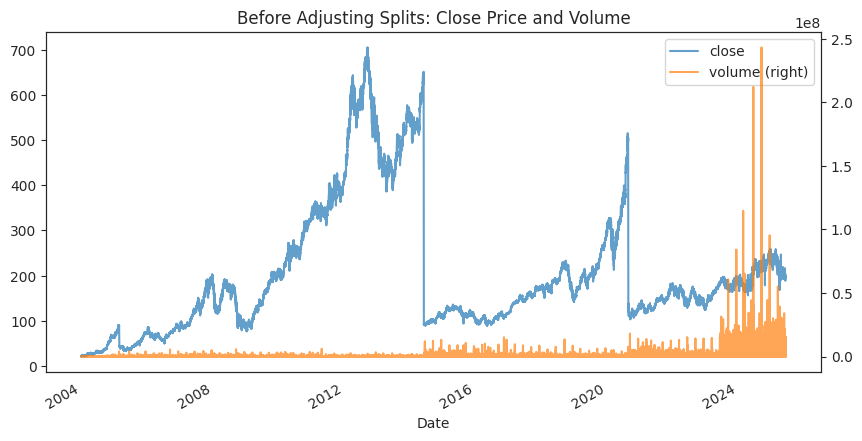

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


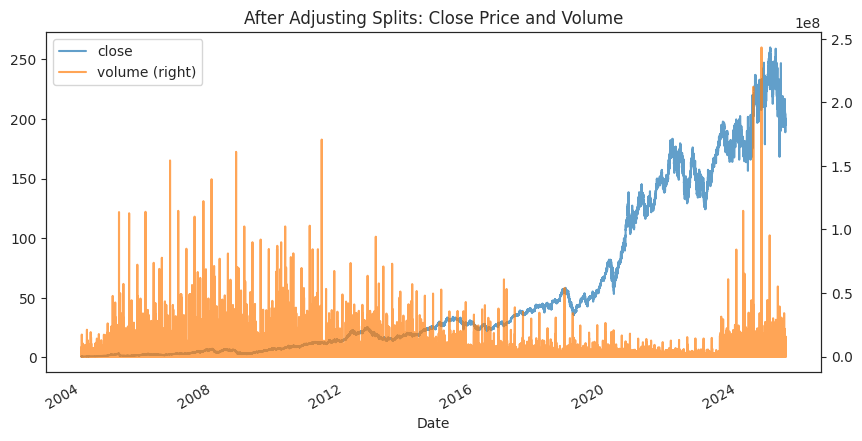

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764439,0.764132
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.854400,196.775600
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.714300,196.635700
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.709300,196.630700
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.279200,196.200800


In [3]:
base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = params.ticker,
    bidask_spread_pct   = params.bidask_spread_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
# tiny cleanup helper
def _cleanup():
    for (_, (df_sim, trades_list, _)) in simulation.items():
        del df_sim, trades_list
    del simulation
    gc.collect()

def optimization_function(
    df: pd.DataFrame,
    trial: optuna.Trial,
    min_prof_thr: float,
    max_down_prop: float,
    gain_tightening_factor: float,
    merging_retracement_thr: float,
    merging_time_gap_thr: float,
    tau_time: int,
    tau_dur: int,
    trailstop_pct: float,
    sign_thresh: float,
    beta_sat: float,
    smoothing_window: int,
    sess_start: time,
    sellmin_idx: int
) -> float:
    """
    1) Run the full backtest pipeline to simulate trades and P&L per day.
    2) Extract each day’s performance stats (strategy return and trade returns).
    3) Free intermediate DataFrames and trade lists to minimize memory usage.
    4) Compute total and average daily P&L across all trading days.
    5) Compute total trades and average return per trade.
    6) Print a summary of P&L metrics.
    Returns the average daily P&L for Optuna’s objective.
    """
    # A) Execute the end-to-end trading simulation
    simulation = trades.run_trading_pipeline(
        df                      = df, 
        min_prof_thr            = min_prof_thr,
        max_down_prop           = max_down_prop,
        gain_tightening_factor  = gain_tightening_factor,
        merging_retracement_thr = merging_retracement_thr,
        merging_time_gap_thr    = merging_time_gap_thr,
        tau_time                = tau_time,
        tau_dur                 = tau_dur,
        trailstop_pct           = trailstop_pct,
        sign_thresh             = sign_thresh,
        beta_sat                = beta_sat,
        smoothing_window        = smoothing_window,
        sess_start              = sess_start,
        sellmin_idx             = sellmin_idx
    )

    # # B) Extract per-day performance stats from simulation output
    # per_day_stats = [
    #     stats 
    #     for (_, (_, _, stats)) 
    #     in simulation.items()
    # ]

    # # C) Release DataFrames and trade lists to free memory
    # for (_, (df_sim, trades_list, _)) in simulation.items():
    #     del df_sim, trades_list
    # num_days = len(simulation)
    # del simulation
    # gc.collect()

    # # D) Compute average daily P&L
    # _num = lambda x: float((re.findall(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?", str(x)))[-1])
    # num_days = len(per_day_stats)
    # daily_returns = [_num(s["STRATEGY"]) for s in per_day_stats]
    # total_pnl     = float(np.sum(daily_returns))
    # avg_daily_pnl = total_pnl / num_days if num_days else 0.0
          
    # return avg_daily_pnl

    # B) Extract per-day performance stats from simulation output
    per_day_stats = [stats for (_, (_, _, stats)) in simulation.items()]
    
    # C) Incremental reporting and pruning (report every day)
    _num = lambda x: float((re.findall(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?", str(x)))[-1])
    daily_returns = []
    for idx, s in enumerate(per_day_stats, start=1):
        daily_returns.append(_num(s["STRATEGY"]))
        trial.report(float(np.mean(daily_returns)), idx)
        if trial.should_prune():
            _cleanup()
            raise optuna.TrialPruned()
    
    # D) Compute average daily P&L
    _cleanup()
    total_pnl = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / len(daily_returns) if daily_returns else 0.0
    
    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.1), # increasing min, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 3),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 5, 50),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 1, 7),
        "tau_time"                : trial.suggest_int("tau_time", 1, 60),
        "tau_dur"                 : trial.suggest_int("tau_dur", 60, 240),
        "trailstop_pct"           : trial.suggest_float("trailstop_pct", 0.03, 1), # increasing min, to reproduce a realistic scenario of trailing stop loss
        "sign_thresh"             : trial.suggest_float("sign_thresh", 0.1, 0.7),
        "beta_sat"                : trial.suggest_int("beta_sat", 1, 20),
        "smoothing_window"        : trial.suggest_int("smoothing_window", 1, 15),
        "sellmin_idx"             : trial.suggest_categorical("sellmin_idx", [None, -1, -3]),
        "sess_start"              : time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))
    }
    print('---------------------------------------------------------------------------------------------------------------\n')

    avg_daily_pnl = optimization_function(df=df, trial=trial, **hyperpars)
    
    return avg_daily_pnl

[I 2025-12-02 18:12:15,703] A new study created in memory with name: no-name-934ea6f5-c065-48cb-87a5-48b8b8e8912f


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.96it/s]
[I 2025-12-02 18:13:57,639] Trial 0 finished with value: 0.11640574074074077 and parameters: {'min_prof_thr': 0.03833135619695719, 'max_down_prop': 1.155137772409024, 'gain_tightening_factor': 11.496547826375345, 'merging_retracement_thr': 0.6173077340036605, 'merging_time_gap_thr': 6.768101210698241, 'tau_time': 36, 'tau_dur': 239, 'trailstop_pct': 0.8032888470750414, 'buy_thresh': 0.4340369169762367, 'beta_sat': 7, 'smoothing_window': 15, 'sellmin_idx': -1, 'sess_start': '14:30:00'}. Best is trial 0 with value: 0.11640574074074077.


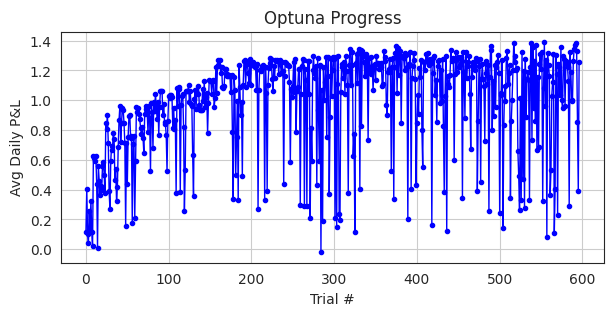

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:41<00:00, 53.08it/s]
[I 2025-12-02 18:16:06,536] Trial 1 finished with value: 0.4029627777777777 and parameters: {'min_prof_thr': 0.011519813742180359, 'max_down_prop': 0.6981302487212531, 'gain_tightening_factor': 34.00757401913627, 'merging_retracement_thr': 0.4624206238228231, 'merging_time_gap_thr': 5.862220796565678, 'tau_time': 54, 'tau_dur': 85, 'trailstop_pct': 0.5705613778881671, 'buy_thresh': 0.23843551224443077, 'beta_sat': 10, 'smoothing_window': 7, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 1 with value: 0.4029627777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:45<00:00, 51.03it/s]
[I 2025-12-02 18:18:06,915] Trial 2 finished with value: 0.10579648148148149 and parameters: {'min_prof_thr': 0.06633525823918913, 'max_down_prop': 2.809873939022048, 'gain_tightening_factor': 32.456792945972396, 'merging_retracement_thr': 0.9068679594971752, 'merging_time_gap_thr': 2.220634888357013, 'tau_time': 9, 'tau_dur': 146, 'trailstop_pct': 0.8826320767735721, 'buy_thresh': 0.44150477415479084, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 1 with value: 0.4029627777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.26it/s]
[I 2025-12-02 18:20:01,360] Trial 3 finished with value: 0.04017185185185184 and parameters: {'min_prof_thr': 0.02877635878814276, 'max_down_prop': 2.7172371523067227, 'gain_tightening_factor': 43.95473380116564, 'merging_retracement_thr': 0.6303181353506317, 'merging_time_gap_thr': 6.203220456904302, 'tau_time': 45, 'tau_dur': 106, 'trailstop_pct': 0.8903841865416304, 'buy_thresh': 0.2422036323799327, 'beta_sat': 2, 'smoothing_window': 11, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 1 with value: 0.4029627777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.97it/s]
[I 2025-12-02 18:21:42,196] Trial 4 finished with value: 0.25732037037037037 and parameters: {'min_prof_thr': 0.09080138774564556, 'max_down_prop': 0.8187474355366327, 'gain_tightening_factor': 23.924429416021045, 'merging_retracement_thr': 0.4023082724064063, 'merging_time_gap_thr': 6.4105207448941, 'tau_time': 60, 'tau_dur': 209, 'trailstop_pct': 0.9057941489537787, 'buy_thresh': 0.5830482841014193, 'beta_sat': 14, 'smoothing_window': 5, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 1 with value: 0.4029627777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.54it/s] 
[I 2025-12-02 18:23:22,541] Trial 5 finished with value: 0.12031462962962965 and parameters: {'min_prof_thr': 0.08982663326184678, 'max_down_prop': 0.8871255866746006, 'gain_tightening_factor': 34.51053580279515, 'merging_retracement_thr': 0.1802412331028767, 'merging_time_gap_thr': 6.296059401720871, 'tau_time': 11, 'tau_dur': 71, 'trailstop_pct': 0.038321764427198354, 'buy_thresh': 0.6139206995479594, 'beta_sat': 18, 'smoothing_window': 13, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 1 with value: 0.4029627777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.14it/s]
[I 2025-12-02 18:24:56,786] Trial 6 finished with value: 0.32493370370370367 and parameters: {'min_prof_thr': 0.0831222169245989, 'max_down_prop': 1.2024196206387985, 'gain_tightening_factor': 27.73096085331036, 'merging_retracement_thr': 0.7405797492080389, 'merging_time_gap_thr': 2.5986758679655884, 'tau_time': 19, 'tau_dur': 183, 'trailstop_pct': 0.4325100090942925, 'buy_thresh': 0.4369625646623778, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '14:30:00'}. Best is trial 1 with value: 0.4029627777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.52it/s]
[I 2025-12-02 18:26:42,247] Trial 7 finished with value: 0.11686944444444446 and parameters: {'min_prof_thr': 0.08167781793223312, 'max_down_prop': 2.3465394955493, 'gain_tightening_factor': 41.12966558617278, 'merging_retracement_thr': 0.4576519878415113, 'merging_time_gap_thr': 1.5738065013523506, 'tau_time': 38, 'tau_dur': 113, 'trailstop_pct': 0.7091696153598664, 'buy_thresh': 0.6885610229128016, 'beta_sat': 14, 'smoothing_window': 7, 'sellmin_idx': -1, 'sess_start': '14:30:00'}. Best is trial 1 with value: 0.4029627777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.18it/s]
[I 2025-12-02 18:28:22,680] Trial 8 finished with value: 0.01991777777777778 and parameters: {'min_prof_thr': 0.01945125752390501, 'max_down_prop': 1.4505962988589018, 'gain_tightening_factor': 12.170027811611394, 'merging_retracement_thr': 0.837182300558758, 'merging_time_gap_thr': 2.5354382173363743, 'tau_time': 36, 'tau_dur': 108, 'trailstop_pct': 0.2401773554537591, 'buy_thresh': 0.5215784807097, 'beta_sat': 3, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '14:30:00'}. Best is trial 1 with value: 0.4029627777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:03<00:00, 85.56it/s]
[I 2025-12-02 18:29:35,700] Trial 9 finished with value: 0.6238692592592592 and parameters: {'min_prof_thr': 0.09210414117272475, 'max_down_prop': 2.3834538067357816, 'gain_tightening_factor': 15.778016550880167, 'merging_retracement_thr': 0.4577154749795578, 'merging_time_gap_thr': 1.6949538406715299, 'tau_time': 60, 'tau_dur': 212, 'trailstop_pct': 0.2331653457144151, 'buy_thresh': 0.21579687123320906, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 9 with value: 0.6238692592592592.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.50it/s]
[I 2025-12-02 18:31:16,138] Trial 10 finished with value: 0.6141564814814815 and parameters: {'min_prof_thr': 0.05713771599014482, 'max_down_prop': 1.97575058905793, 'gain_tightening_factor': 18.8394523657207, 'merging_retracement_thr': 0.19307148185190742, 'merging_time_gap_thr': 3.9170067809877827, 'tau_time': 22, 'tau_dur': 171, 'trailstop_pct': 0.27256496741678443, 'buy_thresh': 0.12977221624429786, 'beta_sat': 20, 'smoothing_window': 4, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 9 with value: 0.6238692592592592.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.35it/s]
[I 2025-12-02 18:32:52,713] Trial 11 finished with value: 0.5915492592592594 and parameters: {'min_prof_thr': 0.06095363310041039, 'max_down_prop': 1.9352617099480813, 'gain_tightening_factor': 18.941232715992918, 'merging_retracement_thr': 0.14239879916812115, 'merging_time_gap_thr': 4.202695085111062, 'tau_time': 24, 'tau_dur': 174, 'trailstop_pct': 0.26154688188595754, 'buy_thresh': 0.10487636268013595, 'beta_sat': 20, 'smoothing_window': 4, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 9 with value: 0.6238692592592592.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.79it/s]
[I 2025-12-02 18:34:36,455] Trial 12 finished with value: 0.6247061111111111 and parameters: {'min_prof_thr': 0.04579522977016992, 'max_down_prop': 1.9192280927363148, 'gain_tightening_factor': 17.75659878788756, 'merging_retracement_thr': 0.2802538345845703, 'merging_time_gap_thr': 4.002276835819761, 'tau_time': 26, 'tau_dur': 218, 'trailstop_pct': 0.23300128270617773, 'buy_thresh': 0.11280225732180882, 'beta_sat': 20, 'smoothing_window': 4, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.45it/s]
[I 2025-12-02 18:36:06,217] Trial 13 finished with value: 0.4390316666666667 and parameters: {'min_prof_thr': 0.042418003422924705, 'max_down_prop': 2.016234250207852, 'gain_tightening_factor': 5.29569499689023, 'merging_retracement_thr': 0.31810883150089486, 'merging_time_gap_thr': 4.166351768532403, 'tau_time': 48, 'tau_dur': 232, 'trailstop_pct': 0.045610276700373764, 'buy_thresh': 0.2479846086771538, 'beta_sat': 12, 'smoothing_window': 9, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.90it/s]
[I 2025-12-02 18:37:49,322] Trial 14 finished with value: 0.010871666666666663 and parameters: {'min_prof_thr': 0.06984266988203465, 'max_down_prop': 0.18547002540296886, 'gain_tightening_factor': 16.700931608644932, 'merging_retracement_thr': 0.2973055055368186, 'merging_time_gap_thr': 5.100056599481153, 'tau_time': 2, 'tau_dur': 215, 'trailstop_pct': 0.37231347814880184, 'buy_thresh': 0.3284091702812003, 'beta_sat': 17, 'smoothing_window': 5, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.68it/s] 
[I 2025-12-02 18:39:25,345] Trial 15 finished with value: 0.5574235185185186 and parameters: {'min_prof_thr': 0.04316978386094733, 'max_down_prop': 2.386848203609543, 'gain_tightening_factor': 49.87546793992975, 'merging_retracement_thr': 0.5570434116801546, 'merging_time_gap_thr': 3.151969072875314, 'tau_time': 27, 'tau_dur': 202, 'trailstop_pct': 0.16839344715174925, 'buy_thresh': 0.17057189335826617, 'beta_sat': 8, 'smoothing_window': 3, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.31it/s]
[I 2025-12-02 18:40:59,463] Trial 16 finished with value: 0.45954629629629634 and parameters: {'min_prof_thr': 0.09992372133664032, 'max_down_prop': 1.6523270848459413, 'gain_tightening_factor': 5.0779998947762515, 'merging_retracement_thr': 0.3419795804154382, 'merging_time_gap_thr': 1.074565165593523, 'tau_time': 45, 'tau_dur': 144, 'trailstop_pct': 0.4799181684547479, 'buy_thresh': 0.3398076842712764, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 58.04it/s]
[I 2025-12-02 18:42:50,175] Trial 17 finished with value: 0.3654201851851852 and parameters: {'min_prof_thr': 0.049912974532975926, 'max_down_prop': 2.409861024288199, 'gain_tightening_factor': 24.71123937737613, 'merging_retracement_thr': 0.25824295497504346, 'merging_time_gap_thr': 5.045330469413573, 'tau_time': 16, 'tau_dur': 191, 'trailstop_pct': 0.5770254169667939, 'buy_thresh': 0.18838833576003666, 'beta_sat': 20, 'smoothing_window': 9, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.61it/s]
[I 2025-12-02 18:44:23,449] Trial 18 finished with value: 0.4246712962962963 and parameters: {'min_prof_thr': 0.03008344603108271, 'max_down_prop': 2.993544811942302, 'gain_tightening_factor': 14.462936766186012, 'merging_retracement_thr': 0.10069167117555194, 'merging_time_gap_thr': 3.4063845959003145, 'tau_time': 31, 'tau_dur': 225, 'trailstop_pct': 0.15253916189279437, 'buy_thresh': 0.31532750403343857, 'beta_sat': 12, 'smoothing_window': 7, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.22it/s]
[I 2025-12-02 18:45:58,990] Trial 19 finished with value: 0.4009374074074074 and parameters: {'min_prof_thr': 0.06915910397491531, 'max_down_prop': 1.7150936665103544, 'gain_tightening_factor': 9.685462226797554, 'merging_retracement_thr': 0.4750994497176409, 'merging_time_gap_thr': 4.997673327063718, 'tau_time': 60, 'tau_dur': 164, 'trailstop_pct': 0.3713935889912377, 'buy_thresh': 0.170882499144779, 'beta_sat': 18, 'smoothing_window': 5, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:00<00:00, 89.85it/s] 
[I 2025-12-02 18:47:10,056] Trial 20 finished with value: 0.5573781481481481 and parameters: {'min_prof_thr': 0.050345452865423496, 'max_down_prop': 2.182188071595159, 'gain_tightening_factor': 23.24132713181207, 'merging_retracement_thr': 0.7395053337289467, 'merging_time_gap_thr': 1.8163746326833081, 'tau_time': 31, 'tau_dur': 198, 'trailstop_pct': 0.15067752948711755, 'buy_thresh': 0.10102471874996219, 'beta_sat': 4, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:07<00:00, 79.98it/s]
[I 2025-12-02 18:48:28,379] Trial 21 finished with value: 0.5876092592592593 and parameters: {'min_prof_thr': 0.05984610838036406, 'max_down_prop': 1.8958988734418458, 'gain_tightening_factor': 19.098782134881546, 'merging_retracement_thr': 0.2138953152874415, 'merging_time_gap_thr': 3.5295731520747284, 'tau_time': 24, 'tau_dur': 162, 'trailstop_pct': 0.3019542907126573, 'buy_thresh': 0.14188545186613527, 'beta_sat': 20, 'smoothing_window': 4, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.58it/s]
[I 2025-12-02 18:49:51,758] Trial 22 finished with value: 0.5004792592592592 and parameters: {'min_prof_thr': 0.07564344949732066, 'max_down_prop': 2.5455410097892477, 'gain_tightening_factor': 15.301688722799062, 'merging_retracement_thr': 0.3933413139644898, 'merging_time_gap_thr': 3.860411981832592, 'tau_time': 20, 'tau_dur': 219, 'trailstop_pct': 0.3689369876147543, 'buy_thresh': 0.22374118783049474, 'beta_sat': 20, 'smoothing_window': 3, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:08<00:00, 78.38it/s] 
[I 2025-12-02 18:51:11,642] Trial 23 finished with value: 0.37861074074074075 and parameters: {'min_prof_thr': 0.05386098910553361, 'max_down_prop': 2.148527019650031, 'gain_tightening_factor': 20.966356336757052, 'merging_retracement_thr': 0.2313793327236874, 'merging_time_gap_thr': 4.437047274652588, 'tau_time': 15, 'tau_dur': 180, 'trailstop_pct': 0.19622345052288548, 'buy_thresh': 0.2933389907103664, 'beta_sat': 17, 'smoothing_window': 6, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 12 with value: 0.6247061111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 62.01it/s]
[I 2025-12-02 18:52:57,910] Trial 24 finished with value: 0.8445707407407407 and parameters: {'min_prof_thr': 0.028407872569116047, 'max_down_prop': 1.4833004948754218, 'gain_tightening_factor': 28.428913944968997, 'merging_retracement_thr': 0.3763030755712659, 'merging_time_gap_thr': 3.058058887894107, 'tau_time': 41, 'tau_dur': 133, 'trailstop_pct': 0.10182429399990073, 'buy_thresh': 0.14449937881334995, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 24 with value: 0.8445707407407407.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.35it/s]
[I 2025-12-02 18:54:44,542] Trial 25 finished with value: 0.8090544444444445 and parameters: {'min_prof_thr': 0.027563774038283657, 'max_down_prop': 1.420162864966328, 'gain_tightening_factor': 28.564738609482763, 'merging_retracement_thr': 0.5593215238406826, 'merging_time_gap_thr': 2.961636213741044, 'tau_time': 52, 'tau_dur': 121, 'trailstop_pct': 0.09063109120568678, 'buy_thresh': 0.19712548656836898, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 24 with value: 0.8445707407407407.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.49it/s]
[I 2025-12-02 18:56:37,866] Trial 26 finished with value: 0.8989359259259259 and parameters: {'min_prof_thr': 0.028841483862737605, 'max_down_prop': 1.4458775329260178, 'gain_tightening_factor': 29.983846803360144, 'merging_retracement_thr': 0.5653301904209166, 'merging_time_gap_thr': 2.9597140978623213, 'tau_time': 51, 'tau_dur': 129, 'trailstop_pct': 0.10833537220559257, 'buy_thresh': 0.15940699699195826, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.75it/s]
[I 2025-12-02 18:58:23,211] Trial 27 finished with value: 0.7146874074074074 and parameters: {'min_prof_thr': 0.031818807352337074, 'max_down_prop': 1.3895850123794262, 'gain_tightening_factor': 29.697149331639565, 'merging_retracement_thr': 0.540070842121906, 'merging_time_gap_thr': 2.9009986516863546, 'tau_time': 52, 'tau_dur': 131, 'trailstop_pct': 0.0915445789307939, 'buy_thresh': 0.2884911015997227, 'beta_sat': 13, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.61it/s]
[I 2025-12-02 19:00:01,254] Trial 28 finished with value: 0.3908435185185185 and parameters: {'min_prof_thr': 0.021506673634321467, 'max_down_prop': 1.1819812807872736, 'gain_tightening_factor': 30.48662303664807, 'merging_retracement_thr': 0.6893826776122196, 'merging_time_gap_thr': 2.2563127935153693, 'tau_time': 42, 'tau_dur': 125, 'trailstop_pct': 0.11115192290482984, 'buy_thresh': 0.37987874413565603, 'beta_sat': 10, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:12<00:00, 74.35it/s]
[I 2025-12-02 19:01:30,212] Trial 29 finished with value: 0.2689096296296296 and parameters: {'min_prof_thr': 0.03560140128537753, 'max_down_prop': 0.9946789065303712, 'gain_tightening_factor': 37.76889109806967, 'merging_retracement_thr': 0.5713129069231282, 'merging_time_gap_thr': 2.971597945299038, 'tau_time': 53, 'tau_dur': 91, 'trailstop_pct': 0.9955851530223505, 'buy_thresh': 0.17308152414740827, 'beta_sat': 8, 'smoothing_window': 13, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.80it/s]
[I 2025-12-02 19:03:19,576] Trial 30 finished with value: 0.5936692592592592 and parameters: {'min_prof_thr': 0.021402421739496504, 'max_down_prop': 0.5836451398086641, 'gain_tightening_factor': 27.111840456351302, 'merging_retracement_thr': 0.6693023172550069, 'merging_time_gap_thr': 3.379441821690425, 'tau_time': 49, 'tau_dur': 131, 'trailstop_pct': 0.08997236763150002, 'buy_thresh': 0.37891659486960866, 'beta_sat': 16, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.20it/s]
[I 2025-12-02 19:05:07,039] Trial 31 finished with value: 0.6951161111111112 and parameters: {'min_prof_thr': 0.035260587504223895, 'max_down_prop': 1.4306381299140634, 'gain_tightening_factor': 30.31555089042341, 'merging_retracement_thr': 0.5340800627358873, 'merging_time_gap_thr': 2.8666611573593035, 'tau_time': 54, 'tau_dur': 130, 'trailstop_pct': 0.10043845463417284, 'buy_thresh': 0.2818965062575869, 'beta_sat': 12, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:06<00:00, 80.97it/s] 
[I 2025-12-02 19:06:36,490] Trial 32 finished with value: 0.666490925925926 and parameters: {'min_prof_thr': 0.010741302037532204, 'max_down_prop': 1.322720705901915, 'gain_tightening_factor': 37.230277720727955, 'merging_retracement_thr': 0.5276170151393713, 'merging_time_gap_thr': 2.7089118625019397, 'tau_time': 51, 'tau_dur': 117, 'trailstop_pct': 0.03217965943351987, 'buy_thresh': 0.2720603059857068, 'beta_sat': 14, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.08it/s]
[I 2025-12-02 19:08:20,778] Trial 33 finished with value: 0.7772298148148149 and parameters: {'min_prof_thr': 0.03040825272856588, 'max_down_prop': 1.6330113387325684, 'gain_tightening_factor': 27.06216032993668, 'merging_retracement_thr': 0.6182759730847324, 'merging_time_gap_thr': 2.2247771898884894, 'tau_time': 40, 'tau_dur': 141, 'trailstop_pct': 0.10456747669952166, 'buy_thresh': 0.20215463680625806, 'beta_sat': 13, 'smoothing_window': 3, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:39<00:00, 54.35it/s]
[I 2025-12-02 19:10:19,702] Trial 34 finished with value: 0.741695 and parameters: {'min_prof_thr': 0.02625184558799684, 'max_down_prop': 1.6014519267517295, 'gain_tightening_factor': 26.44116777932634, 'merging_retracement_thr': 0.6455530937198919, 'merging_time_gap_thr': 1.9318295176459541, 'tau_time': 43, 'tau_dur': 152, 'trailstop_pct': 0.1754616483142027, 'buy_thresh': 0.19595294169477875, 'beta_sat': 15, 'smoothing_window': 3, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:50<00:00, 49.07it/s]
[I 2025-12-02 19:12:33,647] Trial 35 finished with value: 0.46622500000000006 and parameters: {'min_prof_thr': 0.018170484564088256, 'max_down_prop': 1.0689110481544297, 'gain_tightening_factor': 33.32200889850148, 'merging_retracement_thr': 0.589421290730193, 'merging_time_gap_thr': 2.350382175666662, 'tau_time': 39, 'tau_dur': 98, 'trailstop_pct': 0.585231853678008, 'buy_thresh': 0.14778782164758858, 'beta_sat': 11, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:40<00:00, 53.68it/s]
[I 2025-12-02 19:14:36,559] Trial 36 finished with value: 0.5370024074074075 and parameters: {'min_prof_thr': 0.014743351615095646, 'max_down_prop': 0.6418934261027293, 'gain_tightening_factor': 36.01044177599711, 'merging_retracement_thr': 0.9980635571087113, 'merging_time_gap_thr': 2.078380802971102, 'tau_time': 33, 'tau_dur': 146, 'trailstop_pct': 0.3220128055407412, 'buy_thresh': 0.23709901923346155, 'beta_sat': 9, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.14it/s]
[I 2025-12-02 19:16:32,976] Trial 37 finished with value: 0.3209516666666667 and parameters: {'min_prof_thr': 0.025784871182189882, 'max_down_prop': 1.6896675684275964, 'gain_tightening_factor': 22.386288903807888, 'merging_retracement_thr': 0.3822270689635497, 'merging_time_gap_thr': 1.3342683321386488, 'tau_time': 57, 'tau_dur': 78, 'trailstop_pct': 0.6546354755171976, 'buy_thresh': 0.15134593030167345, 'beta_sat': 5, 'smoothing_window': 15, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.35it/s]
[I 2025-12-02 19:18:19,907] Trial 38 finished with value: 0.4159981481481481 and parameters: {'min_prof_thr': 0.03788532296627842, 'max_down_prop': 1.2707396307657655, 'gain_tightening_factor': 31.6614707323316, 'merging_retracement_thr': 0.7219368042646004, 'merging_time_gap_thr': 3.163355133134824, 'tau_time': 48, 'tau_dur': 139, 'trailstop_pct': 0.11711998823480288, 'buy_thresh': 0.4791420409506215, 'beta_sat': 15, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:39<00:00, 54.18it/s]
[I 2025-12-02 19:20:18,823] Trial 39 finished with value: 0.685767962962963 and parameters: {'min_prof_thr': 0.025598248308750186, 'max_down_prop': 1.7783304709255092, 'gain_tightening_factor': 28.311813030818165, 'merging_retracement_thr': 0.8048315116501741, 'merging_time_gap_thr': 3.652160275348721, 'tau_time': 40, 'tau_dur': 153, 'trailstop_pct': 0.20124804960935272, 'buy_thresh': 0.2077262558854978, 'beta_sat': 18, 'smoothing_window': 6, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.73it/s]
[I 2025-12-02 19:22:11,639] Trial 40 finished with value: 0.8664909259259258 and parameters: {'min_prof_thr': 0.03236939280192215, 'max_down_prop': 1.5146205972048645, 'gain_tightening_factor': 25.516012023667333, 'merging_retracement_thr': 0.6150688422296082, 'merging_time_gap_thr': 2.5798277578106648, 'tau_time': 45, 'tau_dur': 63, 'trailstop_pct': 0.0632002383190134, 'buy_thresh': 0.2563230345449715, 'beta_sat': 13, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 26 with value: 0.8989359259259259.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 54.99it/s]
[I 2025-12-02 19:24:08,464] Trial 41 finished with value: 0.9612127777777778 and parameters: {'min_prof_thr': 0.03198200856153583, 'max_down_prop': 1.4943979748143332, 'gain_tightening_factor': 25.028238960894797, 'merging_retracement_thr': 0.6138471457458916, 'merging_time_gap_thr': 6.997446702084402, 'tau_time': 45, 'tau_dur': 60, 'trailstop_pct': 0.06172444810506894, 'buy_thresh': 0.19493393823071362, 'beta_sat': 13, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.48it/s]
[I 2025-12-02 19:26:03,561] Trial 42 finished with value: 0.7183072222222222 and parameters: {'min_prof_thr': 0.033358203564772426, 'max_down_prop': 1.509241220398797, 'gain_tightening_factor': 25.059724785953588, 'merging_retracement_thr': 0.4938169725734266, 'merging_time_gap_thr': 6.909990950898021, 'tau_time': 56, 'tau_dur': 67, 'trailstop_pct': 0.06146919589360933, 'buy_thresh': 0.2531799398388433, 'beta_sat': 11, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:43<00:00, 52.21it/s]
[I 2025-12-02 19:28:06,798] Trial 43 finished with value: 0.8452522222222222 and parameters: {'min_prof_thr': 0.04154683094285442, 'max_down_prop': 0.8455584006471243, 'gain_tightening_factor': 34.35716006094013, 'merging_retracement_thr': 0.43552438872155685, 'merging_time_gap_thr': 4.575858572073804, 'tau_time': 46, 'tau_dur': 60, 'trailstop_pct': 0.14647943619844336, 'buy_thresh': 0.13038433523742424, 'beta_sat': 13, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.11it/s]
[I 2025-12-02 19:30:04,881] Trial 44 finished with value: 0.950655925925926 and parameters: {'min_prof_thr': 0.04085644143389928, 'max_down_prop': 0.8009578420010705, 'gain_tightening_factor': 40.99523338508626, 'merging_retracement_thr': 0.42687780308310636, 'merging_time_gap_thr': 5.757935909664238, 'tau_time': 45, 'tau_dur': 62, 'trailstop_pct': 0.03309233818846802, 'buy_thresh': 0.1495777896917413, 'beta_sat': 13, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:42<00:00, 52.86it/s]
[I 2025-12-02 19:32:09,539] Trial 45 finished with value: 0.9362222222222221 and parameters: {'min_prof_thr': 0.040861931265634525, 'max_down_prop': 0.4581473843334241, 'gain_tightening_factor': 40.31376752577996, 'merging_retracement_thr': 0.4319259244289437, 'merging_time_gap_thr': 6.006479441076976, 'tau_time': 45, 'tau_dur': 75, 'trailstop_pct': 0.032650265371103306, 'buy_thresh': 0.12617464395560937, 'beta_sat': 13, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 59.20it/s]
[I 2025-12-02 19:34:00,628] Trial 46 finished with value: 0.8479251851851852 and parameters: {'min_prof_thr': 0.039036134417767675, 'max_down_prop': 0.1996527823389665, 'gain_tightening_factor': 42.40256311778583, 'merging_retracement_thr': 0.4859266139044841, 'merging_time_gap_thr': 5.8969167765107295, 'tau_time': 36, 'tau_dur': 81, 'trailstop_pct': 0.030922629117001943, 'buy_thresh': 0.1639317612318551, 'beta_sat': 10, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.95it/s]
[I 2025-12-02 19:35:43,873] Trial 47 finished with value: 0.713647962962963 and parameters: {'min_prof_thr': 0.047357640805609995, 'max_down_prop': 0.4052978844861798, 'gain_tightening_factor': 46.439502419592, 'merging_retracement_thr': 0.4314312277362928, 'merging_time_gap_thr': 6.594793007466607, 'tau_time': 44, 'tau_dur': 70, 'trailstop_pct': 0.20911393487680244, 'buy_thresh': 0.11259654258083532, 'beta_sat': 14, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.60it/s]
[I 2025-12-02 19:37:34,819] Trial 48 finished with value: 0.1576101851851852 and parameters: {'min_prof_thr': 0.03804448709854384, 'max_down_prop': 0.33764493384473404, 'gain_tightening_factor': 40.53250029910263, 'merging_retracement_thr': 0.8057969633137532, 'merging_time_gap_thr': 5.961165835569983, 'tau_time': 47, 'tau_dur': 93, 'trailstop_pct': 0.06159979162579256, 'buy_thresh': 0.68045564629086, 'beta_sat': 13, 'smoothing_window': 4, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.92it/s]
[I 2025-12-02 19:39:21,797] Trial 49 finished with value: 0.7120861111111112 and parameters: {'min_prof_thr': 0.04570384529017321, 'max_down_prop': 0.44196674258456303, 'gain_tightening_factor': 46.715497765126834, 'merging_retracement_thr': 0.607692342206257, 'merging_time_gap_thr': 6.427546994626927, 'tau_time': 35, 'tau_dur': 76, 'trailstop_pct': 0.1391287682568037, 'buy_thresh': 0.22715373533819008, 'beta_sat': 16, 'smoothing_window': 10, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 56.14it/s]
[I 2025-12-02 19:41:16,460] Trial 50 finished with value: 0.4392974074074074 and parameters: {'min_prof_thr': 0.05348944212191576, 'max_down_prop': 1.0350039552512849, 'gain_tightening_factor': 39.459643384942, 'merging_retracement_thr': 0.49927332777866823, 'merging_time_gap_thr': 5.666716304036173, 'tau_time': 57, 'tau_dur': 60, 'trailstop_pct': 0.7850012657769695, 'buy_thresh': 0.2600918352324367, 'beta_sat': 11, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.74it/s]
[I 2025-12-02 19:43:10,773] Trial 51 finished with value: 0.7528990740740741 and parameters: {'min_prof_thr': 0.04028341222493433, 'max_down_prop': 0.2675547443921419, 'gain_tightening_factor': 42.580495647390144, 'merging_retracement_thr': 0.41999800546019755, 'merging_time_gap_thr': 5.695386895014013, 'tau_time': 37, 'tau_dur': 79, 'trailstop_pct': 0.03116048765849531, 'buy_thresh': 0.16891442231517434, 'beta_sat': 9, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.28it/s]
[I 2025-12-02 19:45:09,670] Trial 52 finished with value: 0.8977259259259259 and parameters: {'min_prof_thr': 0.03724058046689334, 'max_down_prop': 0.16453092477278014, 'gain_tightening_factor': 44.42105229432005, 'merging_retracement_thr': 0.34197951199014953, 'merging_time_gap_thr': 5.371734358181075, 'tau_time': 50, 'tau_dur': 87, 'trailstop_pct': 0.03538149447517608, 'buy_thresh': 0.12215910521031222, 'beta_sat': 12, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 59.17it/s]
[I 2025-12-02 19:47:05,525] Trial 53 finished with value: 0.9024218518518518 and parameters: {'min_prof_thr': 0.035380665739951134, 'max_down_prop': 0.7040009435857031, 'gain_tightening_factor': 45.136717656561174, 'merging_retracement_thr': 0.3521439914846396, 'merging_time_gap_thr': 5.39583467929678, 'tau_time': 50, 'tau_dur': 101, 'trailstop_pct': 0.06380068144313765, 'buy_thresh': 0.12646359212169428, 'beta_sat': 12, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.64it/s]
[I 2025-12-02 19:48:58,822] Trial 54 finished with value: 0.7463485185185186 and parameters: {'min_prof_thr': 0.035220120942165936, 'max_down_prop': 0.7819674003497923, 'gain_tightening_factor': 46.159862961985915, 'merging_retracement_thr': 0.34055262198613906, 'merging_time_gap_thr': 5.39467622934059, 'tau_time': 50, 'tau_dur': 104, 'trailstop_pct': 0.07212118646097654, 'buy_thresh': 0.12932565891758763, 'beta_sat': 12, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 54.95it/s]
[I 2025-12-02 19:50:56,261] Trial 55 finished with value: 0.761255 and parameters: {'min_prof_thr': 0.044088347115730994, 'max_down_prop': 0.5040995885631152, 'gain_tightening_factor': 44.74110494902457, 'merging_retracement_thr': 0.311983361978557, 'merging_time_gap_thr': 6.163990832839868, 'tau_time': 56, 'tau_dur': 88, 'trailstop_pct': 0.171113331115385, 'buy_thresh': 0.11851509271234106, 'beta_sat': 14, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.31it/s]
[I 2025-12-02 19:52:41,236] Trial 56 finished with value: 0.1748759259259259 and parameters: {'min_prof_thr': 0.048755848591473284, 'max_down_prop': 0.7676978520009364, 'gain_tightening_factor': 44.29831956215015, 'merging_retracement_thr': 0.3410843215508117, 'merging_time_gap_thr': 5.254616349004446, 'tau_time': 50, 'tau_dur': 102, 'trailstop_pct': 0.27417742340356843, 'buy_thresh': 0.10379779761564309, 'beta_sat': 1, 'smoothing_window': 4, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 59.13it/s]
[I 2025-12-02 19:54:34,171] Trial 57 finished with value: 0.7069987037037038 and parameters: {'min_prof_thr': 0.024441556896545195, 'max_down_prop': 0.563282298149011, 'gain_tightening_factor': 48.39446606120569, 'merging_retracement_thr': 0.4386338485165322, 'merging_time_gap_thr': 4.753235500494109, 'tau_time': 47, 'tau_dur': 110, 'trailstop_pct': 0.23630248478166888, 'buy_thresh': 0.18659671945949732, 'beta_sat': 12, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 58.05it/s]
[I 2025-12-02 19:56:31,681] Trial 58 finished with value: 0.7605892592592592 and parameters: {'min_prof_thr': 0.017396653381575256, 'max_down_prop': 0.13318530751043722, 'gain_tightening_factor': 39.31069500310406, 'merging_retracement_thr': 0.36711277189099406, 'merging_time_gap_thr': 6.990483122065261, 'tau_time': 43, 'tau_dur': 73, 'trailstop_pct': 0.12306714615882558, 'buy_thresh': 0.1504932297328337, 'beta_sat': 14, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.66it/s]
[I 2025-12-02 19:58:18,963] Trial 59 finished with value: 0.21207592592592595 and parameters: {'min_prof_thr': 0.042015288043691444, 'max_down_prop': 0.9352598160204868, 'gain_tightening_factor': 41.92544774881418, 'merging_retracement_thr': 0.5127432210481889, 'merging_time_gap_thr': 5.561601037394347, 'tau_time': 54, 'tau_dur': 85, 'trailstop_pct': 0.5216509051739318, 'buy_thresh': 0.5460745095961547, 'beta_sat': 11, 'smoothing_window': 5, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.39it/s]
[I 2025-12-02 20:00:13,962] Trial 60 finished with value: 0.5901664814814815 and parameters: {'min_prof_thr': 0.057300347119285285, 'max_down_prop': 0.40603720527226855, 'gain_tightening_factor': 49.82702134275138, 'merging_retracement_thr': 0.2791183180338065, 'merging_time_gap_thr': 6.633953682824557, 'tau_time': 5, 'tau_dur': 96, 'trailstop_pct': 0.1406937380611035, 'buy_thresh': 0.13264062815629296, 'beta_sat': 15, 'smoothing_window': 8, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.49it/s]
[I 2025-12-02 20:02:08,486] Trial 61 finished with value: 0.9565103703703706 and parameters: {'min_prof_thr': 0.031936813082743744, 'max_down_prop': 0.694595127515655, 'gain_tightening_factor': 22.02920625613775, 'merging_retracement_thr': 0.5898430836747783, 'merging_time_gap_thr': 6.146174817238112, 'tau_time': 45, 'tau_dur': 66, 'trailstop_pct': 0.056849145864213545, 'buy_thresh': 0.1802761826157218, 'beta_sat': 13, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 56.94it/s]
[I 2025-12-02 20:04:02,635] Trial 62 finished with value: 0.9188111111111112 and parameters: {'min_prof_thr': 0.03597470739859054, 'max_down_prop': 0.6749124242187111, 'gain_tightening_factor': 21.31084441663804, 'merging_retracement_thr': 0.4652409219816511, 'merging_time_gap_thr': 6.1784166398698535, 'tau_time': 49, 'tau_dur': 66, 'trailstop_pct': 0.06509689682934328, 'buy_thresh': 0.17977318554026747, 'beta_sat': 13, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.38it/s]
[I 2025-12-02 20:05:52,084] Trial 63 finished with value: 0.9477374074074073 and parameters: {'min_prof_thr': 0.02187606791784917, 'max_down_prop': 0.6936908573788131, 'gain_tightening_factor': 20.43860110403527, 'merging_retracement_thr': 0.46205053241931615, 'merging_time_gap_thr': 6.113099582585912, 'tau_time': 45, 'tau_dur': 68, 'trailstop_pct': 0.06097557976222445, 'buy_thresh': 0.18630528653846676, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:07<00:00, 80.42it/s]
[I 2025-12-02 20:07:15,337] Trial 64 finished with value: 0.9102025925925924 and parameters: {'min_prof_thr': 0.023142158961243713, 'max_down_prop': 0.7272840057140054, 'gain_tightening_factor': 20.803197166808626, 'merging_retracement_thr': 0.46353348978475944, 'merging_time_gap_thr': 6.095591492377875, 'tau_time': 46, 'tau_dur': 67, 'trailstop_pct': 0.06683412372889726, 'buy_thresh': 0.21620056949085664, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:05<00:00, 82.51it/s]
[I 2025-12-02 20:08:38,067] Trial 65 finished with value: 0.8737807407407406 and parameters: {'min_prof_thr': 0.014343094626631116, 'max_down_prop': 0.653205580007241, 'gain_tightening_factor': 21.411311856205618, 'merging_retracement_thr': 0.46741977531644807, 'merging_time_gap_thr': 6.13560328170227, 'tau_time': 45, 'tau_dur': 67, 'trailstop_pct': 0.07675230291104021, 'buy_thresh': 0.2216349734355017, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.36it/s]
[I 2025-12-02 20:10:29,532] Trial 66 finished with value: 0.8161344444444445 and parameters: {'min_prof_thr': 0.02239288759997195, 'max_down_prop': 0.916440834387813, 'gain_tightening_factor': 19.97855974931143, 'merging_retracement_thr': 0.40334175188027654, 'merging_time_gap_thr': 6.466367926232937, 'tau_time': 38, 'tau_dur': 68, 'trailstop_pct': 0.18747919876614094, 'buy_thresh': 0.18063463246018993, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.00it/s]
[I 2025-12-02 20:12:17,852] Trial 67 finished with value: 0.7755474074074075 and parameters: {'min_prof_thr': 0.030688854668562922, 'max_down_prop': 1.0970368499733176, 'gain_tightening_factor': 17.83844783439867, 'merging_retracement_thr': 0.45896575438950454, 'merging_time_gap_thr': 6.264812811400413, 'tau_time': 41, 'tau_dur': 73, 'trailstop_pct': 0.12832527490063877, 'buy_thresh': 0.30969287202650797, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 56.12it/s]
[I 2025-12-02 20:14:16,137] Trial 68 finished with value: 0.8174953703703705 and parameters: {'min_prof_thr': 0.023284597644110505, 'max_down_prop': 0.7236550556662441, 'gain_tightening_factor': 22.974554134616458, 'merging_retracement_thr': 0.6511262286927212, 'merging_time_gap_thr': 6.726229694248344, 'tau_time': 43, 'tau_dur': 63, 'trailstop_pct': 0.07471041491527369, 'buy_thresh': 0.208429601578729, 'beta_sat': 16, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 59.23it/s]
[I 2025-12-02 20:16:08,835] Trial 69 finished with value: 0.7495518518518519 and parameters: {'min_prof_thr': 0.01969140666229299, 'max_down_prop': 0.5545593738503537, 'gain_tightening_factor': 12.875082428458414, 'merging_retracement_thr': 0.5834731373881007, 'merging_time_gap_thr': 5.982507442814063, 'tau_time': 46, 'tau_dur': 82, 'trailstop_pct': 0.21382024001233502, 'buy_thresh': 0.23445873559653413, 'beta_sat': 13, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 56.12it/s]
[I 2025-12-02 20:18:04,065] Trial 70 finished with value: 0.6429985185185185 and parameters: {'min_prof_thr': 0.06376952899522915, 'max_down_prop': 0.300006407869357, 'gain_tightening_factor': 16.68855304572137, 'merging_retracement_thr': 0.4086442406044018, 'merging_time_gap_thr': 5.764266168777931, 'tau_time': 47, 'tau_dur': 74, 'trailstop_pct': 0.15652433098103333, 'buy_thresh': 0.34923563093395593, 'beta_sat': 14, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.79it/s]
[I 2025-12-02 20:19:58,542] Trial 71 finished with value: 0.9069349999999999 and parameters: {'min_prof_thr': 0.033798197386636586, 'max_down_prop': 0.6742097491254647, 'gain_tightening_factor': 20.49010415339412, 'merging_retracement_thr': 0.5213674879377277, 'merging_time_gap_thr': 6.071131147184107, 'tau_time': 49, 'tau_dur': 65, 'trailstop_pct': 0.057606029932812115, 'buy_thresh': 0.18398074322620397, 'beta_sat': 12, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.11it/s]
[I 2025-12-02 20:21:55,589] Trial 72 finished with value: 0.9606229629629629 and parameters: {'min_prof_thr': 0.028091275036801238, 'max_down_prop': 0.866497243989501, 'gain_tightening_factor': 21.271233028339612, 'merging_retracement_thr': 0.5278595199775317, 'merging_time_gap_thr': 6.118452517226904, 'tau_time': 48, 'tau_dur': 66, 'trailstop_pct': 0.052733629943405795, 'buy_thresh': 0.19036633612880427, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.66it/s]
[I 2025-12-02 20:23:32,608] Trial 73 finished with value: 0.9426381481481482 and parameters: {'min_prof_thr': 0.029173960538701322, 'max_down_prop': 0.886747651045398, 'gain_tightening_factor': 23.849784911640807, 'merging_retracement_thr': 0.45403290470310376, 'merging_time_gap_thr': 6.345475199178449, 'tau_time': 42, 'tau_dur': 70, 'trailstop_pct': 0.09064588829859044, 'buy_thresh': 0.21381912715693271, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 55.97it/s]
[I 2025-12-02 20:25:25,864] Trial 74 finished with value: 0.9201096296296297 and parameters: {'min_prof_thr': 0.027484499043967263, 'max_down_prop': 0.8390627066294674, 'gain_tightening_factor': 23.98756035270565, 'merging_retracement_thr': 0.5447773428783402, 'merging_time_gap_thr': 6.409537647070451, 'tau_time': 41, 'tau_dur': 72, 'trailstop_pct': 0.11080413570089648, 'buy_thresh': 0.1951966426992055, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.17it/s]
[I 2025-12-02 20:27:19,833] Trial 75 finished with value: 0.784232962962963 and parameters: {'min_prof_thr': 0.029123867695583575, 'max_down_prop': 0.8648021761834027, 'gain_tightening_factor': 24.435370155854592, 'merging_retracement_thr': 0.543814306365904, 'merging_time_gap_thr': 6.841312764277804, 'tau_time': 42, 'tau_dur': 60, 'trailstop_pct': 0.10094118002326252, 'buy_thresh': 0.15934027064485942, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 41 with value: 0.9612127777777778.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.50it/s]
[I 2025-12-02 20:29:10,245] Trial 76 finished with value: 0.9628938888888889 and parameters: {'min_prof_thr': 0.027745384953324657, 'max_down_prop': 0.9774923942043304, 'gain_tightening_factor': 26.175472611950454, 'merging_retracement_thr': 0.6996636966568426, 'merging_time_gap_thr': 6.387896497731635, 'tau_time': 33, 'tau_dur': 76, 'trailstop_pct': 0.1169321909606616, 'buy_thresh': 0.1969471888691508, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 76 with value: 0.9628938888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:11<00:00, 75.97it/s]
[I 2025-12-02 20:30:42,448] Trial 77 finished with value: 0.878777962962963 and parameters: {'min_prof_thr': 0.015248122152099381, 'max_down_prop': 1.1404869628872725, 'gain_tightening_factor': 26.07554485739566, 'merging_retracement_thr': 0.770982379581177, 'merging_time_gap_thr': 6.548671835479076, 'tau_time': 28, 'tau_dur': 82, 'trailstop_pct': 0.17414961523213163, 'buy_thresh': 0.24036699778835352, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 76 with value: 0.9628938888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.97it/s]
[I 2025-12-02 20:32:37,950] Trial 78 finished with value: 0.5229098148148148 and parameters: {'min_prof_thr': 0.031495071662799023, 'max_down_prop': 0.9807540688392847, 'gain_tightening_factor': 18.668265838748372, 'merging_retracement_thr': 0.6975822403382542, 'merging_time_gap_thr': 6.329708224396121, 'tau_time': 34, 'tau_dur': 77, 'trailstop_pct': 0.44266883884832653, 'buy_thresh': 0.42222235672762415, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 76 with value: 0.9628938888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:40<00:00, 53.97it/s]
[I 2025-12-02 20:34:39,375] Trial 79 finished with value: 0.9831983333333335 and parameters: {'min_prof_thr': 0.019298687702533665, 'max_down_prop': 1.2801057381061336, 'gain_tightening_factor': 22.51362529125735, 'merging_retracement_thr': 0.644970901948455, 'merging_time_gap_thr': 6.725554666264326, 'tau_time': 44, 'tau_dur': 92, 'trailstop_pct': 0.03431438354562957, 'buy_thresh': 0.14160015238523818, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 79 with value: 0.9831983333333335.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:41<00:00, 53.22it/s]
[I 2025-12-02 20:36:38,927] Trial 80 finished with value: 0.9200516666666667 and parameters: {'min_prof_thr': 0.01732360458292919, 'max_down_prop': 1.2479255885923737, 'gain_tightening_factor': 23.164068182645863, 'merging_retracement_thr': 0.674426296148538, 'merging_time_gap_thr': 6.733020275944597, 'tau_time': 39, 'tau_dur': 92, 'trailstop_pct': 0.08909143683867035, 'buy_thresh': 0.2658695275633649, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 79 with value: 0.9831983333333335.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 65.94it/s]
[I 2025-12-02 20:38:22,519] Trial 81 finished with value: 0.6772859259259258 and parameters: {'min_prof_thr': 0.021212449430672686, 'max_down_prop': 1.324398968620167, 'gain_tightening_factor': 22.976743448179633, 'merging_retracement_thr': 0.6442060486910621, 'merging_time_gap_thr': 5.834343679053568, 'tau_time': 44, 'tau_dur': 71, 'trailstop_pct': 0.031488732575563595, 'buy_thresh': 0.15938485220913057, 'beta_sat': 19, 'smoothing_window': 12, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 79 with value: 0.9831983333333335.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.35it/s]
[I 2025-12-02 20:40:02,235] Trial 82 finished with value: 0.9898629629629628 and parameters: {'min_prof_thr': 0.027065923871651895, 'max_down_prop': 0.9685813223008217, 'gain_tightening_factor': 25.12263527128981, 'merging_retracement_thr': 0.7118939367049102, 'merging_time_gap_thr': 6.7873044127127535, 'tau_time': 44, 'tau_dur': 86, 'trailstop_pct': 0.04853038399926039, 'buy_thresh': 0.20591618401835235, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 82 with value: 0.9898629629629628.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.49it/s]
[I 2025-12-02 20:42:01,052] Trial 83 finished with value: 0.9304650000000001 and parameters: {'min_prof_thr': 0.013032396047441698, 'max_down_prop': 1.1758661976882616, 'gain_tightening_factor': 22.09682918266504, 'merging_retracement_thr': 0.7087814233147774, 'merging_time_gap_thr': 6.746689043909665, 'tau_time': 38, 'tau_dur': 85, 'trailstop_pct': 0.12885522214743195, 'buy_thresh': 0.2001269294092558, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 82 with value: 0.9898629629629628.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 55.84it/s]
[I 2025-12-02 20:43:59,739] Trial 84 finished with value: 1.0395822222222222 and parameters: {'min_prof_thr': 0.026832820323917077, 'max_down_prop': 0.9329010950817644, 'gain_tightening_factor': 27.593974702083536, 'merging_retracement_thr': 0.747860152857958, 'merging_time_gap_thr': 6.94294267634185, 'tau_time': 32, 'tau_dur': 80, 'trailstop_pct': 0.08063758654376861, 'buy_thresh': 0.21215783224285426, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 84 with value: 1.0395822222222222.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.34it/s]
[I 2025-12-02 20:46:00,107] Trial 85 finished with value: 0.9590616666666667 and parameters: {'min_prof_thr': 0.020114335879405133, 'max_down_prop': 0.9745164589123471, 'gain_tightening_factor': 19.634764278822207, 'merging_retracement_thr': 0.7836466885501131, 'merging_time_gap_thr': 6.927736372330869, 'tau_time': 32, 'tau_dur': 81, 'trailstop_pct': 0.11662743112707014, 'buy_thresh': 0.1423251899437182, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 84 with value: 1.0395822222222222.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:39<00:00, 54.52it/s]
[I 2025-12-02 20:47:57,040] Trial 86 finished with value: 0.8770507407407409 and parameters: {'min_prof_thr': 0.027125445443093102, 'max_down_prop': 0.9752335601169737, 'gain_tightening_factor': 9.234216521303797, 'merging_retracement_thr': 0.855153577098639, 'merging_time_gap_thr': 6.9973236544764035, 'tau_time': 28, 'tau_dur': 91, 'trailstop_pct': 0.15086755598319346, 'buy_thresh': 0.1422439209448843, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 84 with value: 1.0395822222222222.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.51it/s]
[I 2025-12-02 20:49:50,598] Trial 87 finished with value: 0.9857646296296297 and parameters: {'min_prof_thr': 0.025622556475351464, 'max_down_prop': 1.0871842561560956, 'gain_tightening_factor': 27.20501868393011, 'merging_retracement_thr': 0.7557279988646577, 'merging_time_gap_thr': 6.815592812804408, 'tau_time': 32, 'tau_dur': 81, 'trailstop_pct': 0.11526651148555525, 'buy_thresh': 0.17354444232719124, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 84 with value: 1.0395822222222222.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.66it/s]
[I 2025-12-02 20:51:38,302] Trial 88 finished with value: 0.7665227777777778 and parameters: {'min_prof_thr': 0.02501252248333419, 'max_down_prop': 1.0470286298754041, 'gain_tightening_factor': 29.201357045829358, 'merging_retracement_thr': 0.7443457586005633, 'merging_time_gap_thr': 6.860450663153197, 'tau_time': 31, 'tau_dur': 80, 'trailstop_pct': 0.2592277006510376, 'buy_thresh': 0.24211144368482498, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 84 with value: 1.0395822222222222.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.12it/s]
[I 2025-12-02 20:53:35,664] Trial 89 finished with value: 0.9553024074074074 and parameters: {'min_prof_thr': 0.0100812607856543, 'max_down_prop': 1.2803609839837495, 'gain_tightening_factor': 31.691296905331328, 'merging_retracement_thr': 0.7689970298527952, 'merging_time_gap_thr': 6.5936605915497655, 'tau_time': 33, 'tau_dur': 88, 'trailstop_pct': 0.11738270338022455, 'buy_thresh': 0.16940679176627457, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 84 with value: 1.0395822222222222.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.01it/s]
[I 2025-12-02 20:55:30,913] Trial 90 finished with value: 1.0598822222222224 and parameters: {'min_prof_thr': 0.019489824833258444, 'max_down_prop': 1.125218351953003, 'gain_tightening_factor': 27.545084033499958, 'merging_retracement_thr': 0.8557762987558069, 'merging_time_gap_thr': 6.84986924036119, 'tau_time': 25, 'tau_dur': 97, 'trailstop_pct': 0.08621953510112712, 'buy_thresh': 0.2251960999624845, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 90 with value: 1.0598822222222224.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.15it/s]
[I 2025-12-02 20:57:21,457] Trial 91 finished with value: 1.0645411111111112 and parameters: {'min_prof_thr': 0.019251307178100863, 'max_down_prop': 1.11084199741937, 'gain_tightening_factor': 27.599628407018642, 'merging_retracement_thr': 0.8179648500212089, 'merging_time_gap_thr': 6.8577941446471335, 'tau_time': 25, 'tau_dur': 95, 'trailstop_pct': 0.08108760071599683, 'buy_thresh': 0.22062614589145155, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.36it/s]
[I 2025-12-02 20:59:18,535] Trial 92 finished with value: 1.059508148148148 and parameters: {'min_prof_thr': 0.018257323369837486, 'max_down_prop': 1.1200640302823321, 'gain_tightening_factor': 27.438842062960116, 'merging_retracement_thr': 0.8701635739244504, 'merging_time_gap_thr': 6.786248006930005, 'tau_time': 24, 'tau_dur': 109, 'trailstop_pct': 0.08697623892805599, 'buy_thresh': 0.22387299658206858, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.44it/s]
[I 2025-12-02 21:01:11,134] Trial 93 finished with value: 0.8997931481481481 and parameters: {'min_prof_thr': 0.016507031027236694, 'max_down_prop': 1.118918495329498, 'gain_tightening_factor': 27.41144871377613, 'merging_retracement_thr': 0.8536253196615651, 'merging_time_gap_thr': 6.706620116534563, 'tau_time': 24, 'tau_dur': 107, 'trailstop_pct': 0.08758142219627149, 'buy_thresh': 0.28323046615416547, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 56.13it/s]
[I 2025-12-02 21:03:08,743] Trial 94 finished with value: 0.974338888888889 and parameters: {'min_prof_thr': 0.012645683057470623, 'max_down_prop': 1.2175341720257757, 'gain_tightening_factor': 25.69708370681088, 'merging_retracement_thr': 0.9206005469581148, 'merging_time_gap_thr': 6.4808988011510085, 'tau_time': 20, 'tau_dur': 97, 'trailstop_pct': 0.15751354334065093, 'buy_thresh': 0.23163468709568197, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.78it/s]
[I 2025-12-02 21:05:03,753] Trial 95 finished with value: 0.851732962962963 and parameters: {'min_prof_thr': 0.011803230703809607, 'max_down_prop': 1.2161599189993355, 'gain_tightening_factor': 26.059801680587096, 'merging_retracement_thr': 0.9211248372282093, 'merging_time_gap_thr': 6.492995348751792, 'tau_time': 19, 'tau_dur': 97, 'trailstop_pct': 0.16220917259514672, 'buy_thresh': 0.22148910274365877, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '14:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.67it/s]
[I 2025-12-02 21:06:48,809] Trial 96 finished with value: 0.8419366666666666 and parameters: {'min_prof_thr': 0.01888174363718775, 'max_down_prop': 1.3638308071612006, 'gain_tightening_factor': 27.837457632096825, 'merging_retracement_thr': 0.9027610564563343, 'merging_time_gap_thr': 6.811979608315355, 'tau_time': 21, 'tau_dur': 112, 'trailstop_pct': 0.19721557601844428, 'buy_thresh': 0.252719516972671, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:02<00:00, 86.51it/s]
[I 2025-12-02 21:08:06,775] Trial 97 finished with value: 0.7679861111111111 and parameters: {'min_prof_thr': 0.012773317265501944, 'max_down_prop': 1.5609248169188907, 'gain_tightening_factor': 30.999052299193092, 'merging_retracement_thr': 0.900262456835519, 'merging_time_gap_thr': 6.64570174890953, 'tau_time': 17, 'tau_dur': 118, 'trailstop_pct': 0.21933203726125977, 'buy_thresh': 0.3030771901442826, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 55.05it/s]
[I 2025-12-02 21:10:06,105] Trial 98 finished with value: 0.5239053703703704 and parameters: {'min_prof_thr': 0.01624494038145814, 'max_down_prop': 1.0574506972753277, 'gain_tightening_factor': 29.124667090074684, 'merging_retracement_thr': 0.9465937688252016, 'merging_time_gap_thr': 6.862218892934493, 'tau_time': 26, 'tau_dur': 100, 'trailstop_pct': 0.33152063150703837, 'buy_thresh': 0.26915302460477486, 'beta_sat': 20, 'smoothing_window': 15, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:13<00:00, 73.04it/s]
[I 2025-12-02 21:11:41,529] Trial 99 finished with value: 0.859747037037037 and parameters: {'min_prof_thr': 0.024420796029604314, 'max_down_prop': 1.1751669074614397, 'gain_tightening_factor': 24.953859347852966, 'merging_retracement_thr': 0.8148266874589662, 'merging_time_gap_thr': 6.556004800229902, 'tau_time': 23, 'tau_dur': 93, 'trailstop_pct': 0.133180726392117, 'buy_thresh': 0.23257162684243443, 'beta_sat': 18, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.49it/s]
[I 2025-12-02 21:13:31,323] Trial 100 finished with value: 1.0275992592592593 and parameters: {'min_prof_thr': 0.01944663127512469, 'max_down_prop': 1.365385574978019, 'gain_tightening_factor': 33.50249098548199, 'merging_retracement_thr': 0.7352690993007961, 'merging_time_gap_thr': 6.992871130000345, 'tau_time': 29, 'tau_dur': 106, 'trailstop_pct': 0.08879695933814062, 'buy_thresh': 0.20148503018388475, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.66it/s]
[I 2025-12-02 21:15:32,788] Trial 101 finished with value: 1.034108888888889 and parameters: {'min_prof_thr': 0.019053361721939117, 'max_down_prop': 1.3464843014256218, 'gain_tightening_factor': 26.66417555321836, 'merging_retracement_thr': 0.7376165310077976, 'merging_time_gap_thr': 6.9999808001551935, 'tau_time': 28, 'tau_dur': 96, 'trailstop_pct': 0.08551512940976733, 'buy_thresh': 0.20886695167049543, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.86it/s]
[I 2025-12-02 21:17:21,587] Trial 102 finished with value: 1.0138729629629628 and parameters: {'min_prof_thr': 0.019567696899883493, 'max_down_prop': 1.3574993905414268, 'gain_tightening_factor': 26.45359420395571, 'merging_retracement_thr': 0.7462963876526806, 'merging_time_gap_thr': 6.849355814805235, 'tau_time': 30, 'tau_dur': 104, 'trailstop_pct': 0.09501356002863773, 'buy_thresh': 0.20734729414866568, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.80it/s]
[I 2025-12-02 21:19:12,061] Trial 103 finished with value: 1.0321924074074074 and parameters: {'min_prof_thr': 0.019187194213152382, 'max_down_prop': 1.3680755171045242, 'gain_tightening_factor': 33.048512346031984, 'merging_retracement_thr': 0.8776779687300197, 'merging_time_gap_thr': 6.835599372574738, 'tau_time': 29, 'tau_dur': 109, 'trailstop_pct': 0.09117904812354155, 'buy_thresh': 0.21049567211676032, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.14it/s]
[I 2025-12-02 21:21:02,640] Trial 104 finished with value: 1.0191453703703703 and parameters: {'min_prof_thr': 0.019652989235558565, 'max_down_prop': 1.3527418012303585, 'gain_tightening_factor': 33.21062433609061, 'merging_retracement_thr': 0.7351121929252301, 'merging_time_gap_thr': 6.799844334686696, 'tau_time': 29, 'tau_dur': 106, 'trailstop_pct': 0.09048849655115276, 'buy_thresh': 0.20686156260996003, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 54.95it/s]
[I 2025-12-02 21:22:57,809] Trial 105 finished with value: 0.8150307407407408 and parameters: {'min_prof_thr': 0.014270590343137338, 'max_down_prop': 1.3773461206826672, 'gain_tightening_factor': 33.465664120443606, 'merging_retracement_thr': 0.7302185866934403, 'merging_time_gap_thr': 6.845450093353358, 'tau_time': 29, 'tau_dur': 116, 'trailstop_pct': 0.08366075001569646, 'buy_thresh': 0.20972542217430692, 'beta_sat': 17, 'smoothing_window': 6, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 54.79it/s]
[I 2025-12-02 21:24:54,232] Trial 106 finished with value: 0.9477429629629628 and parameters: {'min_prof_thr': 0.020609402752445154, 'max_down_prop': 1.4607496635385044, 'gain_tightening_factor': 32.53459685246082, 'merging_retracement_thr': 0.8375209178344813, 'merging_time_gap_thr': 6.999052710309126, 'tau_time': 25, 'tau_dur': 105, 'trailstop_pct': 0.10143570642690597, 'buy_thresh': 0.2521219873018875, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.42it/s]
[I 2025-12-02 21:26:45,849] Trial 107 finished with value: 0.804788888888889 and parameters: {'min_prof_thr': 0.01869699474767767, 'max_down_prop': 1.5621938827946849, 'gain_tightening_factor': 34.773314380769094, 'merging_retracement_thr': 0.8803108316067013, 'merging_time_gap_thr': 6.651858261564523, 'tau_time': 29, 'tau_dur': 108, 'trailstop_pct': 0.17793880550617722, 'buy_thresh': 0.22226053341766283, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '14:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.33it/s]
[I 2025-12-02 21:28:39,308] Trial 108 finished with value: 0.867266851851852 and parameters: {'min_prof_thr': 0.023354540994092246, 'max_down_prop': 1.3406823560752816, 'gain_tightening_factor': 35.58376722024721, 'merging_retracement_thr': 0.7539406427007628, 'merging_time_gap_thr': 6.8162644298361315, 'tau_time': 30, 'tau_dur': 123, 'trailstop_pct': 0.13913843072250165, 'buy_thresh': 0.27572545407338694, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.76it/s]
[I 2025-12-02 21:30:19,648] Trial 109 finished with value: 0.3768662962962963 and parameters: {'min_prof_thr': 0.017325999637478114, 'max_down_prop': 1.4105324329715114, 'gain_tightening_factor': 30.277632209873264, 'merging_retracement_thr': 0.7932956680256491, 'merging_time_gap_thr': 6.883246435931916, 'tau_time': 27, 'tau_dur': 113, 'trailstop_pct': 0.8274080778911957, 'buy_thresh': 0.2089266265692974, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 91 with value: 1.0645411111111112.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 68.06it/s]
[I 2025-12-02 21:31:53,088] Trial 110 finished with value: 1.0802809259259258 and parameters: {'min_prof_thr': 0.026173476735860766, 'max_down_prop': 1.116031713443017, 'gain_tightening_factor': 37.244861861479485, 'merging_retracement_thr': 0.8133770390045398, 'merging_time_gap_thr': 6.309340438277873, 'tau_time': 22, 'tau_dur': 102, 'trailstop_pct': 0.08075633082573164, 'buy_thresh': 0.17311486078091018, 'beta_sat': 16, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 110 with value: 1.0802809259259258.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.44it/s]
[I 2025-12-02 21:33:33,673] Trial 111 finished with value: 0.9621920370370372 and parameters: {'min_prof_thr': 0.025415881031827472, 'max_down_prop': 1.1159397103073843, 'gain_tightening_factor': 37.79575928942427, 'merging_retracement_thr': 0.8735275846343133, 'merging_time_gap_thr': 6.632549048179095, 'tau_time': 22, 'tau_dur': 103, 'trailstop_pct': 0.0778269192075145, 'buy_thresh': 0.24435044044172277, 'beta_sat': 16, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 110 with value: 1.0802809259259258.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:11<00:00, 75.27it/s]
[I 2025-12-02 21:34:54,333] Trial 112 finished with value: 1.078664074074074 and parameters: {'min_prof_thr': 0.08591837725065848, 'max_down_prop': 1.2597180673109045, 'gain_tightening_factor': 26.93088279591203, 'merging_retracement_thr': 0.8268264403259861, 'merging_time_gap_thr': 6.263533326221011, 'tau_time': 26, 'tau_dur': 99, 'trailstop_pct': 0.04973394748251078, 'buy_thresh': 0.1765659284228437, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 110 with value: 1.0802809259259258.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.18it/s]
[I 2025-12-02 21:36:51,549] Trial 113 finished with value: 1.0894755555555555 and parameters: {'min_prof_thr': 0.015460588882640364, 'max_down_prop': 1.2697256332814495, 'gain_tightening_factor': 28.614607670033738, 'merging_retracement_thr': 0.8257726195778379, 'merging_time_gap_thr': 6.3193582955089065, 'tau_time': 26, 'tau_dur': 110, 'trailstop_pct': 0.05230916200718749, 'buy_thresh': 0.2028617200595078, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.42it/s]
[I 2025-12-02 21:38:39,564] Trial 114 finished with value: 0.3871374074074074 and parameters: {'min_prof_thr': 0.08156002304426183, 'max_down_prop': 1.3051036502413293, 'gain_tightening_factor': 28.70896072916045, 'merging_retracement_thr': 0.8285277837072615, 'merging_time_gap_thr': 6.294865402612303, 'tau_time': 26, 'tau_dur': 110, 'trailstop_pct': 0.6547098960882756, 'buy_thresh': 0.22509547259076024, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 56.12it/s]
[I 2025-12-02 21:40:27,297] Trial 115 finished with value: 0.9683472222222221 and parameters: {'min_prof_thr': 0.09765305989099296, 'max_down_prop': 1.2332702085926452, 'gain_tightening_factor': 32.7318763977381, 'merging_retracement_thr': 0.8236000668472291, 'merging_time_gap_thr': 6.532101119858849, 'tau_time': 25, 'tau_dur': 126, 'trailstop_pct': 0.09460267506769791, 'buy_thresh': 0.16002366653229286, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.40it/s]
[I 2025-12-02 21:42:15,170] Trial 116 finished with value: 1.0316796296296296 and parameters: {'min_prof_thr': 0.07266093219547033, 'max_down_prop': 1.762699532702692, 'gain_tightening_factor': 36.91620808756967, 'merging_retracement_thr': 0.847976015677807, 'merging_time_gap_thr': 6.2624333135320525, 'tau_time': 30, 'tau_dur': 119, 'trailstop_pct': 0.07837549547807454, 'buy_thresh': 0.1911979240646819, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.30it/s]
[I 2025-12-02 21:43:45,880] Trial 117 finished with value: 1.0432225925925926 and parameters: {'min_prof_thr': 0.07581584463223454, 'max_down_prop': 1.834980697856849, 'gain_tightening_factor': 36.493693681953964, 'merging_retracement_thr': 0.9520058287028395, 'merging_time_gap_thr': 6.248049525084371, 'tau_time': 23, 'tau_dur': 118, 'trailstop_pct': 0.04936090593676839, 'buy_thresh': 0.18836207988269335, 'beta_sat': 15, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.62it/s]
[I 2025-12-02 21:45:12,821] Trial 118 finished with value: 0.8200853703703702 and parameters: {'min_prof_thr': 0.08682893085491442, 'max_down_prop': 1.8529646169413019, 'gain_tightening_factor': 36.71282714116625, 'merging_retracement_thr': 0.9551294219052194, 'merging_time_gap_thr': 6.282355050052825, 'tau_time': 22, 'tau_dur': 119, 'trailstop_pct': 0.05091151828614003, 'buy_thresh': 0.17577442339429578, 'beta_sat': 15, 'smoothing_window': 8, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.19it/s]
[I 2025-12-02 21:46:57,167] Trial 119 finished with value: 0.2562625925925926 and parameters: {'min_prof_thr': 0.07848125753655852, 'max_down_prop': 1.8795229041809138, 'gain_tightening_factor': 38.37769964692518, 'merging_retracement_thr': 0.9930775877227975, 'merging_time_gap_thr': 6.40546003979476, 'tau_time': 24, 'tau_dur': 114, 'trailstop_pct': 0.9801647512153795, 'buy_thresh': 0.19677886944565764, 'beta_sat': 15, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.95it/s]
[I 2025-12-02 21:48:34,074] Trial 120 finished with value: 0.535365 and parameters: {'min_prof_thr': 0.07284102980789739, 'max_down_prop': 2.035647699317897, 'gain_tightening_factor': 35.307846815045785, 'merging_retracement_thr': 0.8514955837906386, 'merging_time_gap_thr': 5.876568169064187, 'tau_time': 27, 'tau_dur': 99, 'trailstop_pct': 0.05123627310230963, 'buy_thresh': 0.46469856678382554, 'beta_sat': 16, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.60it/s]
[I 2025-12-02 21:50:20,505] Trial 121 finished with value: 1.0622257407407407 and parameters: {'min_prof_thr': 0.0672321155690748, 'max_down_prop': 1.6985523120488535, 'gain_tightening_factor': 36.34028295893448, 'merging_retracement_thr': 0.8755253705354328, 'merging_time_gap_thr': 6.511464886707634, 'tau_time': 28, 'tau_dur': 137, 'trailstop_pct': 0.07581335468512918, 'buy_thresh': 0.18916991754600762, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.72it/s]
[I 2025-12-02 21:51:48,467] Trial 122 finished with value: 1.062831111111111 and parameters: {'min_prof_thr': 0.06905087137093073, 'max_down_prop': 1.7690730962089969, 'gain_tightening_factor': 34.1678353624228, 'merging_retracement_thr': 0.8751474414326937, 'merging_time_gap_thr': 6.491568979788665, 'tau_time': 23, 'tau_dur': 110, 'trailstop_pct': 0.07178299365700386, 'buy_thresh': 0.1875681765175215, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.46it/s]
[I 2025-12-02 21:53:28,973] Trial 123 finished with value: 1.059912037037037 and parameters: {'min_prof_thr': 0.06857124876371751, 'max_down_prop': 1.7657703559342908, 'gain_tightening_factor': 36.33077700856133, 'merging_retracement_thr': 0.877999170397764, 'merging_time_gap_thr': 6.501586413444519, 'tau_time': 23, 'tau_dur': 120, 'trailstop_pct': 0.07541879255807654, 'buy_thresh': 0.18616958217569224, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 113 with value: 1.0894755555555555.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.33it/s]
[I 2025-12-02 21:55:09,181] Trial 124 finished with value: 1.1002562962962963 and parameters: {'min_prof_thr': 0.06816599576870663, 'max_down_prop': 1.649442244199304, 'gain_tightening_factor': 31.210626962260115, 'merging_retracement_thr': 0.8779953270921326, 'merging_time_gap_thr': 6.480339470891598, 'tau_time': 23, 'tau_dur': 140, 'trailstop_pct': 0.045131658112003994, 'buy_thresh': 0.16339632520118855, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 64.16it/s]
[I 2025-12-02 21:56:47,242] Trial 125 finished with value: 0.9875105555555556 and parameters: {'min_prof_thr': 0.06637617120695678, 'max_down_prop': 1.6622817690412144, 'gain_tightening_factor': 38.87433640004824, 'merging_retracement_thr': 0.87273046088395, 'merging_time_gap_thr': 6.419218970578941, 'tau_time': 17, 'tau_dur': 157, 'trailstop_pct': 0.04780381084187359, 'buy_thresh': 0.161757838960437, 'beta_sat': 18, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.32it/s]
[I 2025-12-02 21:58:37,050] Trial 126 finished with value: 1.0608148148148147 and parameters: {'min_prof_thr': 0.06860254732390683, 'max_down_prop': 1.80180574035966, 'gain_tightening_factor': 31.193195993567716, 'merging_retracement_thr': 0.9565879561126309, 'merging_time_gap_thr': 6.553261233959541, 'tau_time': 23, 'tau_dur': 138, 'trailstop_pct': 0.07141168959897978, 'buy_thresh': 0.17410046504856808, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.69it/s]
[I 2025-12-02 22:00:21,544] Trial 127 finished with value: 0.9783303703703704 and parameters: {'min_prof_thr': 0.06686872224574365, 'max_down_prop': 1.781192856166188, 'gain_tightening_factor': 31.33477685015306, 'merging_retracement_thr': 0.932953281955789, 'merging_time_gap_thr': 5.984590085952043, 'tau_time': 21, 'tau_dur': 139, 'trailstop_pct': 0.04576368261632276, 'buy_thresh': 0.18185406756815525, 'beta_sat': 18, 'smoothing_window': 4, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 55.05it/s]
[I 2025-12-02 22:02:14,464] Trial 128 finished with value: 0.9590535185185185 and parameters: {'min_prof_thr': 0.06299854273748233, 'max_down_prop': 2.032021884879594, 'gain_tightening_factor': 36.376927900623, 'merging_retracement_thr': 0.9859892523658053, 'merging_time_gap_thr': 6.230623258562557, 'tau_time': 23, 'tau_dur': 135, 'trailstop_pct': 0.06582501268277596, 'buy_thresh': 0.15480435399234074, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '14:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.03it/s]
[I 2025-12-02 22:03:57,294] Trial 129 finished with value: 0.6313214814814815 and parameters: {'min_prof_thr': 0.07134174942661335, 'max_down_prop': 1.8261286209553438, 'gain_tightening_factor': 29.80767926052129, 'merging_retracement_thr': 0.9626596531870468, 'merging_time_gap_thr': 6.508658903249007, 'tau_time': 25, 'tau_dur': 126, 'trailstop_pct': 0.1334036630090327, 'buy_thresh': 0.17401249150338988, 'beta_sat': 6, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.21it/s]
[I 2025-12-02 22:05:33,783] Trial 130 finished with value: 0.3550274074074074 and parameters: {'min_prof_thr': 0.06944510578046101, 'max_down_prop': 1.955147012311902, 'gain_tightening_factor': 28.149932612509435, 'merging_retracement_thr': 0.8974277031672901, 'merging_time_gap_thr': 6.594158536949084, 'tau_time': 23, 'tau_dur': 145, 'trailstop_pct': 0.07030119861526823, 'buy_thresh': 0.6371759185797092, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.51it/s]
[I 2025-12-02 22:07:23,321] Trial 131 finished with value: 1.0066357407407407 and parameters: {'min_prof_thr': 0.06790289740201604, 'max_down_prop': 1.7275575214431511, 'gain_tightening_factor': 32.020828314271014, 'merging_retracement_thr': 0.801853245442321, 'merging_time_gap_thr': 6.366347457373686, 'tau_time': 19, 'tau_dur': 135, 'trailstop_pct': 0.10964230896980631, 'buy_thresh': 0.1890681800512525, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 54.55it/s]
[I 2025-12-02 22:09:14,579] Trial 132 finished with value: 1.068772962962963 and parameters: {'min_prof_thr': 0.0757990259051878, 'max_down_prop': 2.118539112426595, 'gain_tightening_factor': 34.911637565338346, 'merging_retracement_thr': 0.9714584786420095, 'merging_time_gap_thr': 6.660868665741198, 'tau_time': 26, 'tau_dur': 141, 'trailstop_pct': 0.03251977083677103, 'buy_thresh': 0.16790370649128197, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 56.96it/s]
[I 2025-12-02 22:11:02,770] Trial 133 finished with value: 0.9427035185185184 and parameters: {'min_prof_thr': 0.0756651903691756, 'max_down_prop': 1.6953915464292229, 'gain_tightening_factor': 35.0765125969543, 'merging_retracement_thr': 0.9738717008043939, 'merging_time_gap_thr': 6.626265934233522, 'tau_time': 22, 'tau_dur': 148, 'trailstop_pct': 0.031478115329365196, 'buy_thresh': 0.16688043664181132, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:47<00:00, 50.38it/s]
[I 2025-12-02 22:13:02,831] Trial 134 finished with value: 1.0463051851851852 and parameters: {'min_prof_thr': 0.07487865002902212, 'max_down_prop': 2.20721412027682, 'gain_tightening_factor': 34.16286491022073, 'merging_retracement_thr': 0.9378753305529602, 'merging_time_gap_thr': 6.210922238382442, 'tau_time': 25, 'tau_dur': 141, 'trailstop_pct': 0.05224846202719658, 'buy_thresh': 0.13477039721441403, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 56.13it/s]
[I 2025-12-02 22:14:51,859] Trial 135 finished with value: 1.0431446296296298 and parameters: {'min_prof_thr': 0.0756554334095789, 'max_down_prop': 2.1034777757243974, 'gain_tightening_factor': 30.73847365443274, 'merging_retracement_thr': 0.9288522507621484, 'merging_time_gap_thr': 6.203917009822604, 'tau_time': 26, 'tau_dur': 140, 'trailstop_pct': 0.04964301958145826, 'buy_thresh': 0.13503588150814202, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 56.09it/s]
[I 2025-12-02 22:16:41,947] Trial 136 finished with value: 1.0962218518518518 and parameters: {'min_prof_thr': 0.06376499099571907, 'max_down_prop': 2.455025553254307, 'gain_tightening_factor': 36.176822822799416, 'merging_retracement_thr': 0.8887295754012038, 'merging_time_gap_thr': 6.488517294771909, 'tau_time': 20, 'tau_dur': 154, 'trailstop_pct': 0.055900091149747116, 'buy_thresh': 0.11278756256934219, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.83it/s]
[I 2025-12-02 22:18:17,660] Trial 137 finished with value: 0.9654405555555554 and parameters: {'min_prof_thr': 0.06241463766417578, 'max_down_prop': 2.2709355513278333, 'gain_tightening_factor': 34.32671670885991, 'merging_retracement_thr': 0.8946630901546646, 'merging_time_gap_thr': 6.501016900476623, 'tau_time': 14, 'tau_dur': 152, 'trailstop_pct': 0.06911425628628085, 'buy_thresh': 0.11649067136653836, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.43it/s]
[I 2025-12-02 22:19:58,840] Trial 138 finished with value: 0.9370653703703706 and parameters: {'min_prof_thr': 0.0646017026783676, 'max_down_prop': 2.566306935121351, 'gain_tightening_factor': 37.879627310292136, 'merging_retracement_thr': 0.9101965479288959, 'merging_time_gap_thr': 6.02029881747589, 'tau_time': 20, 'tau_dur': 163, 'trailstop_pct': 0.11029494152626104, 'buy_thresh': 0.10301712876770402, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.52it/s]
[I 2025-12-02 22:21:38,611] Trial 139 finished with value: 0.9366012962962963 and parameters: {'min_prof_thr': 0.059652485573213995, 'max_down_prop': 2.5821897275045966, 'gain_tightening_factor': 35.76144995425668, 'merging_retracement_thr': 0.8693017649656182, 'merging_time_gap_thr': 6.388970328820688, 'tau_time': 25, 'tau_dur': 143, 'trailstop_pct': 0.130685077632631, 'buy_thresh': 0.14909771347502304, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.76it/s]
[I 2025-12-02 22:23:24,511] Trial 140 finished with value: 0.9380022222222225 and parameters: {'min_prof_thr': 0.07344355634612318, 'max_down_prop': 2.5010017296273874, 'gain_tightening_factor': 34.58923594326925, 'merging_retracement_thr': 0.9380667686756069, 'merging_time_gap_thr': 6.682136762494328, 'tau_time': 21, 'tau_dur': 132, 'trailstop_pct': 0.033504737992150736, 'buy_thresh': 0.12398867234991925, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.83it/s]
[I 2025-12-02 22:25:10,313] Trial 141 finished with value: 1.0739125925925928 and parameters: {'min_prof_thr': 0.07730338888079027, 'max_down_prop': 2.2491334600941686, 'gain_tightening_factor': 37.11628614924631, 'merging_retracement_thr': 0.8318504690198244, 'merging_time_gap_thr': 6.261856403722899, 'tau_time': 24, 'tau_dur': 168, 'trailstop_pct': 0.0528206116566728, 'buy_thresh': 0.1347660170902461, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:12<00:00, 74.66it/s]
[I 2025-12-02 22:26:32,108] Trial 142 finished with value: 0.9930318518518517 and parameters: {'min_prof_thr': 0.07863644469319482, 'max_down_prop': 2.2088176825745562, 'gain_tightening_factor': 39.7715603393454, 'merging_retracement_thr': 0.8324805428552723, 'merging_time_gap_thr': 6.48019953379562, 'tau_time': 27, 'tau_dur': 173, 'trailstop_pct': 0.06814061291962473, 'buy_thresh': 0.11097201586269745, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 124 with value: 1.1002562962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.70it/s]
[I 2025-12-02 22:28:17,661] Trial 143 finished with value: 1.1288572222222224 and parameters: {'min_prof_thr': 0.0708006595007608, 'max_down_prop': 2.3631097031401413, 'gain_tightening_factor': 29.721293066853935, 'merging_retracement_thr': 0.8602647356020883, 'merging_time_gap_thr': 6.335990254083688, 'tau_time': 18, 'tau_dur': 149, 'trailstop_pct': 0.051799764854832106, 'buy_thresh': 0.13462080337987312, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 143 with value: 1.1288572222222224.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.60it/s]
[I 2025-12-02 22:30:01,199] Trial 144 finished with value: 0.9541374074074075 and parameters: {'min_prof_thr': 0.07092584180326518, 'max_down_prop': 2.330772042899906, 'gain_tightening_factor': 29.564366378372053, 'merging_retracement_thr': 0.8602408362959736, 'merging_time_gap_thr': 6.356679526540766, 'tau_time': 17, 'tau_dur': 155, 'trailstop_pct': 0.0750542871238111, 'buy_thresh': 0.14753744063945531, 'beta_sat': 18, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 143 with value: 1.1288572222222224.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 56.10it/s]
[I 2025-12-02 22:31:50,917] Trial 145 finished with value: 1.0223200000000001 and parameters: {'min_prof_thr': 0.0682504905010378, 'max_down_prop': 2.4167573728145486, 'gain_tightening_factor': 37.12885221310991, 'merging_retracement_thr': 0.8094691100006663, 'merging_time_gap_thr': 4.207774937331802, 'tau_time': 18, 'tau_dur': 157, 'trailstop_pct': 0.10769976910254363, 'buy_thresh': 0.16541304913320992, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 143 with value: 1.1288572222222224.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.99it/s]
[I 2025-12-02 22:33:36,440] Trial 146 finished with value: 1.0461624074074072 and parameters: {'min_prof_thr': 0.0658277102256857, 'max_down_prop': 2.7732769795302477, 'gain_tightening_factor': 28.6144391796201, 'merging_retracement_thr': 0.8835744172461929, 'merging_time_gap_thr': 5.5751079103578265, 'tau_time': 14, 'tau_dur': 137, 'trailstop_pct': 0.03021737250660285, 'buy_thresh': 0.13813318976010344, 'beta_sat': 18, 'smoothing_window': 4, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 143 with value: 1.1288572222222224.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:41<00:00, 53.10it/s]
[I 2025-12-02 22:35:31,525] Trial 147 finished with value: 0.7812779629629629 and parameters: {'min_prof_thr': 0.07867644826261612, 'max_down_prop': 2.4870236648151254, 'gain_tightening_factor': 31.90854079304853, 'merging_retracement_thr': 0.8401443797795853, 'merging_time_gap_thr': 6.703538403615387, 'tau_time': 24, 'tau_dur': 149, 'trailstop_pct': 0.0625019334173452, 'buy_thresh': 0.15707735434375703, 'beta_sat': 20, 'smoothing_window': 9, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 143 with value: 1.1288572222222224.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:15<00:00, 71.55it/s]
[I 2025-12-02 22:36:59,800] Trial 148 finished with value: 0.9807303703703703 and parameters: {'min_prof_thr': 0.08392561647915, 'max_down_prop': 2.6295506950775316, 'gain_tightening_factor': 30.291939181962523, 'merging_retracement_thr': 0.9152545991320408, 'merging_time_gap_thr': 6.525234123174136, 'tau_time': 21, 'tau_dur': 160, 'trailstop_pct': 0.10302586570228847, 'buy_thresh': 0.17783597763505682, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 143 with value: 1.1288572222222224.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.34it/s]
[I 2025-12-02 22:38:38,462] Trial 149 finished with value: 1.1379207407407408 and parameters: {'min_prof_thr': 0.06093838296190752, 'max_down_prop': 1.6227046248401373, 'gain_tightening_factor': 35.82793164613933, 'merging_retracement_thr': 0.822044182707799, 'merging_time_gap_thr': 6.142574096684071, 'tau_time': 19, 'tau_dur': 168, 'trailstop_pct': 0.0474882503075933, 'buy_thresh': 0.1506994433224227, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 149 with value: 1.1379207407407408.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:42<00:00, 52.72it/s]
[I 2025-12-02 22:40:35,986] Trial 150 finished with value: 1.132540185185185 and parameters: {'min_prof_thr': 0.07075411634833714, 'max_down_prop': 1.6097035236680606, 'gain_tightening_factor': 38.56402496557589, 'merging_retracement_thr': 0.7885843772990002, 'merging_time_gap_thr': 6.061666100573903, 'tau_time': 19, 'tau_dur': 178, 'trailstop_pct': 0.04855019285607931, 'buy_thresh': 0.1221963081423151, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 149 with value: 1.1379207407407408.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 59.23it/s]
[I 2025-12-02 22:42:23,007] Trial 151 finished with value: 1.1297987037037038 and parameters: {'min_prof_thr': 0.06991595782324475, 'max_down_prop': 1.5932636665037907, 'gain_tightening_factor': 39.01288996273936, 'merging_retracement_thr': 0.7852851412440838, 'merging_time_gap_thr': 6.065077022009745, 'tau_time': 19, 'tau_dur': 182, 'trailstop_pct': 0.05058783936464602, 'buy_thresh': 0.12207372361405008, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 149 with value: 1.1379207407407408.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 55.06it/s]
[I 2025-12-02 22:44:12,108] Trial 152 finished with value: 1.0432418518518518 and parameters: {'min_prof_thr': 0.06075481004923962, 'max_down_prop': 1.5979154714217227, 'gain_tightening_factor': 39.00188343904234, 'merging_retracement_thr': 0.7709832226697957, 'merging_time_gap_thr': 5.900136122905669, 'tau_time': 15, 'tau_dur': 181, 'trailstop_pct': 0.030420096978634563, 'buy_thresh': 0.11521200134841907, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 149 with value: 1.1379207407407408.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.57it/s]
[I 2025-12-02 22:45:55,596] Trial 153 finished with value: 1.1270709259259257 and parameters: {'min_prof_thr': 0.06977110376647284, 'max_down_prop': 1.6767973461104975, 'gain_tightening_factor': 41.66654598130069, 'merging_retracement_thr': 0.7938250029693675, 'merging_time_gap_thr': 6.116441566456468, 'tau_time': 19, 'tau_dur': 168, 'trailstop_pct': 0.05069916770670017, 'buy_thresh': 0.1259300022350052, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 149 with value: 1.1379207407407408.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.55it/s]
[I 2025-12-02 22:47:46,450] Trial 154 finished with value: 1.1375966666666666 and parameters: {'min_prof_thr': 0.07026946322713953, 'max_down_prop': 1.6609760950838042, 'gain_tightening_factor': 38.073244132707416, 'merging_retracement_thr': 0.7822641035057756, 'merging_time_gap_thr': 6.059041600508496, 'tau_time': 18, 'tau_dur': 170, 'trailstop_pct': 0.049988726056477806, 'buy_thresh': 0.12138904221882685, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 149 with value: 1.1379207407407408.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.81it/s]
[I 2025-12-02 22:49:26,565] Trial 155 finished with value: 0.9568983333333332 and parameters: {'min_prof_thr': 0.07031028582921824, 'max_down_prop': 1.6113923764365201, 'gain_tightening_factor': 39.7356681546098, 'merging_retracement_thr': 0.7868778013081976, 'merging_time_gap_thr': 6.074467112421755, 'tau_time': 18, 'tau_dur': 191, 'trailstop_pct': 0.05018876922194721, 'buy_thresh': 0.10322003453066142, 'beta_sat': 20, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 149 with value: 1.1379207407407408.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.50it/s]
[I 2025-12-02 22:51:14,398] Trial 156 finished with value: 1.013988148148148 and parameters: {'min_prof_thr': 0.06557085757111723, 'max_down_prop': 1.638366378811281, 'gain_tightening_factor': 40.67401176835889, 'merging_retracement_thr': 0.8082616661230839, 'merging_time_gap_thr': 5.811454211351826, 'tau_time': 19, 'tau_dur': 168, 'trailstop_pct': 0.049461316252463694, 'buy_thresh': 0.12555917425442076, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '14:30:00'}. Best is trial 149 with value: 1.1379207407407408.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.82it/s]
[I 2025-12-02 22:52:57,550] Trial 157 finished with value: 1.2245412962962963 and parameters: {'min_prof_thr': 0.05745759070745035, 'max_down_prop': 1.4872143208288928, 'gain_tightening_factor': 41.64283953673032, 'merging_retracement_thr': 0.7772451489017673, 'merging_time_gap_thr': 5.974639851906399, 'tau_time': 15, 'tau_dur': 176, 'trailstop_pct': 0.03003566340914577, 'buy_thresh': 0.12431885587803677, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 157 with value: 1.2245412962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.62it/s]
[I 2025-12-02 22:54:41,183] Trial 158 finished with value: 1.0505951851851854 and parameters: {'min_prof_thr': 0.05622666988120606, 'max_down_prop': 1.452020289425802, 'gain_tightening_factor': 42.933259049286775, 'merging_retracement_thr': 0.778572950146573, 'merging_time_gap_thr': 6.025868512292613, 'tau_time': 13, 'tau_dur': 178, 'trailstop_pct': 0.04555332685053818, 'buy_thresh': 0.11632145700916255, 'beta_sat': 20, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 157 with value: 1.2245412962962963.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 59.27it/s]
[I 2025-12-02 22:56:27,675] Trial 159 finished with value: 1.2337894444444444 and parameters: {'min_prof_thr': 0.058517481005496294, 'max_down_prop': 1.5271367321371645, 'gain_tightening_factor': 38.38996488893684, 'merging_retracement_thr': 0.8198294878895103, 'merging_time_gap_thr': 5.696388348390128, 'tau_time': 11, 'tau_dur': 186, 'trailstop_pct': 0.03299440632082946, 'buy_thresh': 0.13128395144005933, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 159 with value: 1.2337894444444444.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:39<00:00, 54.46it/s]
[I 2025-12-02 22:58:23,301] Trial 160 finished with value: 1.2684283333333335 and parameters: {'min_prof_thr': 0.052724983541322934, 'max_down_prop': 1.5163859173279022, 'gain_tightening_factor': 38.501475062587154, 'merging_retracement_thr': 0.8272106604178309, 'merging_time_gap_thr': 5.662463339594558, 'tau_time': 10, 'tau_dur': 187, 'trailstop_pct': 0.03147704287081954, 'buy_thresh': 0.10094622786505508, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 160 with value: 1.2684283333333335.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.98it/s]
[I 2025-12-02 23:00:10,192] Trial 161 finished with value: 1.2308146296296296 and parameters: {'min_prof_thr': 0.05821571456426447, 'max_down_prop': 1.5134278752631996, 'gain_tightening_factor': 41.82468832325459, 'merging_retracement_thr': 0.8233606282037687, 'merging_time_gap_thr': 5.659251238247102, 'tau_time': 9, 'tau_dur': 187, 'trailstop_pct': 0.03816713303077463, 'buy_thresh': 0.10050850191310137, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 160 with value: 1.2684283333333335.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.22it/s]
[I 2025-12-02 23:01:57,372] Trial 162 finished with value: 1.268913888888889 and parameters: {'min_prof_thr': 0.055368211018089336, 'max_down_prop': 1.529596371639264, 'gain_tightening_factor': 41.503804584729586, 'merging_retracement_thr': 0.7960595258839979, 'merging_time_gap_thr': 5.64434076712281, 'tau_time': 9, 'tau_dur': 187, 'trailstop_pct': 0.031111874539054743, 'buy_thresh': 0.10201975222469856, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.66it/s]
[I 2025-12-02 23:03:50,842] Trial 163 finished with value: 1.1820388888888889 and parameters: {'min_prof_thr': 0.05172254876330207, 'max_down_prop': 1.5225218030829217, 'gain_tightening_factor': 42.56117552808765, 'merging_retracement_thr': 0.7926785690782098, 'merging_time_gap_thr': 5.666399939202093, 'tau_time': 8, 'tau_dur': 186, 'trailstop_pct': 0.05528085329970285, 'buy_thresh': 0.10729520354379848, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.15it/s]
[I 2025-12-02 23:05:37,958] Trial 164 finished with value: 1.2232272222222222 and parameters: {'min_prof_thr': 0.050635154737853606, 'max_down_prop': 2.9873913483143135, 'gain_tightening_factor': 41.61437544217392, 'merging_retracement_thr': 0.7894217732521979, 'merging_time_gap_thr': 5.605200304636988, 'tau_time': 7, 'tau_dur': 188, 'trailstop_pct': 0.030480126519872426, 'buy_thresh': 0.101575430276782, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:43<00:00, 52.15it/s]
[I 2025-12-02 23:07:37,379] Trial 165 finished with value: 1.0883064814814813 and parameters: {'min_prof_thr': 0.05114623773991021, 'max_down_prop': 2.932732042142498, 'gain_tightening_factor': 41.752326830547425, 'merging_retracement_thr': 0.7673018351298246, 'merging_time_gap_thr': 5.5263435629005, 'tau_time': 8, 'tau_dur': 187, 'trailstop_pct': 0.03026464624419646, 'buy_thresh': 0.10284421594223626, 'beta_sat': 20, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.06it/s] 
[I 2025-12-02 23:09:24,462] Trial 166 finished with value: 1.0804312962962963 and parameters: {'min_prof_thr': 0.05120440148829039, 'max_down_prop': 2.990522366666091, 'gain_tightening_factor': 41.798267021160896, 'merging_retracement_thr': 0.7967562923042304, 'merging_time_gap_thr': 5.575765842006018, 'tau_time': 8, 'tau_dur': 187, 'trailstop_pct': 0.031066534753088872, 'buy_thresh': 0.10120116710290736, 'beta_sat': 20, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 55.82it/s]
[I 2025-12-02 23:11:20,140] Trial 167 finished with value: 1.0950148148148149 and parameters: {'min_prof_thr': 0.05295306834034594, 'max_down_prop': 2.9462018768252345, 'gain_tightening_factor': 43.22818334221005, 'merging_retracement_thr': 0.7634959024914512, 'merging_time_gap_thr': 5.215645918743409, 'tau_time': 9, 'tau_dur': 197, 'trailstop_pct': 0.03097998856816332, 'buy_thresh': 0.11346038933471322, 'beta_sat': 20, 'smoothing_window': 3, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:39<00:00, 54.36it/s]
[I 2025-12-02 23:13:14,933] Trial 168 finished with value: 1.2078644444444442 and parameters: {'min_prof_thr': 0.05349329800745059, 'max_down_prop': 1.510785935624185, 'gain_tightening_factor': 43.590290707028025, 'merging_retracement_thr': 0.7872080357340135, 'merging_time_gap_thr': 5.650847569694166, 'tau_time': 11, 'tau_dur': 202, 'trailstop_pct': 0.05465661150153491, 'buy_thresh': 0.12212043830789096, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.73it/s]
[I 2025-12-02 23:14:50,704] Trial 169 finished with value: 1.2097638888888889 and parameters: {'min_prof_thr': 0.05278052365521435, 'max_down_prop': 1.538949503311207, 'gain_tightening_factor': 42.97107389070619, 'merging_retracement_thr': 0.7911724262288938, 'merging_time_gap_thr': 5.121983462149371, 'tau_time': 11, 'tau_dur': 202, 'trailstop_pct': 0.055004801119123675, 'buy_thresh': 0.1208655793821285, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -1, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.44it/s]
[I 2025-12-02 23:16:28,307] Trial 170 finished with value: 1.1734698148148148 and parameters: {'min_prof_thr': 0.058386364119106575, 'max_down_prop': 1.4986870292125514, 'gain_tightening_factor': 43.60135256335289, 'merging_retracement_thr': 0.7963237937477312, 'merging_time_gap_thr': 5.719353254648304, 'tau_time': 11, 'tau_dur': 203, 'trailstop_pct': 0.060117550073195525, 'buy_thresh': 0.12352476141346003, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:40<00:00, 53.76it/s]
[I 2025-12-02 23:18:21,045] Trial 171 finished with value: 1.1656746296296296 and parameters: {'min_prof_thr': 0.058642395696834354, 'max_down_prop': 1.537600868259948, 'gain_tightening_factor': 45.658782902268754, 'merging_retracement_thr': 0.7973766388184176, 'merging_time_gap_thr': 5.6444496456369695, 'tau_time': 11, 'tau_dur': 202, 'trailstop_pct': 0.06260497327628917, 'buy_thresh': 0.12305007460292777, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:40<00:00, 53.85it/s]
[I 2025-12-02 23:20:16,665] Trial 172 finished with value: 1.1652496296296297 and parameters: {'min_prof_thr': 0.05906661215356053, 'max_down_prop': 1.5241008391591921, 'gain_tightening_factor': 45.33291930099856, 'merging_retracement_thr': 0.7820093162389514, 'merging_time_gap_thr': 5.692873798295571, 'tau_time': 11, 'tau_dur': 205, 'trailstop_pct': 0.06291234986222713, 'buy_thresh': 0.1243967885954406, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 64.17it/s]
[I 2025-12-02 23:21:59,260] Trial 173 finished with value: 1.167567037037037 and parameters: {'min_prof_thr': 0.0559690597265555, 'max_down_prop': 1.5408357707337688, 'gain_tightening_factor': 45.62888020186135, 'merging_retracement_thr': 0.7866266280092404, 'merging_time_gap_thr': 5.680085061644298, 'tau_time': 11, 'tau_dur': 208, 'trailstop_pct': 0.06440422800086433, 'buy_thresh': 0.12450774733604848, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 65.85it/s]
[I 2025-12-02 23:23:34,281] Trial 174 finished with value: 1.1613627777777777 and parameters: {'min_prof_thr': 0.05821885453664189, 'max_down_prop': 1.5242993418417945, 'gain_tightening_factor': 46.001640065927475, 'merging_retracement_thr': 0.7824411903641243, 'merging_time_gap_thr': 5.432529972980125, 'tau_time': 10, 'tau_dur': 208, 'trailstop_pct': 0.06330911260250505, 'buy_thresh': 0.12393931719859254, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.48it/s]
[I 2025-12-02 23:25:26,746] Trial 175 finished with value: 1.0561994444444445 and parameters: {'min_prof_thr': 0.057665493957332684, 'max_down_prop': 1.516118056425322, 'gain_tightening_factor': 45.47685840046944, 'merging_retracement_thr': 0.780950823040818, 'merging_time_gap_thr': 5.697981383641684, 'tau_time': 11, 'tau_dur': 208, 'trailstop_pct': 0.09844214249153387, 'buy_thresh': 0.12520946214856152, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:47<00:00, 50.40it/s]
[I 2025-12-02 23:27:30,652] Trial 176 finished with value: 1.1673816666666665 and parameters: {'min_prof_thr': 0.0546356612162311, 'max_down_prop': 1.5316778021757493, 'gain_tightening_factor': 43.79185449061267, 'merging_retracement_thr': 0.7880010096923014, 'merging_time_gap_thr': 5.365852181870988, 'tau_time': 11, 'tau_dur': 206, 'trailstop_pct': 0.06429929252408326, 'buy_thresh': 0.10002246418105351, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.12it/s]
[I 2025-12-02 23:29:15,425] Trial 177 finished with value: 0.785957037037037 and parameters: {'min_prof_thr': 0.05468510752202749, 'max_down_prop': 1.5180837014480586, 'gain_tightening_factor': 47.74284334229188, 'merging_retracement_thr': 0.759840892885097, 'merging_time_gap_thr': 5.440979260310786, 'tau_time': 5, 'tau_dur': 206, 'trailstop_pct': 0.06773386843285167, 'buy_thresh': 0.10134557790625003, 'beta_sat': 20, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 71.00it/s]
[I 2025-12-02 23:30:43,426] Trial 178 finished with value: 0.33628425925925925 and parameters: {'min_prof_thr': 0.058670036396331796, 'max_down_prop': 1.4778653177725913, 'gain_tightening_factor': 43.74406450995213, 'merging_retracement_thr': 0.7994302822592366, 'merging_time_gap_thr': 5.277396294594884, 'tau_time': 12, 'tau_dur': 218, 'trailstop_pct': 0.40049713045806296, 'buy_thresh': 0.1181451309679183, 'beta_sat': 20, 'smoothing_window': 7, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.68it/s]
[I 2025-12-02 23:32:35,300] Trial 179 finished with value: 1.1571142592592594 and parameters: {'min_prof_thr': 0.05583091648051772, 'max_down_prop': 1.5371385674728382, 'gain_tightening_factor': 45.59127239733056, 'merging_retracement_thr': 0.8102530141582419, 'merging_time_gap_thr': 5.654716791109897, 'tau_time': 10, 'tau_dur': 213, 'trailstop_pct': 0.06608594920226875, 'buy_thresh': 0.11131587777551875, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.34it/s]
[I 2025-12-02 23:34:21,925] Trial 180 finished with value: 1.0693233333333334 and parameters: {'min_prof_thr': 0.04912645194162821, 'max_down_prop': 1.5509656702658758, 'gain_tightening_factor': 45.86970499103756, 'merging_retracement_thr': 0.8111226701670262, 'merging_time_gap_thr': 4.926166427734623, 'tau_time': 10, 'tau_dur': 202, 'trailstop_pct': 0.09549130658602886, 'buy_thresh': 0.11109676786410731, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.71it/s]
[I 2025-12-02 23:36:07,364] Trial 181 finished with value: 0.5018418518518518 and parameters: {'min_prof_thr': 0.05584139799243538, 'max_down_prop': 1.4423840405369395, 'gain_tightening_factor': 46.95104907704844, 'merging_retracement_thr': 0.7904712987778421, 'merging_time_gap_thr': 5.725420474130461, 'tau_time': 6, 'tau_dur': 211, 'trailstop_pct': 0.07165538869059007, 'buy_thresh': 0.13037089225425189, 'beta_sat': 20, 'smoothing_window': 14, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.83it/s]
[I 2025-12-02 23:37:39,493] Trial 182 finished with value: 0.7552307407407408 and parameters: {'min_prof_thr': 0.05284626831007157, 'max_down_prop': 1.5297523395781478, 'gain_tightening_factor': 44.3737018674395, 'merging_retracement_thr': 0.7754178922520724, 'merging_time_gap_thr': 5.630932576099862, 'tau_time': 11, 'tau_dur': 196, 'trailstop_pct': 0.06380423841680824, 'buy_thresh': 0.10119976079762164, 'beta_sat': 20, 'smoothing_window': 10, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 62.00it/s]
[I 2025-12-02 23:39:19,838] Trial 183 finished with value: 0.9984164814814815 and parameters: {'min_prof_thr': 0.05463881225267466, 'max_down_prop': 1.4829029255217263, 'gain_tightening_factor': 43.32280624879463, 'merging_retracement_thr': 0.8158977967131258, 'merging_time_gap_thr': 5.369156000155377, 'tau_time': 7, 'tau_dur': 203, 'trailstop_pct': 0.06497788670285146, 'buy_thresh': 0.14247185798088652, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:41<00:00, 53.16it/s]
[I 2025-12-02 23:41:17,046] Trial 184 finished with value: 0.33035370370370365 and parameters: {'min_prof_thr': 0.057924279963277224, 'max_down_prop': 1.5556678102695778, 'gain_tightening_factor': 44.31359066293135, 'merging_retracement_thr': 0.7503276553442986, 'merging_time_gap_thr': 5.473231298333225, 'tau_time': 10, 'tau_dur': 215, 'trailstop_pct': 0.537979160835818, 'buy_thresh': 0.11696024681447482, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.51it/s]
[I 2025-12-02 23:43:01,456] Trial 185 finished with value: 1.2352875925925926 and parameters: {'min_prof_thr': 0.06142290511060719, 'max_down_prop': 1.425089299975933, 'gain_tightening_factor': 45.24133874763367, 'merging_retracement_thr': 0.7209490982561009, 'merging_time_gap_thr': 5.795858423849421, 'tau_time': 12, 'tau_dur': 227, 'trailstop_pct': 0.03166115618148498, 'buy_thresh': 0.12624969604890082, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.02it/s]
[I 2025-12-02 23:44:42,966] Trial 186 finished with value: 1.0897155555555555 and parameters: {'min_prof_thr': 0.047041529849332686, 'max_down_prop': 1.428965616141723, 'gain_tightening_factor': 42.40576209811388, 'merging_retracement_thr': 0.7232536192009547, 'merging_time_gap_thr': 5.775819262194265, 'tau_time': 12, 'tau_dur': 233, 'trailstop_pct': 0.03259595249139283, 'buy_thresh': 0.10051932078179694, 'beta_sat': 20, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 65.88it/s]
[I 2025-12-02 23:46:18,058] Trial 187 finished with value: 0.9001977777777778 and parameters: {'min_prof_thr': 0.061102336464526966, 'max_down_prop': 1.5016949341747707, 'gain_tightening_factor': 44.92330437505827, 'merging_retracement_thr': 0.8386180673157662, 'merging_time_gap_thr': 5.140686964815291, 'tau_time': 9, 'tau_dur': 193, 'trailstop_pct': 0.08967832064099779, 'buy_thresh': 0.1389088854807307, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '14:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.73it/s]
[I 2025-12-02 23:47:56,017] Trial 188 finished with value: 0.9916062962962962 and parameters: {'min_prof_thr': 0.056559550740199464, 'max_down_prop': 1.4125456521339823, 'gain_tightening_factor': 47.136875812778925, 'merging_retracement_thr': 0.8036356627535106, 'merging_time_gap_thr': 5.642126109187643, 'tau_time': 11, 'tau_dur': 186, 'trailstop_pct': 0.11743397789859225, 'buy_thresh': 0.1276877070128558, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 65.94it/s]
[I 2025-12-02 23:49:31,830] Trial 189 finished with value: 0.4911531481481482 and parameters: {'min_prof_thr': 0.05300409005019733, 'max_down_prop': 1.5850049403644255, 'gain_tightening_factor': 48.369014443328176, 'merging_retracement_thr': 0.8206991423489896, 'merging_time_gap_thr': 5.867396907427691, 'tau_time': 3, 'tau_dur': 201, 'trailstop_pct': 0.06784369202198394, 'buy_thresh': 0.11041603675661026, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.75it/s]
[I 2025-12-02 23:51:12,770] Trial 190 finished with value: 1.1009494444444445 and parameters: {'min_prof_thr': 0.05941681614232138, 'max_down_prop': 1.4696934634841028, 'gain_tightening_factor': 45.98935301421912, 'merging_retracement_thr': 0.768193398303331, 'merging_time_gap_thr': 5.326659750436391, 'tau_time': 13, 'tau_dur': 222, 'trailstop_pct': 0.08498071975119906, 'buy_thresh': 0.14737755706674682, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.49it/s]
[I 2025-12-02 23:52:53,317] Trial 191 finished with value: 1.2664644444444446 and parameters: {'min_prof_thr': 0.051226594399351406, 'max_down_prop': 1.6132840754387048, 'gain_tightening_factor': 40.84743825301715, 'merging_retracement_thr': 0.7965705364678299, 'merging_time_gap_thr': 5.677349420002341, 'tau_time': 10, 'tau_dur': 177, 'trailstop_pct': 0.030060991475326964, 'buy_thresh': 0.12370432659304789, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.62it/s]
[I 2025-12-02 23:54:45,596] Trial 192 finished with value: 1.2674451851851851 and parameters: {'min_prof_thr': 0.05044476036891747, 'max_down_prop': 1.5828467606759375, 'gain_tightening_factor': 41.227751181884756, 'merging_retracement_thr': 0.7970806949579267, 'merging_time_gap_thr': 5.483427809184305, 'tau_time': 10, 'tau_dur': 206, 'trailstop_pct': 0.033770784362637155, 'buy_thresh': 0.11330628082243527, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:41<00:00, 53.36it/s]
[I 2025-12-02 23:56:43,386] Trial 193 finished with value: 1.091203703703704 and parameters: {'min_prof_thr': 0.05102480552487039, 'max_down_prop': 1.5476562686590754, 'gain_tightening_factor': 41.096673448116896, 'merging_retracement_thr': 0.7999208680727004, 'merging_time_gap_thr': 5.519444047111451, 'tau_time': 9, 'tau_dur': 214, 'trailstop_pct': 0.03087266409836081, 'buy_thresh': 0.1141778879264287, 'beta_sat': 20, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:41<00:00, 53.14it/s]
[I 2025-12-02 23:58:42,216] Trial 194 finished with value: 1.2574538888888886 and parameters: {'min_prof_thr': 0.0548172303381957, 'max_down_prop': 1.5160592731618623, 'gain_tightening_factor': 43.79632979969672, 'merging_retracement_thr': 0.7569953824326603, 'merging_time_gap_thr': 5.711878028607058, 'tau_time': 10, 'tau_dur': 205, 'trailstop_pct': 0.03064871410909109, 'buy_thresh': 0.12698611735112836, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.60it/s]
[I 2025-12-03 00:00:22,649] Trial 195 finished with value: 1.245242037037037 and parameters: {'min_prof_thr': 0.05527968604902472, 'max_down_prop': 1.5273261816412713, 'gain_tightening_factor': 43.7229258421474, 'merging_retracement_thr': 0.7538229361527198, 'merging_time_gap_thr': 5.6647274797254505, 'tau_time': 10, 'tau_dur': 205, 'trailstop_pct': 0.03177792061557083, 'buy_thresh': 0.13472454483551943, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.30it/s]
[I 2025-12-03 00:02:02,162] Trial 196 finished with value: 1.1856314814814815 and parameters: {'min_prof_thr': 0.05398847859876425, 'max_down_prop': 1.411119480205617, 'gain_tightening_factor': 43.61607702999781, 'merging_retracement_thr': 0.7462651504297906, 'merging_time_gap_thr': 5.468469940941426, 'tau_time': 8, 'tau_dur': 207, 'trailstop_pct': 0.030728022375988855, 'buy_thresh': 0.13342871803788278, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.35it/s]
[I 2025-12-03 00:03:40,334] Trial 197 finished with value: 1.1146227777777777 and parameters: {'min_prof_thr': 0.05394823207953672, 'max_down_prop': 1.4407960093472651, 'gain_tightening_factor': 43.75725064459664, 'merging_retracement_thr': 0.7249488327385093, 'merging_time_gap_thr': 5.74361011366507, 'tau_time': 7, 'tau_dur': 205, 'trailstop_pct': 0.03390024321266187, 'buy_thresh': 0.13472158677055981, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 162 with value: 1.268913888888889.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:06<00:00, 81.72it/s]
[I 2025-12-03 00:04:58,985] Trial 198 finished with value: 1.2748977777777777 and parameters: {'min_prof_thr': 0.049146075379232525, 'max_down_prop': 1.3998436962536367, 'gain_tightening_factor': 42.52133193377147, 'merging_retracement_thr': 0.7547337196952452, 'merging_time_gap_thr': 5.529195184295367, 'tau_time': 12, 'tau_dur': 199, 'trailstop_pct': 0.030007355929147703, 'buy_thresh': 0.10049158737224628, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:05<00:00, 82.08it/s]
[I 2025-12-03 00:06:17,538] Trial 199 finished with value: 1.1007259259259259 and parameters: {'min_prof_thr': 0.044748921430601225, 'max_down_prop': 1.3926361384620127, 'gain_tightening_factor': 42.87932902082149, 'merging_retracement_thr': 0.7593964259487094, 'merging_time_gap_thr': 5.48347140397309, 'tau_time': 8, 'tau_dur': 199, 'trailstop_pct': 0.031063303383371283, 'buy_thresh': 0.10276908294221744, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:05<00:00, 82.75it/s]
[I 2025-12-03 00:07:34,951] Trial 200 finished with value: 1.244917037037037 and parameters: {'min_prof_thr': 0.0480002101816531, 'max_down_prop': 1.4088792325522976, 'gain_tightening_factor': 40.44290816443801, 'merging_retracement_thr': 0.7454049798137786, 'merging_time_gap_thr': 5.822645954276275, 'tau_time': 12, 'tau_dur': 194, 'trailstop_pct': 0.03030028854891631, 'buy_thresh': 0.13877483434192595, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:08<00:00, 79.19it/s]
[I 2025-12-03 00:08:55,779] Trial 201 finished with value: 1.2542137037037036 and parameters: {'min_prof_thr': 0.04765001216892155, 'max_down_prop': 1.406767939851843, 'gain_tightening_factor': 40.56367749087629, 'merging_retracement_thr': 0.7456595357074944, 'merging_time_gap_thr': 5.83382079445542, 'tau_time': 12, 'tau_dur': 192, 'trailstop_pct': 0.03319590006068944, 'buy_thresh': 0.13635750957065873, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.13it/s]
[I 2025-12-03 00:10:42,983] Trial 202 finished with value: 1.253785185185185 and parameters: {'min_prof_thr': 0.04924934639722821, 'max_down_prop': 1.4092588921620135, 'gain_tightening_factor': 40.36645349575299, 'merging_retracement_thr': 0.7098031570837844, 'merging_time_gap_thr': 5.80398260833469, 'tau_time': 13, 'tau_dur': 194, 'trailstop_pct': 0.032215594473485314, 'buy_thresh': 0.13482529809458102, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 54.83it/s]
[I 2025-12-03 00:12:36,807] Trial 203 finished with value: 1.2319412962962963 and parameters: {'min_prof_thr': 0.04854823885644923, 'max_down_prop': 1.4081426281859304, 'gain_tightening_factor': 41.413539899954706, 'merging_retracement_thr': 0.689411875690344, 'merging_time_gap_thr': 5.833619455482895, 'tau_time': 13, 'tau_dur': 192, 'trailstop_pct': 0.03468628158990652, 'buy_thresh': 0.14111952030590458, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.48it/s]
[I 2025-12-03 00:14:09,066] Trial 204 finished with value: 1.2216164814814816 and parameters: {'min_prof_thr': 0.04785114962689736, 'max_down_prop': 1.405400085572581, 'gain_tightening_factor': 41.05253183248669, 'merging_retracement_thr': 0.693706750692583, 'merging_time_gap_thr': 5.882943141426129, 'tau_time': 13, 'tau_dur': 193, 'trailstop_pct': 0.04160123652919099, 'buy_thresh': 0.1419613871002381, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.83it/s]
[I 2025-12-03 00:15:47,247] Trial 205 finished with value: 1.2279633333333335 and parameters: {'min_prof_thr': 0.04869963518775877, 'max_down_prop': 1.4111836466829835, 'gain_tightening_factor': 40.38313862966138, 'merging_retracement_thr': 0.6701025462630851, 'merging_time_gap_thr': 5.881610891128863, 'tau_time': 13, 'tau_dur': 192, 'trailstop_pct': 0.03559185551199054, 'buy_thresh': 0.14315014047849792, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.61it/s]
[I 2025-12-03 00:17:41,621] Trial 206 finished with value: 1.0673212962962964 and parameters: {'min_prof_thr': 0.04797256724994646, 'max_down_prop': 1.3138601835281056, 'gain_tightening_factor': 40.359666617319846, 'merging_retracement_thr': 0.6877766229042934, 'merging_time_gap_thr': 5.855007919041149, 'tau_time': 13, 'tau_dur': 194, 'trailstop_pct': 0.03317997175248094, 'buy_thresh': 0.1451383917519626, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 55.05it/s]
[I 2025-12-03 00:19:37,331] Trial 207 finished with value: 1.242658148148148 and parameters: {'min_prof_thr': 0.04653149491732534, 'max_down_prop': 1.4094739213827863, 'gain_tightening_factor': 41.136485362426434, 'merging_retracement_thr': 0.6711266195797904, 'merging_time_gap_thr': 5.836764056977501, 'tau_time': 13, 'tau_dur': 191, 'trailstop_pct': 0.03148640053814844, 'buy_thresh': 0.13864629763225034, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.78it/s]
[I 2025-12-03 00:21:12,464] Trial 208 finished with value: 0.26910648148148153 and parameters: {'min_prof_thr': 0.04947838514324568, 'max_down_prop': 1.4093675014298084, 'gain_tightening_factor': 41.24432373887223, 'merging_retracement_thr': 0.6691159104261767, 'merging_time_gap_thr': 5.909121286669833, 'tau_time': 15, 'tau_dur': 190, 'trailstop_pct': 0.03112231457718485, 'buy_thresh': 0.1428228325664515, 'beta_sat': 3, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.59it/s]
[I 2025-12-03 00:22:54,013] Trial 209 finished with value: 1.0698242592592593 and parameters: {'min_prof_thr': 0.0462331153829507, 'max_down_prop': 1.3366449662749318, 'gain_tightening_factor': 40.257633305222484, 'merging_retracement_thr': 0.7072766962112275, 'merging_time_gap_thr': 5.858857960819381, 'tau_time': 14, 'tau_dur': 190, 'trailstop_pct': 0.0304757773482651, 'buy_thresh': 0.13858066805442398, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.30it/s]
[I 2025-12-03 00:24:32,509] Trial 210 finished with value: 1.2050775925925925 and parameters: {'min_prof_thr': 0.04834289312566097, 'max_down_prop': 1.4558036813050395, 'gain_tightening_factor': 41.59424773359925, 'merging_retracement_thr': 0.6798855188543318, 'merging_time_gap_thr': 5.926664064856069, 'tau_time': 13, 'tau_dur': 194, 'trailstop_pct': 0.04535759210079923, 'buy_thresh': 0.14980457847031198, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.83it/s]
[I 2025-12-03 00:26:06,896] Trial 211 finished with value: 1.1957153703703705 and parameters: {'min_prof_thr': 0.04820851670848658, 'max_down_prop': 1.4634907470865046, 'gain_tightening_factor': 41.00108541236616, 'merging_retracement_thr': 0.6831191124568159, 'merging_time_gap_thr': 5.800405743896378, 'tau_time': 13, 'tau_dur': 194, 'trailstop_pct': 0.04697676242983325, 'buy_thresh': 0.1548368742098706, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.61it/s]
[I 2025-12-03 00:27:43,628] Trial 212 finished with value: 1.2128527777777778 and parameters: {'min_prof_thr': 0.044679322629257154, 'max_down_prop': 1.3769462398322179, 'gain_tightening_factor': 41.99437655513846, 'merging_retracement_thr': 0.6638761057611233, 'merging_time_gap_thr': 5.934975919604532, 'tau_time': 12, 'tau_dur': 198, 'trailstop_pct': 0.04575426787452355, 'buy_thresh': 0.14891000485703978, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.36it/s]
[I 2025-12-03 00:29:25,844] Trial 213 finished with value: 1.2315483333333332 and parameters: {'min_prof_thr': 0.045278045769828135, 'max_down_prop': 1.3963769857699542, 'gain_tightening_factor': 39.82053564564026, 'merging_retracement_thr': 0.66456431867567, 'merging_time_gap_thr': 5.791807846061498, 'tau_time': 12, 'tau_dur': 198, 'trailstop_pct': 0.04825676145480593, 'buy_thresh': 0.13492961197370015, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.11it/s]
[I 2025-12-03 00:31:04,774] Trial 214 finished with value: 1.2353725925925927 and parameters: {'min_prof_thr': 0.043488341864289425, 'max_down_prop': 1.3847046310555529, 'gain_tightening_factor': 39.78614262213119, 'merging_retracement_thr': 0.6616816537581355, 'merging_time_gap_thr': 5.815277298537842, 'tau_time': 15, 'tau_dur': 197, 'trailstop_pct': 0.030015213584701758, 'buy_thresh': 0.13513375351770818, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [00:58<00:00, 91.78it/s] 
[I 2025-12-03 00:32:16,543] Trial 215 finished with value: 1.2205635185185186 and parameters: {'min_prof_thr': 0.044555956265262237, 'max_down_prop': 1.3112684361944897, 'gain_tightening_factor': 39.79904290403488, 'merging_retracement_thr': 0.6625918889658411, 'merging_time_gap_thr': 5.947059685443498, 'tau_time': 16, 'tau_dur': 184, 'trailstop_pct': 0.030174053094722313, 'buy_thresh': 0.13833838590018413, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:04<00:00, 83.74it/s]
[I 2025-12-03 00:33:32,843] Trial 216 finished with value: 0.33388277777777775 and parameters: {'min_prof_thr': 0.042431152696352906, 'max_down_prop': 1.293653650124925, 'gain_tightening_factor': 40.24930056045116, 'merging_retracement_thr': 0.6267588863214234, 'merging_time_gap_thr': 5.811323436357695, 'tau_time': 16, 'tau_dur': 184, 'trailstop_pct': 0.7454706791874431, 'buy_thresh': 0.13699212070689065, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.25it/s]
[I 2025-12-03 00:35:01,189] Trial 217 finished with value: 1.2222220370370371 and parameters: {'min_prof_thr': 0.04386222291752346, 'max_down_prop': 1.3878065302098763, 'gain_tightening_factor': 39.80300541032023, 'merging_retracement_thr': 0.7038771244125043, 'merging_time_gap_thr': 5.5589372225575, 'tau_time': 15, 'tau_dur': 189, 'trailstop_pct': 0.031144296555396096, 'buy_thresh': 0.1439376009621418, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.16it/s]
[I 2025-12-03 00:36:30,176] Trial 218 finished with value: 1.0490066666666666 and parameters: {'min_prof_thr': 0.04627803088883531, 'max_down_prop': 1.3949218379436297, 'gain_tightening_factor': 40.95847105466088, 'merging_retracement_thr': 0.702966277329789, 'merging_time_gap_thr': 5.59613424759567, 'tau_time': 14, 'tau_dur': 189, 'trailstop_pct': 0.04518244081552862, 'buy_thresh': 0.1521364744250533, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:10<00:00, 77.09it/s]
[I 2025-12-03 00:37:53,906] Trial 219 finished with value: 0.39063907407407406 and parameters: {'min_prof_thr': 0.049779778656738626, 'max_down_prop': 1.413874395399422, 'gain_tightening_factor': 39.54547076852429, 'merging_retracement_thr': 0.7157684475824053, 'merging_time_gap_thr': 5.792396072407022, 'tau_time': 15, 'tau_dur': 178, 'trailstop_pct': 0.03046050135984274, 'buy_thresh': 0.5261861601199158, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.17it/s]
[I 2025-12-03 00:39:25,351] Trial 220 finished with value: 1.103662037037037 and parameters: {'min_prof_thr': 0.04296996843769302, 'max_down_prop': 1.373772740811091, 'gain_tightening_factor': 40.68630909995399, 'merging_retracement_thr': 0.6443667764045393, 'merging_time_gap_thr': 5.574476111309516, 'tau_time': 13, 'tau_dur': 192, 'trailstop_pct': 0.04540312608027481, 'buy_thresh': 0.1334530585406213, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '14:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.22it/s]
[I 2025-12-03 00:41:05,599] Trial 221 finished with value: 1.2169359259259258 and parameters: {'min_prof_thr': 0.04444359552575851, 'max_down_prop': 1.3614343093075467, 'gain_tightening_factor': 39.806528465931265, 'merging_retracement_thr': 0.6538941746093322, 'merging_time_gap_thr': 5.9341674110386435, 'tau_time': 16, 'tau_dur': 183, 'trailstop_pct': 0.0341090348538494, 'buy_thresh': 0.13828747176867828, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 198 with value: 1.2748977777777777.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 66.58it/s]
[I 2025-12-03 00:42:41,751] Trial 222 finished with value: 1.2864335185185183 and parameters: {'min_prof_thr': 0.046180823353093446, 'max_down_prop': 1.3162836710898265, 'gain_tightening_factor': 39.34645984449369, 'merging_retracement_thr': 0.6972149258328879, 'merging_time_gap_thr': 5.773391232700298, 'tau_time': 12, 'tau_dur': 197, 'trailstop_pct': 0.030305192074406722, 'buy_thresh': 0.11297866855395461, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:11<00:00, 75.90it/s]
[I 2025-12-03 00:44:07,839] Trial 223 finished with value: 1.2531140740740738 and parameters: {'min_prof_thr': 0.0468907981662594, 'max_down_prop': 1.227297842595335, 'gain_tightening_factor': 42.190284972747754, 'merging_retracement_thr': 0.6915319939889851, 'merging_time_gap_thr': 5.826399985422901, 'tau_time': 12, 'tau_dur': 195, 'trailstop_pct': 0.0467598070385398, 'buy_thresh': 0.11345749836576574, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.79it/s]
[I 2025-12-03 00:45:50,888] Trial 224 finished with value: 1.2742674074074076 and parameters: {'min_prof_thr': 0.04597875668311506, 'max_down_prop': 1.262817349398699, 'gain_tightening_factor': 42.295352313683274, 'merging_retracement_thr': 0.7221546572230114, 'merging_time_gap_thr': 5.800550500117935, 'tau_time': 9, 'tau_dur': 189, 'trailstop_pct': 0.030209921617609093, 'buy_thresh': 0.11506527070453698, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 64.20it/s]
[I 2025-12-03 00:47:29,775] Trial 225 finished with value: 1.145011851851852 and parameters: {'min_prof_thr': 0.05008412013812834, 'max_down_prop': 1.2365605396906825, 'gain_tightening_factor': 42.29850327766671, 'merging_retracement_thr': 0.7350421689886495, 'merging_time_gap_thr': 5.754839938731078, 'tau_time': 9, 'tau_dur': 196, 'trailstop_pct': 0.07308244860414814, 'buy_thresh': 0.11226922490565809, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.53it/s]
[I 2025-12-03 00:48:58,757] Trial 226 finished with value: 1.064032962962963 and parameters: {'min_prof_thr': 0.04618587520915284, 'max_down_prop': 1.2077548863518675, 'gain_tightening_factor': 41.56227625746098, 'merging_retracement_thr': 0.7173122359683191, 'merging_time_gap_thr': 5.760499889221696, 'tau_time': 12, 'tau_dur': 197, 'trailstop_pct': 0.05453012642780311, 'buy_thresh': 0.11132713287686766, 'beta_sat': 19, 'smoothing_window': 3, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:12<00:00, 74.98it/s]
[I 2025-12-03 00:50:24,170] Trial 227 finished with value: 1.229482037037037 and parameters: {'min_prof_thr': 0.05124649095046599, 'max_down_prop': 1.2617881251388738, 'gain_tightening_factor': 42.121988330305236, 'merging_retracement_thr': 0.6847865404717376, 'merging_time_gap_thr': 5.799446103045855, 'tau_time': 9, 'tau_dur': 199, 'trailstop_pct': 0.048668613406226635, 'buy_thresh': 0.11453468701073025, 'beta_sat': 20, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.87it/s]
[I 2025-12-03 00:51:54,938] Trial 228 finished with value: 1.147897407407407 and parameters: {'min_prof_thr': 0.03990607479271525, 'max_down_prop': 1.2642318975101345, 'gain_tightening_factor': 38.837861249041595, 'merging_retracement_thr': 0.6843451441897543, 'merging_time_gap_thr': 5.801644881905593, 'tau_time': 9, 'tau_dur': 199, 'trailstop_pct': 0.08012087628899016, 'buy_thresh': 0.11515519127881972, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.57it/s]
[I 2025-12-03 00:53:27,952] Trial 229 finished with value: 1.2733614814814815 and parameters: {'min_prof_thr': 0.046303773557448746, 'max_down_prop': 1.3090245544100279, 'gain_tightening_factor': 40.42603351125017, 'merging_retracement_thr': 0.726846304153315, 'merging_time_gap_thr': 6.002787775861605, 'tau_time': 10, 'tau_dur': 196, 'trailstop_pct': 0.051331210539444935, 'buy_thresh': 0.13055476644872224, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 62.03it/s]
[I 2025-12-03 00:55:10,941] Trial 230 finished with value: 1.265780185185185 and parameters: {'min_prof_thr': 0.04655011576266593, 'max_down_prop': 1.2924012635432385, 'gain_tightening_factor': 42.47142488825798, 'merging_retracement_thr': 0.7158871509389929, 'merging_time_gap_thr': 5.801997687825696, 'tau_time': 10, 'tau_dur': 196, 'trailstop_pct': 0.053166291182228154, 'buy_thresh': 0.13332690067830838, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 65.98it/s]
[I 2025-12-03 00:56:48,004] Trial 231 finished with value: 1.2670353703703703 and parameters: {'min_prof_thr': 0.04697697054853845, 'max_down_prop': 1.3064473626780844, 'gain_tightening_factor': 42.191126918878744, 'merging_retracement_thr': 0.720081360502312, 'merging_time_gap_thr': 5.834387239493663, 'tau_time': 10, 'tau_dur': 198, 'trailstop_pct': 0.05288126988310127, 'buy_thresh': 0.1306798372062881, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.43it/s]
[I 2025-12-03 00:58:27,102] Trial 232 finished with value: 1.2666340740740742 and parameters: {'min_prof_thr': 0.04599519893070939, 'max_down_prop': 1.308503934602769, 'gain_tightening_factor': 42.37444994258723, 'merging_retracement_thr': 0.7216248431409459, 'merging_time_gap_thr': 5.726502557093407, 'tau_time': 10, 'tau_dur': 199, 'trailstop_pct': 0.054490071095444285, 'buy_thresh': 0.1293507378491319, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.15it/s]
[I 2025-12-03 01:00:03,080] Trial 233 finished with value: 1.1789257407407407 and parameters: {'min_prof_thr': 0.04648932709881775, 'max_down_prop': 1.1904076345531511, 'gain_tightening_factor': 42.40223133771508, 'merging_retracement_thr': 0.7254765689402222, 'merging_time_gap_thr': 5.74172676713032, 'tau_time': 10, 'tau_dur': 196, 'trailstop_pct': 0.0787716414127966, 'buy_thresh': 0.12985279381192738, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:09<00:00, 77.70it/s]
[I 2025-12-03 01:01:26,068] Trial 234 finished with value: 1.2680809259259258 and parameters: {'min_prof_thr': 0.04643408849127847, 'max_down_prop': 1.3277072641830023, 'gain_tightening_factor': 40.70888619014616, 'merging_retracement_thr': 0.7379871503000885, 'merging_time_gap_thr': 5.537619421337404, 'tau_time': 10, 'tau_dur': 195, 'trailstop_pct': 0.05221361738325348, 'buy_thresh': 0.1313435442548387, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.58it/s]
[I 2025-12-03 01:03:03,939] Trial 235 finished with value: 1.2406766666666666 and parameters: {'min_prof_thr': 0.04684819302752421, 'max_down_prop': 1.292126309934586, 'gain_tightening_factor': 39.31265959412404, 'merging_retracement_thr': 0.7364243372879269, 'merging_time_gap_thr': 5.557848132661018, 'tau_time': 12, 'tau_dur': 239, 'trailstop_pct': 0.060700732206826015, 'buy_thresh': 0.132374605853933, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.00it/s]
[I 2025-12-03 01:04:33,439] Trial 236 finished with value: 1.1859633333333335 and parameters: {'min_prof_thr': 0.047059653021890926, 'max_down_prop': 1.3086877032658268, 'gain_tightening_factor': 38.53627354154207, 'merging_retracement_thr': 0.738346382723698, 'merging_time_gap_thr': 5.515651446186052, 'tau_time': 10, 'tau_dur': 233, 'trailstop_pct': 0.07601054965407072, 'buy_thresh': 0.12932314973379552, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:15<00:00, 71.85it/s]
[I 2025-12-03 01:06:02,839] Trial 237 finished with value: 1.259499074074074 and parameters: {'min_prof_thr': 0.04178015967399968, 'max_down_prop': 1.329255721328521, 'gain_tightening_factor': 40.89985082239191, 'merging_retracement_thr': 0.7178527086286103, 'merging_time_gap_thr': 5.530082238736422, 'tau_time': 12, 'tau_dur': 192, 'trailstop_pct': 0.05917866806297821, 'buy_thresh': 0.13015622472433955, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:13<00:00, 73.21it/s]
[I 2025-12-03 01:07:30,781] Trial 238 finished with value: 1.1990866666666666 and parameters: {'min_prof_thr': 0.043872204186207894, 'max_down_prop': 1.3048943255587246, 'gain_tightening_factor': 40.74173259814151, 'merging_retracement_thr': 0.7220465892948136, 'merging_time_gap_thr': 5.518751120493113, 'tau_time': 10, 'tau_dur': 225, 'trailstop_pct': 0.06431978595720142, 'buy_thresh': 0.15840784334519942, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 65.97it/s]
[I 2025-12-03 01:09:06,269] Trial 239 finished with value: 0.43710481481481483 and parameters: {'min_prof_thr': 0.04228175037507613, 'max_down_prop': 1.1850884739260426, 'gain_tightening_factor': 39.084752450229836, 'merging_retracement_thr': 0.7420931742969994, 'merging_time_gap_thr': 5.395388843508309, 'tau_time': 12, 'tau_dur': 238, 'trailstop_pct': 0.46976683561844934, 'buy_thresh': 0.1155320513765833, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 62.07it/s]
[I 2025-12-03 01:10:49,805] Trial 240 finished with value: 1.1614794444444445 and parameters: {'min_prof_thr': 0.04621468258680389, 'max_down_prop': 1.2384215331017219, 'gain_tightening_factor': 42.616463490842854, 'merging_retracement_thr': 0.7097903837974014, 'merging_time_gap_thr': 5.611843764635973, 'tau_time': 10, 'tau_dur': 195, 'trailstop_pct': 0.08439157961108762, 'buy_thresh': 0.12989824307589062, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.99it/s]
[I 2025-12-03 01:12:24,418] Trial 241 finished with value: 1.2596248148148148 and parameters: {'min_prof_thr': 0.04834332777604646, 'max_down_prop': 1.327611554944309, 'gain_tightening_factor': 40.836696584108346, 'merging_retracement_thr': 0.7030820658796049, 'merging_time_gap_thr': 5.69220818691352, 'tau_time': 12, 'tau_dur': 191, 'trailstop_pct': 0.05535014045535462, 'buy_thresh': 0.12982434195387202, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 64.07it/s]
[I 2025-12-03 01:14:03,532] Trial 242 finished with value: 1.2511224074074074 and parameters: {'min_prof_thr': 0.049803462201219666, 'max_down_prop': 1.2967484761970145, 'gain_tightening_factor': 40.54421616676439, 'merging_retracement_thr': 0.7291631801438107, 'merging_time_gap_thr': 5.696427484469075, 'tau_time': 12, 'tau_dur': 190, 'trailstop_pct': 0.05657548381396484, 'buy_thresh': 0.12661724640194655, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 66.50it/s]
[I 2025-12-03 01:15:37,795] Trial 243 finished with value: 1.2399681481481482 and parameters: {'min_prof_thr': 0.04965885794647614, 'max_down_prop': 1.326568188876673, 'gain_tightening_factor': 40.60987050169345, 'merging_retracement_thr': 0.7284906103065101, 'merging_time_gap_thr': 5.973389780729393, 'tau_time': 12, 'tau_dur': 199, 'trailstop_pct': 0.06076617420026371, 'buy_thresh': 0.11430901044329612, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 62.03it/s]
[I 2025-12-03 01:17:20,556] Trial 244 finished with value: 1.236565 and parameters: {'min_prof_thr': 0.04942198509199072, 'max_down_prop': 1.3134740347228575, 'gain_tightening_factor': 40.72551713750158, 'merging_retracement_thr': 0.7495729108804354, 'merging_time_gap_thr': 5.481791960656484, 'tau_time': 12, 'tau_dur': 200, 'trailstop_pct': 0.06056168623888119, 'buy_thresh': 0.1142202854914367, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.41it/s]
[I 2025-12-03 01:19:02,606] Trial 245 finished with value: 1.2322116666666667 and parameters: {'min_prof_thr': 0.04971541329076421, 'max_down_prop': 1.3103609661320645, 'gain_tightening_factor': 40.71870201934762, 'merging_retracement_thr': 0.7474773860470993, 'merging_time_gap_thr': 5.542577365452328, 'tau_time': 12, 'tau_dur': 200, 'trailstop_pct': 0.06160175189323618, 'buy_thresh': 0.11345343718120117, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.52it/s]
[I 2025-12-03 01:20:37,139] Trial 246 finished with value: 1.1201485185185187 and parameters: {'min_prof_thr': 0.04759436038088614, 'max_down_prop': 1.2579628686807134, 'gain_tightening_factor': 42.63432370158726, 'merging_retracement_thr': 0.7348826191543252, 'merging_time_gap_thr': 5.44485048041491, 'tau_time': 10, 'tau_dur': 193, 'trailstop_pct': 0.09246336757711851, 'buy_thresh': 0.11283133684338481, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:11<00:00, 75.39it/s]
[I 2025-12-03 01:22:01,861] Trial 247 finished with value: 0.5872740740740741 and parameters: {'min_prof_thr': 0.05155775984574299, 'max_down_prop': 1.3263819759903255, 'gain_tightening_factor': 41.10313179400664, 'merging_retracement_thr': 0.7055538833110778, 'merging_time_gap_thr': 6.018823923528378, 'tau_time': 9, 'tau_dur': 190, 'trailstop_pct': 0.06308101942355167, 'buy_thresh': 0.3918959115609609, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 65.98it/s]
[I 2025-12-03 01:23:38,296] Trial 248 finished with value: 1.0785435185185186 and parameters: {'min_prof_thr': 0.049781951073957, 'max_down_prop': 1.2274480761826791, 'gain_tightening_factor': 40.37876215328635, 'merging_retracement_thr': 0.7521121514872439, 'merging_time_gap_thr': 5.288329960545651, 'tau_time': 7, 'tau_dur': 200, 'trailstop_pct': 0.07606460131046168, 'buy_thresh': 0.11811380146081318, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.37it/s]
[I 2025-12-03 01:25:16,582] Trial 249 finished with value: 1.0244196296296297 and parameters: {'min_prof_thr': 0.047118604167615985, 'max_down_prop': 1.3214686072218371, 'gain_tightening_factor': 42.071469140517536, 'merging_retracement_thr': 0.7262076698337462, 'merging_time_gap_thr': 5.649641216583955, 'tau_time': 12, 'tau_dur': 196, 'trailstop_pct': 0.05740087091401962, 'buy_thresh': 0.10918797686432077, 'beta_sat': 8, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.90it/s]
[I 2025-12-03 01:26:48,455] Trial 250 finished with value: 1.096295740740741 and parameters: {'min_prof_thr': 0.04930732449471885, 'max_down_prop': 1.273415667403465, 'gain_tightening_factor': 42.9007352272083, 'merging_retracement_thr': 0.7135639235751303, 'merging_time_gap_thr': 5.584216813070763, 'tau_time': 10, 'tau_dur': 190, 'trailstop_pct': 0.10001443497757737, 'buy_thresh': 0.123827197774682, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.34it/s]
[I 2025-12-03 01:28:19,544] Trial 251 finished with value: 1.2582862962962964 and parameters: {'min_prof_thr': 0.04567816422282129, 'max_down_prop': 1.1812268971344173, 'gain_tightening_factor': 41.06100633122063, 'merging_retracement_thr': 0.7541973204006431, 'merging_time_gap_thr': 5.967383863266011, 'tau_time': 11, 'tau_dur': 203, 'trailstop_pct': 0.05703780453967563, 'buy_thresh': 0.12174389242728396, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.51it/s]
[I 2025-12-03 01:29:47,777] Trial 252 finished with value: 1.0553248148148149 and parameters: {'min_prof_thr': 0.046487266335283176, 'max_down_prop': 1.192509958437186, 'gain_tightening_factor': 39.442479380375005, 'merging_retracement_thr': 0.7331476639669433, 'merging_time_gap_thr': 5.958780107479668, 'tau_time': 8, 'tau_dur': 210, 'trailstop_pct': 0.08177360540982583, 'buy_thresh': 0.1545252892099089, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.40it/s]
[I 2025-12-03 01:31:30,814] Trial 253 finished with value: 1.2801225925925925 and parameters: {'min_prof_thr': 0.04037674529571004, 'max_down_prop': 1.192886868384524, 'gain_tightening_factor': 41.66424783666853, 'merging_retracement_thr': 0.7041310305681813, 'merging_time_gap_thr': 5.990435846304158, 'tau_time': 11, 'tau_dur': 204, 'trailstop_pct': 0.0555705037568066, 'buy_thresh': 0.12736606344738, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 66.39it/s]
[I 2025-12-03 01:33:08,835] Trial 254 finished with value: 0.7902744444444444 and parameters: {'min_prof_thr': 0.041164065807407633, 'max_down_prop': 1.1758318999969968, 'gain_tightening_factor': 41.891961918418545, 'merging_retracement_thr': 0.6984833239013033, 'merging_time_gap_thr': 5.705785271581277, 'tau_time': 10, 'tau_dur': 204, 'trailstop_pct': 0.052246468971961765, 'buy_thresh': 0.32888302639992895, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.94it/s]
[I 2025-12-03 01:34:48,721] Trial 255 finished with value: 1.0619038888888888 and parameters: {'min_prof_thr': 0.039676924888135935, 'max_down_prop': 1.2381587850015803, 'gain_tightening_factor': 42.8466172500225, 'merging_retracement_thr': 0.759059500016511, 'merging_time_gap_thr': 5.707009997473233, 'tau_time': 11, 'tau_dur': 194, 'trailstop_pct': 0.08057295304464111, 'buy_thresh': 0.12923945019629052, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '14:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:12<00:00, 74.13it/s]
[I 2025-12-03 01:36:15,964] Trial 256 finished with value: 1.0888033333333333 and parameters: {'min_prof_thr': 0.04499579208991326, 'max_down_prop': 1.1302154870532166, 'gain_tightening_factor': 41.596006228063345, 'merging_retracement_thr': 0.7070386361216026, 'merging_time_gap_thr': 5.936002057544754, 'tau_time': 6, 'tau_dur': 190, 'trailstop_pct': 0.052068516757847905, 'buy_thresh': 0.12844014023272662, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:13<00:00, 73.23it/s]
[I 2025-12-03 01:37:42,233] Trial 257 finished with value: 1.2105087037037037 and parameters: {'min_prof_thr': 0.051970870183081046, 'max_down_prop': 1.1674487492340153, 'gain_tightening_factor': 44.519127741821734, 'merging_retracement_thr': 0.7610480279828028, 'merging_time_gap_thr': 6.064903823104562, 'tau_time': 9, 'tau_dur': 185, 'trailstop_pct': 0.05495910817653002, 'buy_thresh': 0.14992003544046478, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.78it/s]
[I 2025-12-03 01:39:12,783] Trial 258 finished with value: 1.2078535185185184 and parameters: {'min_prof_thr': 0.04205527928812509, 'max_down_prop': 1.342699164072983, 'gain_tightening_factor': 43.19905024505746, 'merging_retracement_thr': 0.6984223356822113, 'merging_time_gap_thr': 5.6369912243306075, 'tau_time': 14, 'tau_dur': 204, 'trailstop_pct': 0.07421901334359132, 'buy_thresh': 0.12423254405729861, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.37it/s]
[I 2025-12-03 01:41:01,267] Trial 259 finished with value: 0.29786814814814816 and parameters: {'min_prof_thr': 0.03830623358671089, 'max_down_prop': 1.2788952208628468, 'gain_tightening_factor': 41.26335860756623, 'merging_retracement_thr': 0.7388083950241694, 'merging_time_gap_thr': 5.884633573476091, 'tau_time': 11, 'tau_dur': 195, 'trailstop_pct': 0.6588367977807058, 'buy_thresh': 0.10152700461537803, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.38it/s]
[I 2025-12-03 01:42:31,951] Trial 260 finished with value: 1.042742962962963 and parameters: {'min_prof_thr': 0.045686497524041525, 'max_down_prop': 1.2288021201950876, 'gain_tightening_factor': 39.39236009032326, 'merging_retracement_thr': 0.7232875653197111, 'merging_time_gap_thr': 5.355609295864533, 'tau_time': 8, 'tau_dur': 193, 'trailstop_pct': 0.09782678304328947, 'buy_thresh': 0.13501187123524497, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.25it/s]
[I 2025-12-03 01:44:08,654] Trial 261 finished with value: 1.2292227777777778 and parameters: {'min_prof_thr': 0.04715605024543701, 'max_down_prop': 1.2660122665662545, 'gain_tightening_factor': 42.23101167168349, 'merging_retracement_thr': 0.7534406193592728, 'merging_time_gap_thr': 3.8006739275974937, 'tau_time': 10, 'tau_dur': 189, 'trailstop_pct': 0.05291710145466219, 'buy_thresh': 0.14952811463498134, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.84it/s]
[I 2025-12-03 01:45:44,212] Trial 262 finished with value: 1.2770053703703705 and parameters: {'min_prof_thr': 0.04761266646787038, 'max_down_prop': 1.344681147500918, 'gain_tightening_factor': 40.5677667114286, 'merging_retracement_thr': 0.7127513289815097, 'merging_time_gap_thr': 5.74723322137848, 'tau_time': 11, 'tau_dur': 202, 'trailstop_pct': 0.05199212186097914, 'buy_thresh': 0.11905682588584583, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.82it/s]
[I 2025-12-03 01:47:16,171] Trial 263 finished with value: 1.267272962962963 and parameters: {'min_prof_thr': 0.0518865035476343, 'max_down_prop': 1.352640238542345, 'gain_tightening_factor': 40.95801755143826, 'merging_retracement_thr': 0.6940446950098419, 'merging_time_gap_thr': 5.714156878265696, 'tau_time': 9, 'tau_dur': 202, 'trailstop_pct': 0.049732557413901604, 'buy_thresh': 0.11141799071257233, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:08<00:00, 78.92it/s]
[I 2025-12-03 01:48:37,914] Trial 264 finished with value: 0.29145407407407403 and parameters: {'min_prof_thr': 0.05223814629744433, 'max_down_prop': 1.3436724169244891, 'gain_tightening_factor': 40.323335762051826, 'merging_retracement_thr': 0.712522932200799, 'merging_time_gap_thr': 5.724745228182187, 'tau_time': 9, 'tau_dur': 210, 'trailstop_pct': 0.0774292837302127, 'buy_thresh': 0.5834701122793605, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.20it/s]
[I 2025-12-03 01:50:23,199] Trial 265 finished with value: 1.2086844444444445 and parameters: {'min_prof_thr': 0.05056458755154655, 'max_down_prop': 1.173928499802971, 'gain_tightening_factor': 42.48631148062872, 'merging_retracement_thr': 0.6932119582792402, 'merging_time_gap_thr': 6.0300142242240335, 'tau_time': 7, 'tau_dur': 203, 'trailstop_pct': 0.05044226005984585, 'buy_thresh': 0.1088307421047446, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.72it/s]
[I 2025-12-03 01:52:04,619] Trial 266 finished with value: 1.138640925925926 and parameters: {'min_prof_thr': 0.04396641891378972, 'max_down_prop': 1.4492325676446018, 'gain_tightening_factor': 43.926983100903456, 'merging_retracement_thr': 0.7173212396176939, 'merging_time_gap_thr': 5.72131949665843, 'tau_time': 10, 'tau_dur': 206, 'trailstop_pct': 0.09191742077686696, 'buy_thresh': 0.11990254516502949, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 65.97it/s]
[I 2025-12-03 01:53:41,721] Trial 267 finished with value: 0.2934968518518518 and parameters: {'min_prof_thr': 0.0480699761037057, 'max_down_prop': 1.3556787551372, 'gain_tightening_factor': 41.41796491830965, 'merging_retracement_thr': 0.7647290241530639, 'merging_time_gap_thr': 5.899027497807931, 'tau_time': 8, 'tau_dur': 201, 'trailstop_pct': 0.6070706619556605, 'buy_thresh': 0.10852755034401668, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 69.00it/s]
[I 2025-12-03 01:55:13,770] Trial 268 finished with value: 1.2666635185185187 and parameters: {'min_prof_thr': 0.05175700956436056, 'max_down_prop': 1.2103605967092317, 'gain_tightening_factor': 40.33176471686786, 'merging_retracement_thr': 0.701930665405407, 'merging_time_gap_thr': 5.616823001762685, 'tau_time': 11, 'tau_dur': 198, 'trailstop_pct': 0.0507065781131251, 'buy_thresh': 0.10087968090851011, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.77it/s]
[I 2025-12-03 01:56:54,973] Trial 269 finished with value: 1.0417187037037035 and parameters: {'min_prof_thr': 0.05162731870194946, 'max_down_prop': 1.0899784103229146, 'gain_tightening_factor': 43.27441088104834, 'merging_retracement_thr': 0.6951653349090978, 'merging_time_gap_thr': 5.459083549462094, 'tau_time': 6, 'tau_dur': 199, 'trailstop_pct': 0.07513216673029417, 'buy_thresh': 0.10011790995767582, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.66it/s]
[I 2025-12-03 01:58:25,665] Trial 270 finished with value: 1.2609953703703705 and parameters: {'min_prof_thr': 0.05344860957563978, 'max_down_prop': 1.1604898427974952, 'gain_tightening_factor': 42.207458192432036, 'merging_retracement_thr': 0.7058890831484593, 'merging_time_gap_thr': 5.588275954725538, 'tau_time': 9, 'tau_dur': 206, 'trailstop_pct': 0.051385465466122396, 'buy_thresh': 0.10018759005488873, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 69.02it/s]
[I 2025-12-03 01:59:57,954] Trial 271 finished with value: 0.21297981481481484 and parameters: {'min_prof_thr': 0.05294748582354584, 'max_down_prop': 1.051753732469065, 'gain_tightening_factor': 41.84461837585586, 'merging_retracement_thr': 0.6899499488536781, 'merging_time_gap_thr': 5.573186028915017, 'tau_time': 9, 'tau_dur': 209, 'trailstop_pct': 0.9017035369081874, 'buy_thresh': 0.11189622166232505, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.83it/s]
[I 2025-12-03 02:01:28,450] Trial 272 finished with value: 0.8165998148148147 and parameters: {'min_prof_thr': 0.05087629609720703, 'max_down_prop': 1.1459207090414276, 'gain_tightening_factor': 40.246936706560085, 'merging_retracement_thr': 0.7103619072127891, 'merging_time_gap_thr': 5.261062826191704, 'tau_time': 11, 'tau_dur': 197, 'trailstop_pct': 0.10422770064584233, 'buy_thresh': 0.10251418401010995, 'beta_sat': 20, 'smoothing_window': 5, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:11<00:00, 75.30it/s]
[I 2025-12-03 02:02:53,703] Trial 273 finished with value: 0.5912424074074074 and parameters: {'min_prof_thr': 0.048824941599841645, 'max_down_prop': 1.1942012483818831, 'gain_tightening_factor': 41.123871637843976, 'merging_retracement_thr': 0.7225166905282603, 'merging_time_gap_thr': 1.5340617377681065, 'tau_time': 8, 'tau_dur': 204, 'trailstop_pct': 0.06896604175339006, 'buy_thresh': 0.35552336006355867, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.65it/s]
[I 2025-12-03 02:04:39,078] Trial 274 finished with value: 1.1999720370370373 and parameters: {'min_prof_thr': 0.04279363941254677, 'max_down_prop': 1.2254646390800716, 'gain_tightening_factor': 42.397275399593504, 'merging_retracement_thr': 0.17239611066084987, 'merging_time_gap_thr': 5.434801716248105, 'tau_time': 11, 'tau_dur': 201, 'trailstop_pct': 0.05083962421104356, 'buy_thresh': 0.11743648307941681, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 222 with value: 1.2864335185185183.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.62it/s]
[I 2025-12-03 02:06:15,583] Trial 275 finished with value: 1.294980925925926 and parameters: {'min_prof_thr': 0.045168207667401164, 'max_down_prop': 1.2699125750140465, 'gain_tightening_factor': 38.659997389316395, 'merging_retracement_thr': 0.6802910279977802, 'merging_time_gap_thr': 5.614906079507538, 'tau_time': 9, 'tau_dur': 196, 'trailstop_pct': 0.05040460853362977, 'buy_thresh': 0.10185544670717639, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.62it/s]
[I 2025-12-03 02:07:58,616] Trial 276 finished with value: 1.1820946296296295 and parameters: {'min_prof_thr': 0.04499057899546879, 'max_down_prop': 1.234026685936922, 'gain_tightening_factor': 38.40250863482272, 'merging_retracement_thr': 0.6772067535734237, 'merging_time_gap_thr': 5.525346772459019, 'tau_time': 9, 'tau_dur': 197, 'trailstop_pct': 0.08099233412022289, 'buy_thresh': 0.102196106568382, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.77it/s]
[I 2025-12-03 02:09:46,141] Trial 277 finished with value: 1.146272962962963 and parameters: {'min_prof_thr': 0.041073323091588086, 'max_down_prop': 1.1335360356873339, 'gain_tightening_factor': 39.14545548162731, 'merging_retracement_thr': 0.6982719931283595, 'merging_time_gap_thr': 5.607308895143627, 'tau_time': 8, 'tau_dur': 201, 'trailstop_pct': 0.05026661648770697, 'buy_thresh': 0.1004718801777271, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '14:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.06it/s]
[I 2025-12-03 02:11:22,128] Trial 278 finished with value: 1.227740185185185 and parameters: {'min_prof_thr': 0.04527469142120535, 'max_down_prop': 1.2678213570855021, 'gain_tightening_factor': 39.89204333331636, 'merging_retracement_thr': 0.6778428744122044, 'merging_time_gap_thr': 4.617627894650905, 'tau_time': 10, 'tau_dur': 212, 'trailstop_pct': 0.06955651379969878, 'buy_thresh': 0.11773965230173669, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.66it/s]
[I 2025-12-03 02:13:01,249] Trial 279 finished with value: 0.43032481481481477 and parameters: {'min_prof_thr': 0.053569111641788285, 'max_down_prop': 1.199284357815379, 'gain_tightening_factor': 41.8563839434963, 'merging_retracement_thr': 0.7081090418699244, 'merging_time_gap_thr': 5.761326714777366, 'tau_time': 7, 'tau_dur': 207, 'trailstop_pct': 0.35383097332829855, 'buy_thresh': 0.11225793460968313, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.36it/s]
[I 2025-12-03 02:14:33,287] Trial 280 finished with value: 1.2821370370370373 and parameters: {'min_prof_thr': 0.04333563268849526, 'max_down_prop': 1.353162754844897, 'gain_tightening_factor': 38.34159828389685, 'merging_retracement_thr': 0.687680255902215, 'merging_time_gap_thr': 5.982969999163181, 'tau_time': 9, 'tau_dur': 197, 'trailstop_pct': 0.0486911357938677, 'buy_thresh': 0.12101242030248693, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 68.27it/s]
[I 2025-12-03 02:16:06,891] Trial 281 finished with value: 0.9351885185185187 and parameters: {'min_prof_thr': 0.044106743221988744, 'max_down_prop': 1.346860856453436, 'gain_tightening_factor': 37.64997304635285, 'merging_retracement_thr': 0.7134597216495393, 'merging_time_gap_thr': 6.108919459841939, 'tau_time': 6, 'tau_dur': 198, 'trailstop_pct': 0.09349452278401074, 'buy_thresh': 0.12395915090046929, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.70it/s] 
[I 2025-12-03 02:17:44,830] Trial 282 finished with value: 0.5904838888888889 and parameters: {'min_prof_thr': 0.03733961175961982, 'max_down_prop': 1.334549835935979, 'gain_tightening_factor': 38.092019163429676, 'merging_retracement_thr': 0.7345670760247119, 'merging_time_gap_thr': 5.985086946926609, 'tau_time': 4, 'tau_dur': 204, 'trailstop_pct': 0.04963949008715589, 'buy_thresh': 0.12056255638534293, 'beta_sat': 20, 'smoothing_window': 6, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:15<00:00, 71.16it/s]
[I 2025-12-03 02:19:13,643] Trial 283 finished with value: 1.2350346296296295 and parameters: {'min_prof_thr': 0.04123535048120007, 'max_down_prop': 1.4599566650800946, 'gain_tightening_factor': 38.92523891089022, 'merging_retracement_thr': 0.6431969870321219, 'merging_time_gap_thr': 5.431193210660685, 'tau_time': 9, 'tau_dur': 181, 'trailstop_pct': 0.07018997544047255, 'buy_thresh': 0.10127192778548014, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.87it/s]
[I 2025-12-03 02:20:55,755] Trial 284 finished with value: -0.019615370370370366 and parameters: {'min_prof_thr': 0.042679521057516205, 'max_down_prop': 1.2812340307396333, 'gain_tightening_factor': 39.889213117030295, 'merging_retracement_thr': 0.6785542746632474, 'merging_time_gap_thr': 5.915128207481789, 'tau_time': 1, 'tau_dur': 199, 'trailstop_pct': 0.05029384643444098, 'buy_thresh': 0.12188489394494835, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.73it/s]
[I 2025-12-03 02:22:32,362] Trial 285 finished with value: 1.0710922222222221 and parameters: {'min_prof_thr': 0.05199017097108583, 'max_down_prop': 1.3549355013926205, 'gain_tightening_factor': 41.175021835795086, 'merging_retracement_thr': 0.7116197699829314, 'merging_time_gap_thr': 1.033096395832338, 'tau_time': 10, 'tau_dur': 195, 'trailstop_pct': 0.10557246871771873, 'buy_thresh': 0.10985248501344372, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.70it/s]
[I 2025-12-03 02:24:11,081] Trial 286 finished with value: 0.19014129629629628 and parameters: {'min_prof_thr': 0.04827629098181755, 'max_down_prop': 1.464356284039589, 'gain_tightening_factor': 38.46524177714885, 'merging_retracement_thr': 0.6956833395164237, 'merging_time_gap_thr': 6.142236301482566, 'tau_time': 8, 'tau_dur': 202, 'trailstop_pct': 0.9443530845715767, 'buy_thresh': 0.1011593210448256, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.92it/s]
[I 2025-12-03 02:25:54,773] Trial 287 finished with value: 1.2260388888888891 and parameters: {'min_prof_thr': 0.045543475519444626, 'max_down_prop': 1.2884627716499628, 'gain_tightening_factor': 39.8560160924343, 'merging_retracement_thr': 0.7339007809362561, 'merging_time_gap_thr': 5.60674275157566, 'tau_time': 11, 'tau_dur': 208, 'trailstop_pct': 0.06769778457024672, 'buy_thresh': 0.12641790263154185, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.52it/s]
[I 2025-12-03 02:27:24,359] Trial 288 finished with value: 1.0045866666666667 and parameters: {'min_prof_thr': 0.05468967426889862, 'max_down_prop': 1.6086031069010889, 'gain_tightening_factor': 7.491374217044694, 'merging_retracement_thr': 0.7639002218222456, 'merging_time_gap_thr': 5.721534367043861, 'tau_time': 7, 'tau_dur': 186, 'trailstop_pct': 0.045418546938822406, 'buy_thresh': 0.11735907572834287, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.98it/s]
[I 2025-12-03 02:28:55,844] Trial 289 finished with value: 1.1204316666666667 and parameters: {'min_prof_thr': 0.04808958789329558, 'max_down_prop': 1.1515317449604994, 'gain_tightening_factor': 43.079164128456085, 'merging_retracement_thr': 0.7199184553190675, 'merging_time_gap_thr': 5.317548432215539, 'tau_time': 9, 'tau_dur': 193, 'trailstop_pct': 0.08797851905571494, 'buy_thresh': 0.12979189396389096, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.45it/s]
[I 2025-12-03 02:30:39,408] Trial 290 finished with value: 1.2895164814814815 and parameters: {'min_prof_thr': 0.04323218160022751, 'max_down_prop': 1.0372311012759268, 'gain_tightening_factor': 41.03860708090711, 'merging_retracement_thr': 0.7458011462105036, 'merging_time_gap_thr': 5.994964788408567, 'tau_time': 10, 'tau_dur': 197, 'trailstop_pct': 0.050452939881089565, 'buy_thresh': 0.11186367667530156, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.27it/s]
[I 2025-12-03 02:32:18,449] Trial 291 finished with value: 0.7507424074074075 and parameters: {'min_prof_thr': 0.039888817876150284, 'max_down_prop': 1.1451235023366064, 'gain_tightening_factor': 41.212560741811615, 'merging_retracement_thr': 0.7477085138702703, 'merging_time_gap_thr': 6.000658576070601, 'tau_time': 10, 'tau_dur': 201, 'trailstop_pct': 0.06867196555819877, 'buy_thresh': 0.10026574597296448, 'beta_sat': 19, 'smoothing_window': 11, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.19it/s]
[I 2025-12-03 02:34:03,248] Trial 292 finished with value: 1.1613983333333333 and parameters: {'min_prof_thr': 0.04303727471504157, 'max_down_prop': 1.0450210844171441, 'gain_tightening_factor': 42.64517724148465, 'merging_retracement_thr': 0.7697568766585446, 'merging_time_gap_thr': 5.5427402576925795, 'tau_time': 11, 'tau_dur': 204, 'trailstop_pct': 0.08457919462605987, 'buy_thresh': 0.1133764187480609, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.72it/s]
[I 2025-12-03 02:35:45,115] Trial 293 finished with value: 1.287457962962963 and parameters: {'min_prof_thr': 0.04378407974148717, 'max_down_prop': 1.3555324670059583, 'gain_tightening_factor': 44.52155031665384, 'merging_retracement_thr': 0.7442424092691242, 'merging_time_gap_thr': 5.930938225821342, 'tau_time': 9, 'tau_dur': 198, 'trailstop_pct': 0.049602034839931926, 'buy_thresh': 0.11100977346060006, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.45it/s]
[I 2025-12-03 02:37:23,983] Trial 294 finished with value: 0.36913203703703706 and parameters: {'min_prof_thr': 0.040617684665513215, 'max_down_prop': 1.0220582717143374, 'gain_tightening_factor': 44.137738143718835, 'merging_retracement_thr': 0.7318622287399865, 'merging_time_gap_thr': 6.092465226555525, 'tau_time': 8, 'tau_dur': 197, 'trailstop_pct': 0.11670482845327089, 'buy_thresh': 0.453242567178261, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.39it/s]
[I 2025-12-03 02:39:05,630] Trial 295 finished with value: 0.8847557407407407 and parameters: {'min_prof_thr': 0.044734794900223106, 'max_down_prop': 1.2314599456698725, 'gain_tightening_factor': 43.23066930533078, 'merging_retracement_thr': 0.6950697498317864, 'merging_time_gap_thr': 4.980618912638182, 'tau_time': 5, 'tau_dur': 211, 'trailstop_pct': 0.06385318430028414, 'buy_thresh': 0.11220502092870054, 'beta_sat': 20, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.71it/s]
[I 2025-12-03 02:40:50,865] Trial 296 finished with value: 1.2798755555555554 and parameters: {'min_prof_thr': 0.042580742873136894, 'max_down_prop': 1.345902354387903, 'gain_tightening_factor': 41.826765008880336, 'merging_retracement_thr': 0.7644969435485172, 'merging_time_gap_thr': 5.956125334044672, 'tau_time': 9, 'tau_dur': 199, 'trailstop_pct': 0.05165272682126729, 'buy_thresh': 0.11034875993873852, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.86it/s]
[I 2025-12-03 02:42:33,077] Trial 297 finished with value: 1.028265 and parameters: {'min_prof_thr': 0.04282125648289979, 'max_down_prop': 1.3303775551075985, 'gain_tightening_factor': 41.90665085451097, 'merging_retracement_thr': 0.7684329285844738, 'merging_time_gap_thr': 6.146884560107086, 'tau_time': 7, 'tau_dur': 199, 'trailstop_pct': 0.09464249637165681, 'buy_thresh': 0.11354235132735428, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.62it/s]
[I 2025-12-03 02:44:13,480] Trial 298 finished with value: 1.2000122222222223 and parameters: {'min_prof_thr': 0.04201390224697686, 'max_down_prop': 1.2595339818424267, 'gain_tightening_factor': 41.539485786970964, 'merging_retracement_thr': 0.6758138546846836, 'merging_time_gap_thr': 5.955825278223345, 'tau_time': 9, 'tau_dur': 198, 'trailstop_pct': 0.0767240118548571, 'buy_thresh': 0.10082823013586951, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.72it/s]
[I 2025-12-03 02:45:55,068] Trial 299 finished with value: 1.2897364814814813 and parameters: {'min_prof_thr': 0.03879744934435979, 'max_down_prop': 1.075486896086056, 'gain_tightening_factor': 39.152395749826795, 'merging_retracement_thr': 0.7187787291130476, 'merging_time_gap_thr': 5.995403453216033, 'tau_time': 9, 'tau_dur': 201, 'trailstop_pct': 0.0528194920266708, 'buy_thresh': 0.10965659148640539, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.66it/s]
[I 2025-12-03 02:47:34,344] Trial 300 finished with value: 1.277880185185185 and parameters: {'min_prof_thr': 0.03756955474220962, 'max_down_prop': 1.104801036778254, 'gain_tightening_factor': 37.437496916967135, 'merging_retracement_thr': 0.719848565344204, 'merging_time_gap_thr': 6.157826658679357, 'tau_time': 8, 'tau_dur': 196, 'trailstop_pct': 0.05025785056813219, 'buy_thresh': 0.11013732206574732, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.83it/s]
[I 2025-12-03 02:49:18,426] Trial 301 finished with value: 0.20681722222222224 and parameters: {'min_prof_thr': 0.03601589897839211, 'max_down_prop': 1.0854973368143142, 'gain_tightening_factor': 37.23785721339244, 'merging_retracement_thr': 0.6947308278224693, 'merging_time_gap_thr': 6.190955601822153, 'tau_time': 6, 'tau_dur': 196, 'trailstop_pct': 0.814851532948719, 'buy_thresh': 0.10039855203937535, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.61it/s]
[I 2025-12-03 02:51:06,402] Trial 302 finished with value: 1.287953148148148 and parameters: {'min_prof_thr': 0.03374152670562156, 'max_down_prop': 0.9779241876874799, 'gain_tightening_factor': 38.304231829661504, 'merging_retracement_thr': 0.6509121649399799, 'merging_time_gap_thr': 6.046583966807891, 'tau_time': 8, 'tau_dur': 200, 'trailstop_pct': 0.052227270521932045, 'buy_thresh': 0.11098911613731138, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 70.08it/s]
[I 2025-12-03 02:52:39,863] Trial 303 finished with value: 0.1504187037037037 and parameters: {'min_prof_thr': 0.03386190676781563, 'max_down_prop': 0.9162523800589323, 'gain_tightening_factor': 37.860678738942134, 'merging_retracement_thr': 0.6497998811438547, 'merging_time_gap_thr': 6.172059208812988, 'tau_time': 8, 'tau_dur': 201, 'trailstop_pct': 0.04784164875882282, 'buy_thresh': 0.6698689763785752, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.45it/s]
[I 2025-12-03 02:54:23,245] Trial 304 finished with value: 1.1093001851851851 and parameters: {'min_prof_thr': 0.03822092532281481, 'max_down_prop': 0.9889951280021424, 'gain_tightening_factor': 38.82960619229339, 'merging_retracement_thr': 0.6792649514836597, 'merging_time_gap_thr': 6.053538568866263, 'tau_time': 7, 'tau_dur': 206, 'trailstop_pct': 0.08004063036692503, 'buy_thresh': 0.11059302993804715, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:08<00:00, 79.22it/s]
[I 2025-12-03 02:55:48,772] Trial 305 finished with value: 1.2945320370370375 and parameters: {'min_prof_thr': 0.03533982699770297, 'max_down_prop': 1.0645543116712015, 'gain_tightening_factor': 37.16756058220926, 'merging_retracement_thr': 0.73152069259209, 'merging_time_gap_thr': 5.9841059398628555, 'tau_time': 8, 'tau_dur': 200, 'trailstop_pct': 0.0466230155848686, 'buy_thresh': 0.11058860244505794, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [00:59<00:00, 91.23it/s] 
[I 2025-12-03 02:57:00,919] Trial 306 finished with value: 0.23666277777777778 and parameters: {'min_prof_thr': 0.03577724476677896, 'max_down_prop': 1.013613139953971, 'gain_tightening_factor': 37.2089378975013, 'merging_retracement_thr': 0.7365433517447311, 'merging_time_gap_thr': 6.194647935458829, 'tau_time': 5, 'tau_dur': 199, 'trailstop_pct': 0.04750171562687639, 'buy_thresh': 0.49614321484290114, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:12<00:00, 74.45it/s]
[I 2025-12-03 02:58:26,864] Trial 307 finished with value: 0.19949074074074075 and parameters: {'min_prof_thr': 0.034653270627712764, 'max_down_prop': 1.0898675558775892, 'gain_tightening_factor': 37.88296411512183, 'merging_retracement_thr': 0.7270550750010567, 'merging_time_gap_thr': 6.03100477253176, 'tau_time': 7, 'tau_dur': 195, 'trailstop_pct': 0.8498284789692986, 'buy_thresh': 0.11279379670530854, 'beta_sat': 5, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 69.07it/s]
[I 2025-12-03 03:00:00,081] Trial 308 finished with value: 1.0546664814814815 and parameters: {'min_prof_thr': 0.0366529511590957, 'max_down_prop': 1.024667395994018, 'gain_tightening_factor': 39.054346385063326, 'merging_retracement_thr': 0.7428793403673984, 'merging_time_gap_thr': 5.902916586794766, 'tau_time': 8, 'tau_dur': 201, 'trailstop_pct': 0.10611751389601612, 'buy_thresh': 0.11328794490637752, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.98it/s]
[I 2025-12-03 03:01:33,495] Trial 309 finished with value: 1.2266181481481482 and parameters: {'min_prof_thr': 0.032549994953359945, 'max_down_prop': 0.9018186872601061, 'gain_tightening_factor': 38.279092985074996, 'merging_retracement_thr': 0.6277384983989567, 'merging_time_gap_thr': 6.093135270711694, 'tau_time': 9, 'tau_dur': 197, 'trailstop_pct': 0.07098009252704628, 'buy_thresh': 0.12003163365669449, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.61it/s]
[I 2025-12-03 03:03:11,589] Trial 310 finished with value: 1.2455679629629632 and parameters: {'min_prof_thr': 0.037851029954981553, 'max_down_prop': 0.9775442134820226, 'gain_tightening_factor': 36.944580492791, 'merging_retracement_thr': 0.726746203263515, 'merging_time_gap_thr': 5.988292457013583, 'tau_time': 6, 'tau_dur': 202, 'trailstop_pct': 0.03072590008117562, 'buy_thresh': 0.10041103601976077, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.66it/s]
[I 2025-12-03 03:04:54,007] Trial 311 finished with value: 1.1494631481481483 and parameters: {'min_prof_thr': 0.04011476391360174, 'max_down_prop': 1.0620137956021805, 'gain_tightening_factor': 39.52814301585756, 'merging_retracement_thr': 0.7652149109900053, 'merging_time_gap_thr': 3.435620985611259, 'tau_time': 9, 'tau_dur': 197, 'trailstop_pct': 0.0860516625860995, 'buy_thresh': 0.11150428770457405, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 65.89it/s]
[I 2025-12-03 03:06:33,857] Trial 312 finished with value: 1.2584807407407408 and parameters: {'min_prof_thr': 0.03973741343341003, 'max_down_prop': 0.9486028068294989, 'gain_tightening_factor': 38.02429987175555, 'merging_retracement_thr': 0.657110706205423, 'merging_time_gap_thr': 5.893594410996815, 'tau_time': 8, 'tau_dur': 187, 'trailstop_pct': 0.04906690819293401, 'buy_thresh': 0.12200788127427373, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 68.22it/s]
[I 2025-12-03 03:08:09,283] Trial 313 finished with value: 1.040626851851852 and parameters: {'min_prof_thr': 0.031078793879765816, 'max_down_prop': 1.0920801845510748, 'gain_tightening_factor': 38.66089682595401, 'merging_retracement_thr': 0.683034235854213, 'merging_time_gap_thr': 6.1944679310572734, 'tau_time': 10, 'tau_dur': 200, 'trailstop_pct': 0.06546848150931421, 'buy_thresh': 0.11087143035664453, 'beta_sat': 9, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 275 with value: 1.294980925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.14it/s]
[I 2025-12-03 03:09:46,480] Trial 314 finished with value: 1.298079074074074 and parameters: {'min_prof_thr': 0.03445299893205737, 'max_down_prop': 1.1066710033932798, 'gain_tightening_factor': 39.33345570265604, 'merging_retracement_thr': 0.7132434419753363, 'merging_time_gap_thr': 4.2562833487735725, 'tau_time': 9, 'tau_dur': 194, 'trailstop_pct': 0.046554157382015744, 'buy_thresh': 0.12022926315678202, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 314 with value: 1.298079074074074.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:01<00:00, 88.42it/s] 
[I 2025-12-03 03:11:03,558] Trial 315 finished with value: 1.1965103703703703 and parameters: {'min_prof_thr': 0.034482695346144836, 'max_down_prop': 1.1053394075645921, 'gain_tightening_factor': 39.16348145612388, 'merging_retracement_thr': 0.7476825869676618, 'merging_time_gap_thr': 5.9917891036184985, 'tau_time': 7, 'tau_dur': 192, 'trailstop_pct': 0.045136096199858346, 'buy_thresh': 0.12211768106419768, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 314 with value: 1.298079074074074.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:07<00:00, 80.48it/s] 
[I 2025-12-03 03:12:23,142] Trial 316 finished with value: 1.1049844444444445 and parameters: {'min_prof_thr': 0.03855064396077192, 'max_down_prop': 1.0204132359587748, 'gain_tightening_factor': 39.724235756268094, 'merging_retracement_thr': 0.6648817376932397, 'merging_time_gap_thr': 4.128571406733849, 'tau_time': 9, 'tau_dur': 204, 'trailstop_pct': 0.07090454604460787, 'buy_thresh': 0.11078206952452653, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 314 with value: 1.298079074074074.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:09<00:00, 77.26it/s]
[I 2025-12-03 03:13:48,448] Trial 317 finished with value: 0.3802261111111111 and parameters: {'min_prof_thr': 0.0384471310126586, 'max_down_prop': 1.0703202339560267, 'gain_tightening_factor': 37.47480975187339, 'merging_retracement_thr': 0.5740549986817292, 'merging_time_gap_thr': 6.066608880046989, 'tau_time': 8, 'tau_dur': 194, 'trailstop_pct': 0.09009408716133427, 'buy_thresh': 0.42881541838067994, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 314 with value: 1.298079074074074.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.92it/s]
[I 2025-12-03 03:15:36,841] Trial 318 finished with value: 1.235347037037037 and parameters: {'min_prof_thr': 0.036943207353086885, 'max_down_prop': 0.9458380458143059, 'gain_tightening_factor': 39.00130823466243, 'merging_retracement_thr': 0.7756850793702554, 'merging_time_gap_thr': 2.631608790873689, 'tau_time': 6, 'tau_dur': 188, 'trailstop_pct': 0.031077655021289615, 'buy_thresh': 0.11966842209741664, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 314 with value: 1.298079074074074.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 59.32it/s]
[I 2025-12-03 03:17:25,704] Trial 319 finished with value: 1.3412270370370372 and parameters: {'min_prof_thr': 0.033993771402576256, 'max_down_prop': 1.1257480293144209, 'gain_tightening_factor': 40.00678763645872, 'merging_retracement_thr': 0.606219310000393, 'merging_time_gap_thr': 4.510183655960075, 'tau_time': 10, 'tau_dur': 208, 'trailstop_pct': 0.04717235335767058, 'buy_thresh': 0.10931392266790621, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.62it/s]
[I 2025-12-03 03:19:16,021] Trial 320 finished with value: 1.1040481481481481 and parameters: {'min_prof_thr': 0.032233936089241, 'max_down_prop': 1.135234209423907, 'gain_tightening_factor': 37.74688559355921, 'merging_retracement_thr': 0.6139024041797562, 'merging_time_gap_thr': 4.377075700941384, 'tau_time': 9, 'tau_dur': 214, 'trailstop_pct': 0.11041708998442935, 'buy_thresh': 0.10107428648372181, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.66it/s]
[I 2025-12-03 03:20:51,327] Trial 321 finished with value: 1.2384037037037037 and parameters: {'min_prof_thr': 0.033941107171119055, 'max_down_prop': 1.0593311838599444, 'gain_tightening_factor': 39.80045523051896, 'merging_retracement_thr': 0.7001507792070265, 'merging_time_gap_thr': 4.399655253559949, 'tau_time': 8, 'tau_dur': 208, 'trailstop_pct': 0.06627355635801427, 'buy_thresh': 0.10062111528266178, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 71.00it/s]
[I 2025-12-03 03:22:22,712] Trial 322 finished with value: 1.3223687037037035 and parameters: {'min_prof_thr': 0.03595990513147707, 'max_down_prop': 1.108075276709802, 'gain_tightening_factor': 36.396805448411406, 'merging_retracement_thr': 0.6381458826987638, 'merging_time_gap_thr': 4.04322570718373, 'tau_time': 10, 'tau_dur': 203, 'trailstop_pct': 0.05091438269746941, 'buy_thresh': 0.11015341073211873, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.10it/s]
[I 2025-12-03 03:24:06,901] Trial 323 finished with value: 0.6237385185185186 and parameters: {'min_prof_thr': 0.03397118227478627, 'max_down_prop': 1.0088118439661848, 'gain_tightening_factor': 36.414088908038835, 'merging_retracement_thr': 0.6321627905991093, 'merging_time_gap_thr': 4.166243751749982, 'tau_time': 7, 'tau_dur': 210, 'trailstop_pct': 0.26916392788249266, 'buy_thresh': 0.10007387351523347, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.89it/s]
[I 2025-12-03 03:25:52,886] Trial 324 finished with value: 0.7722190740740741 and parameters: {'min_prof_thr': 0.029677898555107673, 'max_down_prop': 0.8055402006526968, 'gain_tightening_factor': 35.770639277678306, 'merging_retracement_thr': 0.6235628539838428, 'merging_time_gap_thr': 4.405881477727678, 'tau_time': 4, 'tau_dur': 206, 'trailstop_pct': 0.08598335005016809, 'buy_thresh': 0.11086993988161584, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:09<00:00, 78.25it/s]
[I 2025-12-03 03:27:19,197] Trial 325 finished with value: 0.11427666666666665 and parameters: {'min_prof_thr': 0.03699654713605722, 'max_down_prop': 1.1162133197359747, 'gain_tightening_factor': 37.33596618647059, 'merging_retracement_thr': 0.6446635260375441, 'merging_time_gap_thr': 4.059471712491482, 'tau_time': 10, 'tau_dur': 216, 'trailstop_pct': 0.046564239532667286, 'buy_thresh': 0.11445130252051194, 'beta_sat': 1, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.94it/s]
[I 2025-12-03 03:28:54,666] Trial 326 finished with value: 1.2527759259259261 and parameters: {'min_prof_thr': 0.035130490173562706, 'max_down_prop': 1.1787613595623598, 'gain_tightening_factor': 38.0713776662952, 'merging_retracement_thr': 0.5878528903456033, 'merging_time_gap_thr': 3.819653123493892, 'tau_time': 9, 'tau_dur': 203, 'trailstop_pct': 0.06805053344738156, 'buy_thresh': 0.11185151758609459, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.23it/s]
[I 2025-12-03 03:30:33,137] Trial 327 finished with value: 1.3112059259259257 and parameters: {'min_prof_thr': 0.035428249374153, 'max_down_prop': 1.0884942343619148, 'gain_tightening_factor': 38.8434918007711, 'merging_retracement_thr': 0.6647962987197111, 'merging_time_gap_thr': 4.240558655033996, 'tau_time': 11, 'tau_dur': 209, 'trailstop_pct': 0.04904140789905125, 'buy_thresh': 0.12164565143460014, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.89it/s]
[I 2025-12-03 03:32:16,374] Trial 328 finished with value: 1.1190331481481481 and parameters: {'min_prof_thr': 0.03561715225693958, 'max_down_prop': 1.0465336288853073, 'gain_tightening_factor': 36.86221309123865, 'merging_retracement_thr': 0.6420263169754874, 'merging_time_gap_thr': 4.819052059457917, 'tau_time': 8, 'tau_dur': 213, 'trailstop_pct': 0.07601965692831607, 'buy_thresh': 0.14274835965759933, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 64.11it/s]
[I 2025-12-03 03:33:58,157] Trial 329 finished with value: 1.318117962962963 and parameters: {'min_prof_thr': 0.032834788596633954, 'max_down_prop': 1.0916436524999211, 'gain_tightening_factor': 38.58638676669282, 'merging_retracement_thr': 0.6704282050046089, 'merging_time_gap_thr': 4.2135404144776905, 'tau_time': 11, 'tau_dur': 208, 'trailstop_pct': 0.043704056327035064, 'buy_thresh': 0.12389861673171641, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 319 with value: 1.3412270370370372.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 64.10it/s]
[I 2025-12-03 03:35:39,132] Trial 330 finished with value: 1.3420681481481482 and parameters: {'min_prof_thr': 0.03283723884707225, 'max_down_prop': 0.9753447441921899, 'gain_tightening_factor': 38.99935109428756, 'merging_retracement_thr': 0.665431292864517, 'merging_time_gap_thr': 4.270105627206949, 'tau_time': 11, 'tau_dur': 221, 'trailstop_pct': 0.030417967053337984, 'buy_thresh': 0.12211674550145062, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.98it/s]
[I 2025-12-03 03:37:22,161] Trial 331 finished with value: 0.4078611111111112 and parameters: {'min_prof_thr': 0.03038012328343316, 'max_down_prop': 0.9562437121954622, 'gain_tightening_factor': 38.229610792341155, 'merging_retracement_thr': 0.6679327960953558, 'merging_time_gap_thr': 3.9630902791889047, 'tau_time': 11, 'tau_dur': 211, 'trailstop_pct': 0.421561152464886, 'buy_thresh': 0.12103836069483583, 'beta_sat': 18, 'smoothing_window': 7, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.72it/s]
[I 2025-12-03 03:39:09,743] Trial 332 finished with value: 1.3404712962962964 and parameters: {'min_prof_thr': 0.03185442647226427, 'max_down_prop': 1.0205115431789424, 'gain_tightening_factor': 38.268331840609015, 'merging_retracement_thr': 0.654794968355522, 'merging_time_gap_thr': 4.052218300023999, 'tau_time': 11, 'tau_dur': 222, 'trailstop_pct': 0.030652435112495793, 'buy_thresh': 0.12385075330878859, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.57it/s]
[I 2025-12-03 03:40:45,505] Trial 333 finished with value: 0.8306281481481481 and parameters: {'min_prof_thr': 0.03341037476384182, 'max_down_prop': 0.950704114179907, 'gain_tightening_factor': 36.452809417143925, 'merging_retracement_thr': 0.600239137165387, 'merging_time_gap_thr': 4.314365420828891, 'tau_time': 11, 'tau_dur': 225, 'trailstop_pct': 0.046775343434318654, 'buy_thresh': 0.14466800914829708, 'beta_sat': 18, 'smoothing_window': 13, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.97it/s]
[I 2025-12-03 03:42:31,001] Trial 334 finished with value: 1.3276422222222222 and parameters: {'min_prof_thr': 0.03178414135643641, 'max_down_prop': 0.8912301926114771, 'gain_tightening_factor': 38.54037809388093, 'merging_retracement_thr': 0.6324729307176681, 'merging_time_gap_thr': 4.292617771733191, 'tau_time': 11, 'tau_dur': 223, 'trailstop_pct': 0.032027601986394885, 'buy_thresh': 0.12709402795838678, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.79it/s]
[I 2025-12-03 03:44:05,953] Trial 335 finished with value: 1.298358148148148 and parameters: {'min_prof_thr': 0.03114681661809874, 'max_down_prop': 0.8302778752544464, 'gain_tightening_factor': 38.35434195483049, 'merging_retracement_thr': 0.6248712002552712, 'merging_time_gap_thr': 4.253423097658049, 'tau_time': 14, 'tau_dur': 219, 'trailstop_pct': 0.03193593352889648, 'buy_thresh': 0.12304067151736063, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.36it/s]
[I 2025-12-03 03:45:45,304] Trial 336 finished with value: 1.2552875925925924 and parameters: {'min_prof_thr': 0.032224363483219456, 'max_down_prop': 1.008964495027391, 'gain_tightening_factor': 37.435467731574825, 'merging_retracement_thr': 0.5959627796395307, 'merging_time_gap_thr': 4.540770341344607, 'tau_time': 13, 'tau_dur': 220, 'trailstop_pct': 0.03043749763856629, 'buy_thresh': 0.14043051931383044, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:12<00:00, 74.57it/s]
[I 2025-12-03 03:47:15,379] Trial 337 finished with value: 1.1611638888888889 and parameters: {'min_prof_thr': 0.031124563343920643, 'max_down_prop': 0.8336693778063152, 'gain_tightening_factor': 38.70001554618235, 'merging_retracement_thr': 0.62170874196992, 'merging_time_gap_thr': 4.106268894629808, 'tau_time': 14, 'tau_dur': 230, 'trailstop_pct': 0.03118740554117916, 'buy_thresh': 0.12356480368351741, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '14:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.07it/s]
[I 2025-12-03 03:49:02,606] Trial 338 finished with value: 1.3085890740740742 and parameters: {'min_prof_thr': 0.028918886560620145, 'max_down_prop': 0.7471255716123572, 'gain_tightening_factor': 38.574258915462266, 'merging_retracement_thr': 0.6517667310759003, 'merging_time_gap_thr': 4.278989585125187, 'tau_time': 13, 'tau_dur': 223, 'trailstop_pct': 0.03008877058573002, 'buy_thresh': 0.12864217553970686, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.78it/s]
[I 2025-12-03 03:50:39,578] Trial 339 finished with value: 1.1832601851851852 and parameters: {'min_prof_thr': 0.028299995932571317, 'max_down_prop': 0.8870843479257876, 'gain_tightening_factor': 36.89951753264648, 'merging_retracement_thr': 0.6298431320877803, 'merging_time_gap_thr': 3.970152174827048, 'tau_time': 14, 'tau_dur': 222, 'trailstop_pct': 0.06949670038886258, 'buy_thresh': 0.15643624998205502, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.39it/s]
[I 2025-12-03 03:52:15,570] Trial 340 finished with value: 1.2883757407407406 and parameters: {'min_prof_thr': 0.030217897137557136, 'max_down_prop': 0.7639789931648436, 'gain_tightening_factor': 38.20577608178612, 'merging_retracement_thr': 0.6056483203746796, 'merging_time_gap_thr': 4.246544934605538, 'tau_time': 12, 'tau_dur': 218, 'trailstop_pct': 0.030584053897226182, 'buy_thresh': 0.13203041170687718, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.78it/s]
[I 2025-12-03 03:53:45,021] Trial 341 finished with value: 0.7346922222222223 and parameters: {'min_prof_thr': 0.029740156635222826, 'max_down_prop': 0.7864972412497723, 'gain_tightening_factor': 37.93554435059305, 'merging_retracement_thr': 0.6488772915899631, 'merging_time_gap_thr': 4.249323265181512, 'tau_time': 13, 'tau_dur': 218, 'trailstop_pct': 0.3021047599026539, 'buy_thresh': 0.1453791557094289, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.83it/s]
[I 2025-12-03 03:55:18,876] Trial 342 finished with value: 1.2806774074074072 and parameters: {'min_prof_thr': 0.03244010921882051, 'max_down_prop': 0.6369235213348725, 'gain_tightening_factor': 38.63864502849535, 'merging_retracement_thr': 0.6061374225928895, 'merging_time_gap_thr': 4.221091201964279, 'tau_time': 14, 'tau_dur': 221, 'trailstop_pct': 0.044598145815829056, 'buy_thresh': 0.12426264418553534, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.26it/s]
[I 2025-12-03 03:57:01,480] Trial 343 finished with value: 1.202407962962963 and parameters: {'min_prof_thr': 0.032624627188301135, 'max_down_prop': 0.5787997708981831, 'gain_tightening_factor': 38.70920715639437, 'merging_retracement_thr': 0.6122005564820979, 'merging_time_gap_thr': 4.27460260691156, 'tau_time': 14, 'tau_dur': 222, 'trailstop_pct': 0.0660437651203458, 'buy_thresh': 0.13984977959446232, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.48it/s]
[I 2025-12-03 03:58:48,012] Trial 344 finished with value: 1.173359074074074 and parameters: {'min_prof_thr': 0.03198894847518533, 'max_down_prop': 0.9283133134892707, 'gain_tightening_factor': 35.63079855752276, 'merging_retracement_thr': 0.5697638219081838, 'merging_time_gap_thr': 4.470098432085091, 'tau_time': 14, 'tau_dur': 227, 'trailstop_pct': 0.08863465650212904, 'buy_thresh': 0.12660607197495882, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.65it/s]
[I 2025-12-03 04:00:31,521] Trial 345 finished with value: 1.2889133333333334 and parameters: {'min_prof_thr': 0.028623080254351903, 'max_down_prop': 0.6270220479733764, 'gain_tightening_factor': 37.826859639163715, 'merging_retracement_thr': 0.5945475641614439, 'merging_time_gap_thr': 4.254889824699753, 'tau_time': 13, 'tau_dur': 218, 'trailstop_pct': 0.030235625687186872, 'buy_thresh': 0.13318667042645635, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.30it/s]
[I 2025-12-03 04:02:08,580] Trial 346 finished with value: 1.231581851851852 and parameters: {'min_prof_thr': 0.02755086538152474, 'max_down_prop': 0.7134955278174596, 'gain_tightening_factor': 37.42425408210531, 'merging_retracement_thr': 0.6047273877894769, 'merging_time_gap_thr': 4.199474493234576, 'tau_time': 13, 'tau_dur': 220, 'trailstop_pct': 0.0475438970158407, 'buy_thresh': 0.15050568285717114, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 66.16it/s]
[I 2025-12-03 04:03:46,520] Trial 347 finished with value: 1.0672861111111114 and parameters: {'min_prof_thr': 0.029363111471221906, 'max_down_prop': 0.589911229988692, 'gain_tightening_factor': 36.083758446009426, 'merging_retracement_thr': 0.589537378133312, 'merging_time_gap_thr': 4.0159089446614225, 'tau_time': 13, 'tau_dur': 217, 'trailstop_pct': 0.12908001835517346, 'buy_thresh': 0.13707937112422397, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.40it/s]
[I 2025-12-03 04:05:30,605] Trial 348 finished with value: 1.2155242592592592 and parameters: {'min_prof_thr': 0.03085075990491547, 'max_down_prop': 0.6672381845718878, 'gain_tightening_factor': 38.281674743984674, 'merging_retracement_thr': 0.5468883984127189, 'merging_time_gap_thr': 4.293116530047824, 'tau_time': 15, 'tau_dur': 224, 'trailstop_pct': 0.06504829354380876, 'buy_thresh': 0.1270727107612086, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:05<00:00, 82.59it/s] 
[I 2025-12-03 04:06:53,341] Trial 349 finished with value: 1.2426162962962963 and parameters: {'min_prof_thr': 0.0334965805351652, 'max_down_prop': 0.7956587503404697, 'gain_tightening_factor': 36.875573820215905, 'merging_retracement_thr': 0.6115249466973697, 'merging_time_gap_thr': 3.676898139366334, 'tau_time': 12, 'tau_dur': 220, 'trailstop_pct': 0.030527952750592054, 'buy_thresh': 0.15652562295964384, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.78it/s]
[I 2025-12-03 04:08:29,555] Trial 350 finished with value: 1.1385264814814815 and parameters: {'min_prof_thr': 0.035660417535880444, 'max_down_prop': 0.6118975174873492, 'gain_tightening_factor': 39.10876931704246, 'merging_retracement_thr': 0.6329267731487896, 'merging_time_gap_thr': 4.133906019168661, 'tau_time': 16, 'tau_dur': 230, 'trailstop_pct': 0.09419253894448487, 'buy_thresh': 0.13732964939477255, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.50it/s]
[I 2025-12-03 04:10:14,867] Trial 351 finished with value: 1.299086851851852 and parameters: {'min_prof_thr': 0.02900431303477536, 'max_down_prop': 0.729024379019282, 'gain_tightening_factor': 37.76588697351638, 'merging_retracement_thr': 0.6515489914191388, 'merging_time_gap_thr': 4.307386159418681, 'tau_time': 11, 'tau_dur': 217, 'trailstop_pct': 0.048975155538678164, 'buy_thresh': 0.12267738232205447, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.71it/s]
[I 2025-12-03 04:11:47,243] Trial 352 finished with value: 1.2419892592592594 and parameters: {'min_prof_thr': 0.028512673515874082, 'max_down_prop': 0.7467015689032229, 'gain_tightening_factor': 37.839095429107246, 'merging_retracement_thr': 0.6517902482148883, 'merging_time_gap_thr': 4.576598474431579, 'tau_time': 12, 'tau_dur': 218, 'trailstop_pct': 0.06663191454344075, 'buy_thresh': 0.12666206796267906, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.94it/s]
[I 2025-12-03 04:13:19,722] Trial 353 finished with value: 1.2486527777777778 and parameters: {'min_prof_thr': 0.030383444552751607, 'max_down_prop': 0.8635870648406823, 'gain_tightening_factor': 36.26861944159856, 'merging_retracement_thr': 0.6313587597920507, 'merging_time_gap_thr': 4.30764317925281, 'tau_time': 14, 'tau_dur': 227, 'trailstop_pct': 0.04610543423016172, 'buy_thresh': 0.1422078699112866, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 66.39it/s]
[I 2025-12-03 04:14:57,471] Trial 354 finished with value: 1.2069848148148148 and parameters: {'min_prof_thr': 0.03228041337290622, 'max_down_prop': 0.6448329749650622, 'gain_tightening_factor': 37.554824733501036, 'merging_retracement_thr': 0.6149917356070156, 'merging_time_gap_thr': 4.4779766435589945, 'tau_time': 11, 'tau_dur': 215, 'trailstop_pct': 0.07904160626696188, 'buy_thresh': 0.12422938775574549, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.54it/s]
[I 2025-12-03 04:16:39,449] Trial 355 finished with value: 1.2231240740740743 and parameters: {'min_prof_thr': 0.026054736596096757, 'max_down_prop': 0.5178731457767105, 'gain_tightening_factor': 38.59899298990168, 'merging_retracement_thr': 0.655077250310512, 'merging_time_gap_thr': 4.2017613053645055, 'tau_time': 11, 'tau_dur': 224, 'trailstop_pct': 0.04614213214813479, 'buy_thresh': 0.1621053125316393, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.61it/s]
[I 2025-12-03 04:18:26,098] Trial 356 finished with value: 1.2208190740740743 and parameters: {'min_prof_thr': 0.03426149999730161, 'max_down_prop': 0.7405144856503475, 'gain_tightening_factor': 35.21826311002065, 'merging_retracement_thr': 0.5941854953988315, 'merging_time_gap_thr': 3.9890098607490225, 'tau_time': 13, 'tau_dur': 221, 'trailstop_pct': 0.06359399366885167, 'buy_thresh': 0.134565040476005, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.35it/s]
[I 2025-12-03 04:20:13,457] Trial 357 finished with value: 1.2522364814814815 and parameters: {'min_prof_thr': 0.02858004290988918, 'max_down_prop': 0.8312605539977543, 'gain_tightening_factor': 36.70944971611992, 'merging_retracement_thr': 0.6366009914892649, 'merging_time_gap_thr': 4.342514260348983, 'tau_time': 12, 'tau_dur': 216, 'trailstop_pct': 0.04640878390464381, 'buy_thresh': 0.14891604152312676, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.49it/s]
[I 2025-12-03 04:21:53,553] Trial 358 finished with value: 1.0978048148148147 and parameters: {'min_prof_thr': 0.031119722857156525, 'max_down_prop': 0.7060012572402623, 'gain_tightening_factor': 39.00499334560877, 'merging_retracement_thr': 0.5697403843724914, 'merging_time_gap_thr': 4.086489040711793, 'tau_time': 11, 'tau_dur': 216, 'trailstop_pct': 0.0775884881879699, 'buy_thresh': 0.11938873889023507, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '14:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.16it/s]
[I 2025-12-03 04:23:36,860] Trial 359 finished with value: 1.1080492592592595 and parameters: {'min_prof_thr': 0.036096195818729734, 'max_down_prop': 0.7702687933077446, 'gain_tightening_factor': 37.83785371265398, 'merging_retracement_thr': 0.6114443502098267, 'merging_time_gap_thr': 3.8624295440991676, 'tau_time': 14, 'tau_dur': 228, 'trailstop_pct': 0.10857918798920416, 'buy_thresh': 0.1317733032989343, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.91it/s]
[I 2025-12-03 04:25:17,592] Trial 360 finished with value: 1.331772037037037 and parameters: {'min_prof_thr': 0.03302918285826739, 'max_down_prop': 0.8774406869995592, 'gain_tightening_factor': 39.07507129076997, 'merging_retracement_thr': 0.6554327197506625, 'merging_time_gap_thr': 4.234399213962112, 'tau_time': 12, 'tau_dur': 222, 'trailstop_pct': 0.03072345024355499, 'buy_thresh': 0.12112916882796705, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.16it/s]
[I 2025-12-03 04:27:01,100] Trial 361 finished with value: 1.2655027777777779 and parameters: {'min_prof_thr': 0.03342318639766828, 'max_down_prop': 0.9064929495424041, 'gain_tightening_factor': 39.28812007898431, 'merging_retracement_thr': 0.6523428540225013, 'merging_time_gap_thr': 4.718572589686678, 'tau_time': 13, 'tau_dur': 223, 'trailstop_pct': 0.0328356746086741, 'buy_thresh': 0.14707971629314906, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.33it/s]
[I 2025-12-03 04:28:46,148] Trial 362 finished with value: 1.2873287037037038 and parameters: {'min_prof_thr': 0.030942117079356554, 'max_down_prop': 0.8311754350042764, 'gain_tightening_factor': 38.86855942508601, 'merging_retracement_thr': 0.6416720608490183, 'merging_time_gap_thr': 4.239242750149133, 'tau_time': 12, 'tau_dur': 220, 'trailstop_pct': 0.046593095901628814, 'buy_thresh': 0.12527579354817198, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.26it/s]
[I 2025-12-03 04:30:31,199] Trial 363 finished with value: 0.9690031481481481 and parameters: {'min_prof_thr': 0.029939102737254728, 'max_down_prop': 0.8449443480497958, 'gain_tightening_factor': 38.400247648130836, 'merging_retracement_thr': 0.640554686262258, 'merging_time_gap_thr': 4.213061521677578, 'tau_time': 12, 'tau_dur': 220, 'trailstop_pct': 0.03103807796208581, 'buy_thresh': 0.13343242905010072, 'beta_sat': 17, 'smoothing_window': 8, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.70it/s]
[I 2025-12-03 04:32:14,802] Trial 364 finished with value: 0.9025879629629631 and parameters: {'min_prof_thr': 0.03222035114693968, 'max_down_prop': 0.8684597185063563, 'gain_tightening_factor': 49.83294250632234, 'merging_retracement_thr': 0.6217800738419427, 'merging_time_gap_thr': 4.391401612710474, 'tau_time': 15, 'tau_dur': 218, 'trailstop_pct': 0.03093114353481519, 'buy_thresh': 0.12364926113065015, 'beta_sat': 17, 'smoothing_window': 9, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.57it/s]
[I 2025-12-03 04:33:59,854] Trial 365 finished with value: 1.192045 and parameters: {'min_prof_thr': 0.026558412216095204, 'max_down_prop': 0.768390850162986, 'gain_tightening_factor': 39.253116429999906, 'merging_retracement_thr': 0.6627268704671402, 'merging_time_gap_thr': 4.10641457770846, 'tau_time': 13, 'tau_dur': 224, 'trailstop_pct': 0.06911001661654637, 'buy_thresh': 0.14104725109831298, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.91it/s]
[I 2025-12-03 04:35:42,512] Trial 366 finished with value: 1.2081979629629631 and parameters: {'min_prof_thr': 0.030844319977511483, 'max_down_prop': 0.8198222840434772, 'gain_tightening_factor': 38.36768799243513, 'merging_retracement_thr': 0.663047433580799, 'merging_time_gap_thr': 4.228453169532477, 'tau_time': 12, 'tau_dur': 234, 'trailstop_pct': 0.05970059856768001, 'buy_thresh': 0.15711953232187542, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:15<00:00, 71.62it/s]
[I 2025-12-03 04:37:14,100] Trial 367 finished with value: 1.2785062962962963 and parameters: {'min_prof_thr': 0.03488522341475012, 'max_down_prop': 0.668241492780388, 'gain_tightening_factor': 39.32432470220367, 'merging_retracement_thr': 0.636042665219035, 'merging_time_gap_thr': 4.456318660812189, 'tau_time': 14, 'tau_dur': 213, 'trailstop_pct': 0.045137651768730955, 'buy_thresh': 0.12586455785253575, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.44it/s]
[I 2025-12-03 04:38:47,963] Trial 368 finished with value: 1.188425925925926 and parameters: {'min_prof_thr': 0.02867613628939996, 'max_down_prop': 0.8947094135977837, 'gain_tightening_factor': 37.05690989643978, 'merging_retracement_thr': 0.584183612288068, 'merging_time_gap_thr': 3.94750980646072, 'tau_time': 11, 'tau_dur': 221, 'trailstop_pct': 0.0896533144742915, 'buy_thresh': 0.12236996978881128, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:13<00:00, 73.95it/s]
[I 2025-12-03 04:40:17,732] Trial 369 finished with value: 0.5236961111111111 and parameters: {'min_prof_thr': 0.03257787003016922, 'max_down_prop': 0.7344122850919009, 'gain_tightening_factor': 38.32504411967882, 'merging_retracement_thr': 0.604588077913567, 'merging_time_gap_thr': 4.320998477619623, 'tau_time': 16, 'tau_dur': 227, 'trailstop_pct': 0.4988272718787225, 'buy_thresh': 0.13581049345583832, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.58it/s]
[I 2025-12-03 04:41:49,718] Trial 370 finished with value: 1.2242205555555556 and parameters: {'min_prof_thr': 0.03382778403465876, 'max_down_prop': 0.4686019187745213, 'gain_tightening_factor': 39.34183097999068, 'merging_retracement_thr': 0.6473804823785836, 'merging_time_gap_thr': 4.066629137949399, 'tau_time': 13, 'tau_dur': 215, 'trailstop_pct': 0.031174137626690565, 'buy_thresh': 0.14601874401686307, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.81it/s]
[I 2025-12-03 04:43:27,731] Trial 371 finished with value: 1.2839425925925927 and parameters: {'min_prof_thr': 0.03014560742901762, 'max_down_prop': 0.9641914333944245, 'gain_tightening_factor': 37.30377911818762, 'merging_retracement_thr': 0.6724860175126661, 'merging_time_gap_thr': 4.21335216547359, 'tau_time': 11, 'tau_dur': 219, 'trailstop_pct': 0.061481089590684435, 'buy_thresh': 0.11898109086697528, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.38it/s]
[I 2025-12-03 04:45:20,630] Trial 372 finished with value: 0.33745222222222215 and parameters: {'min_prof_thr': 0.029620601881394412, 'max_down_prop': 0.9592846492430757, 'gain_tightening_factor': 35.93051577431689, 'merging_retracement_thr': 0.6659985894334235, 'merging_time_gap_thr': 4.22466341277151, 'tau_time': 11, 'tau_dur': 218, 'trailstop_pct': 0.7461626111899511, 'buy_thresh': 0.29376750705602556, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:00<00:00, 88.97it/s] 
[I 2025-12-03 04:46:37,397] Trial 373 finished with value: 1.225529074074074 and parameters: {'min_prof_thr': 0.024485687082681246, 'max_down_prop': 0.8733649946467403, 'gain_tightening_factor': 37.17810095416243, 'merging_retracement_thr': 0.6289337200670841, 'merging_time_gap_thr': 4.668162026357491, 'tau_time': 12, 'tau_dur': 224, 'trailstop_pct': 0.06541166035336374, 'buy_thresh': 0.11879522264669809, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:11<00:00, 75.28it/s]
[I 2025-12-03 04:48:02,814] Trial 374 finished with value: 1.3203794444444443 and parameters: {'min_prof_thr': 0.031563059758668695, 'max_down_prop': 0.9895456775552258, 'gain_tightening_factor': 37.838615915725946, 'merging_retracement_thr': 0.6524449692574898, 'merging_time_gap_thr': 4.503195986987187, 'tau_time': 14, 'tau_dur': 218, 'trailstop_pct': 0.03057435795861671, 'buy_thresh': 0.1148398161868179, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 330 with value: 1.3420681481481482.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.83it/s]
[I 2025-12-03 04:49:49,177] Trial 375 finished with value: 1.3638303703703702 and parameters: {'min_prof_thr': 0.02815140836980633, 'max_down_prop': 0.9916339599930499, 'gain_tightening_factor': 37.60386912323641, 'merging_retracement_thr': 0.654636576198762, 'merging_time_gap_thr': 4.51287444098204, 'tau_time': 11, 'tau_dur': 214, 'trailstop_pct': 0.03032898522337687, 'buy_thresh': 0.11346802752966226, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': -3, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.68it/s]
[I 2025-12-03 04:51:28,030] Trial 376 finished with value: 1.0483646296296296 and parameters: {'min_prof_thr': 0.026711940229585222, 'max_down_prop': 0.993156089083673, 'gain_tightening_factor': 36.42569064707778, 'merging_retracement_thr': 0.663593464524374, 'merging_time_gap_thr': 4.5258218839319495, 'tau_time': 11, 'tau_dur': 215, 'trailstop_pct': 0.03192294701172205, 'buy_thresh': 0.1128696533988317, 'beta_sat': 18, 'smoothing_window': 5, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.80it/s]
[I 2025-12-03 04:53:11,927] Trial 377 finished with value: 1.350882222222222 and parameters: {'min_prof_thr': 0.028387005949013316, 'max_down_prop': 0.9792363527154123, 'gain_tightening_factor': 34.98083191343381, 'merging_retracement_thr': 0.6460130319776561, 'merging_time_gap_thr': 4.4072265171023215, 'tau_time': 12, 'tau_dur': 212, 'trailstop_pct': 0.030618585796410004, 'buy_thresh': 0.11100512241531896, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 65.05it/s]
[I 2025-12-03 04:54:52,732] Trial 378 finished with value: 1.1692024074074074 and parameters: {'min_prof_thr': 0.027701582214104264, 'max_down_prop': 1.0253092224281102, 'gain_tightening_factor': 35.267898871305455, 'merging_retracement_thr': 0.6424201292945104, 'merging_time_gap_thr': 4.458217747937405, 'tau_time': 15, 'tau_dur': 214, 'trailstop_pct': 0.030215672897489294, 'buy_thresh': 0.11202523905869873, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 64.24it/s]
[I 2025-12-03 04:56:34,580] Trial 379 finished with value: 1.3052314814814816 and parameters: {'min_prof_thr': 0.031104981487122013, 'max_down_prop': 0.9347392400341712, 'gain_tightening_factor': 36.577953394216955, 'merging_retracement_thr': 0.6222359673963429, 'merging_time_gap_thr': 4.8215587611303645, 'tau_time': 13, 'tau_dur': 212, 'trailstop_pct': 0.04770450400945595, 'buy_thresh': 0.1088410810862818, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.83it/s]
[I 2025-12-03 04:58:11,240] Trial 380 finished with value: 1.3319609259259257 and parameters: {'min_prof_thr': 0.028070809974246855, 'max_down_prop': 0.9267340968263913, 'gain_tightening_factor': 36.02948185774306, 'merging_retracement_thr': 0.619601811559767, 'merging_time_gap_thr': 4.647737724876567, 'tau_time': 13, 'tau_dur': 212, 'trailstop_pct': 0.030401727274693126, 'buy_thresh': 0.10986557474757883, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.73it/s]
[I 2025-12-03 04:59:50,051] Trial 381 finished with value: 0.8465775925925925 and parameters: {'min_prof_thr': 0.02427370488886814, 'max_down_prop': 0.9286884537087398, 'gain_tightening_factor': 34.63218845923659, 'merging_retracement_thr': 0.6206931249071613, 'merging_time_gap_thr': 4.844208741181621, 'tau_time': 60, 'tau_dur': 211, 'trailstop_pct': 0.0786844400165759, 'buy_thresh': 0.10934399948758892, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 66.20it/s]
[I 2025-12-03 05:01:28,548] Trial 382 finished with value: 1.288906111111111 and parameters: {'min_prof_thr': 0.028135967186028468, 'max_down_prop': 0.9722714709926666, 'gain_tightening_factor': 35.82093372970895, 'merging_retracement_thr': 0.6252622002282845, 'merging_time_gap_thr': 4.602394600899017, 'tau_time': 14, 'tau_dur': 211, 'trailstop_pct': 0.04647716212744109, 'buy_thresh': 0.10958440342726528, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 66.50it/s]
[I 2025-12-03 05:03:09,253] Trial 383 finished with value: 1.290076851851852 and parameters: {'min_prof_thr': 0.028484549618256465, 'max_down_prop': 0.9958539019028478, 'gain_tightening_factor': 33.694787858992996, 'merging_retracement_thr': 0.6027349451391557, 'merging_time_gap_thr': 4.713370633211448, 'tau_time': 15, 'tau_dur': 212, 'trailstop_pct': 0.03175330200454763, 'buy_thresh': 0.10955393756458394, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.82it/s]
[I 2025-12-03 05:04:47,538] Trial 384 finished with value: 1.2820514814814816 and parameters: {'min_prof_thr': 0.027572733066339148, 'max_down_prop': 0.9078843193901697, 'gain_tightening_factor': 34.14904200245431, 'merging_retracement_thr': 0.5552845686114487, 'merging_time_gap_thr': 4.611060135457221, 'tau_time': 16, 'tau_dur': 212, 'trailstop_pct': 0.030231299038757466, 'buy_thresh': 0.10126372172103315, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.90it/s]
[I 2025-12-03 05:06:30,877] Trial 385 finished with value: 1.1999420370370373 and parameters: {'min_prof_thr': 0.026097643365773873, 'max_down_prop': 1.0380759984571466, 'gain_tightening_factor': 35.10743210006277, 'merging_retracement_thr': 0.5874777710965848, 'merging_time_gap_thr': 4.6276964966148215, 'tau_time': 17, 'tau_dur': 213, 'trailstop_pct': 0.046804157459400184, 'buy_thresh': 0.13467657252765944, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.54it/s]
[I 2025-12-03 05:08:15,106] Trial 386 finished with value: 1.3200831481481483 and parameters: {'min_prof_thr': 0.028646518240870767, 'max_down_prop': 0.9935953443852147, 'gain_tightening_factor': 35.89049144341202, 'merging_retracement_thr': 0.6034469777449414, 'merging_time_gap_thr': 4.526061143848244, 'tau_time': 14, 'tau_dur': 211, 'trailstop_pct': 0.030178241450204608, 'buy_thresh': 0.10057577959224168, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.51it/s]
[I 2025-12-03 05:09:57,372] Trial 387 finished with value: 1.3055470370370372 and parameters: {'min_prof_thr': 0.027933808126700124, 'max_down_prop': 0.9835049900783638, 'gain_tightening_factor': 33.353561455669755, 'merging_retracement_thr': 0.6205594526892577, 'merging_time_gap_thr': 4.5097203264906875, 'tau_time': 15, 'tau_dur': 209, 'trailstop_pct': 0.0300002086497075, 'buy_thresh': 0.10028907762063896, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.29it/s]
[I 2025-12-03 05:11:44,908] Trial 388 finished with value: 1.2263242592592591 and parameters: {'min_prof_thr': 0.023432099756662758, 'max_down_prop': 0.9979438878239498, 'gain_tightening_factor': 34.86776586158439, 'merging_retracement_thr': 0.5950151646201712, 'merging_time_gap_thr': 4.765610747911731, 'tau_time': 16, 'tau_dur': 210, 'trailstop_pct': 0.06362919755392762, 'buy_thresh': 0.10252708660609511, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [00:59<00:00, 90.15it/s] 
[I 2025-12-03 05:12:59,913] Trial 389 finished with value: 0.19996703703703705 and parameters: {'min_prof_thr': 0.025369193169901216, 'max_down_prop': 1.065667518186985, 'gain_tightening_factor': 33.73551930326082, 'merging_retracement_thr': 0.5741055188119539, 'merging_time_gap_thr': 4.526612166748049, 'tau_time': 15, 'tau_dur': 215, 'trailstop_pct': 0.030237558678856746, 'buy_thresh': 0.5589477132151002, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.71it/s]
[I 2025-12-03 05:14:39,104] Trial 390 finished with value: 1.2428101851851852 and parameters: {'min_prof_thr': 0.02875675716294123, 'max_down_prop': 0.9363122982627671, 'gain_tightening_factor': 32.96446472337879, 'merging_retracement_thr': 0.6196041518894115, 'merging_time_gap_thr': 4.373974472684531, 'tau_time': 15, 'tau_dur': 209, 'trailstop_pct': 0.06559170618222389, 'buy_thresh': 0.1000316783382288, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.92it/s]
[I 2025-12-03 05:16:15,413] Trial 391 finished with value: 1.245208888888889 and parameters: {'min_prof_thr': 0.02729445504668388, 'max_down_prop': 1.037786770776089, 'gain_tightening_factor': 34.20122086678864, 'merging_retracement_thr': 0.6326808245645786, 'merging_time_gap_thr': 4.425407251558936, 'tau_time': 17, 'tau_dur': 212, 'trailstop_pct': 0.04779360199482542, 'buy_thresh': 0.11282689320650581, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.63it/s]
[I 2025-12-03 05:17:59,963] Trial 392 finished with value: 1.3272312962962962 and parameters: {'min_prof_thr': 0.029305995203229428, 'max_down_prop': 0.8756794509359612, 'gain_tightening_factor': 35.495206580218735, 'merging_retracement_thr': 0.6084125301640045, 'merging_time_gap_thr': 4.679539796161161, 'tau_time': 14, 'tau_dur': 215, 'trailstop_pct': 0.03006988352900992, 'buy_thresh': 0.1002853493000231, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.09it/s]
[I 2025-12-03 05:19:42,079] Trial 393 finished with value: 0.4030898148148148 and parameters: {'min_prof_thr': 0.03156227463830152, 'max_down_prop': 0.8884531106296788, 'gain_tightening_factor': 35.87977401264836, 'merging_retracement_thr': 0.65711964608768, 'merging_time_gap_thr': 4.730511571275792, 'tau_time': 14, 'tau_dur': 210, 'trailstop_pct': 0.5639132594015072, 'buy_thresh': 0.10170418896811537, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.24it/s]
[I 2025-12-03 05:21:24,547] Trial 394 finished with value: 1.146882777777778 and parameters: {'min_prof_thr': 0.029576430224350327, 'max_down_prop': 0.9841250226247737, 'gain_tightening_factor': 35.094379402785215, 'merging_retracement_thr': 0.6161615404297519, 'merging_time_gap_thr': 4.718049289917464, 'tau_time': 16, 'tau_dur': 215, 'trailstop_pct': 0.0822294750380299, 'buy_thresh': 0.10031987639076269, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.37it/s]
[I 2025-12-03 05:23:09,986] Trial 395 finished with value: 1.2278924074074073 and parameters: {'min_prof_thr': 0.03180696780368454, 'max_down_prop': 0.924839674714547, 'gain_tightening_factor': 36.23783801266078, 'merging_retracement_thr': 0.6379470794032913, 'merging_time_gap_thr': 4.521098535821023, 'tau_time': 15, 'tau_dur': 209, 'trailstop_pct': 0.061702343428768736, 'buy_thresh': 0.11574694680365198, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.16it/s]
[I 2025-12-03 05:24:54,725] Trial 396 finished with value: 1.3160296296296294 and parameters: {'min_prof_thr': 0.03498119058332557, 'max_down_prop': 1.0583506633367203, 'gain_tightening_factor': 34.18591936031429, 'merging_retracement_thr': 0.6500926367592064, 'merging_time_gap_thr': 4.862775567562062, 'tau_time': 14, 'tau_dur': 214, 'trailstop_pct': 0.03067000926708781, 'buy_thresh': 0.11187068489738203, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:15<00:00, 71.19it/s]
[I 2025-12-03 05:26:26,696] Trial 397 finished with value: 1.2733101851851851 and parameters: {'min_prof_thr': 0.03525612697849531, 'max_down_prop': 0.8743512350152528, 'gain_tightening_factor': 34.66807146130191, 'merging_retracement_thr': 0.6554833231287902, 'merging_time_gap_thr': 4.96130350218988, 'tau_time': 14, 'tau_dur': 214, 'trailstop_pct': 0.04813970349871503, 'buy_thresh': 0.11838665758272085, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.17it/s]
[I 2025-12-03 05:28:05,135] Trial 398 finished with value: 1.140500925925926 and parameters: {'min_prof_thr': 0.03355893968594988, 'max_down_prop': 1.0950343836193892, 'gain_tightening_factor': 32.61301371605307, 'merging_retracement_thr': 0.6285501718002693, 'merging_time_gap_thr': 4.918689612754573, 'tau_time': 17, 'tau_dur': 216, 'trailstop_pct': 0.032250350383980844, 'buy_thresh': 0.10905764534240094, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.98it/s]
[I 2025-12-03 05:29:45,236] Trial 399 finished with value: 0.43096851851851853 and parameters: {'min_prof_thr': 0.025804721462589053, 'max_down_prop': 0.9862011222353018, 'gain_tightening_factor': 34.260205663183676, 'merging_retracement_thr': 0.610127593968407, 'merging_time_gap_thr': 4.675987769622889, 'tau_time': 14, 'tau_dur': 209, 'trailstop_pct': 0.030514772387954362, 'buy_thresh': 0.40546168400907096, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.06it/s]
[I 2025-12-03 05:31:29,057] Trial 400 finished with value: 0.8476925925925926 and parameters: {'min_prof_thr': 0.031126622913268814, 'max_down_prop': 1.0593283851923243, 'gain_tightening_factor': 35.12598609132955, 'merging_retracement_thr': 0.648206789487026, 'merging_time_gap_thr': 4.87047182242833, 'tau_time': 15, 'tau_dur': 223, 'trailstop_pct': 0.0684761149865651, 'buy_thresh': 0.12152415076119509, 'beta_sat': 14, 'smoothing_window': 11, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 64.05it/s]
[I 2025-12-03 05:33:11,056] Trial 401 finished with value: 1.034895 and parameters: {'min_prof_thr': 0.035908392715475634, 'max_down_prop': 0.8396221308818712, 'gain_tightening_factor': 36.41701177935112, 'merging_retracement_thr': 0.671582175872502, 'merging_time_gap_thr': 4.463600035566617, 'tau_time': 13, 'tau_dur': 212, 'trailstop_pct': 0.030875409562111284, 'buy_thresh': 0.10076047204515633, 'beta_sat': 17, 'smoothing_window': 6, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.78it/s]
[I 2025-12-03 05:34:45,030] Trial 402 finished with value: 0.9055625925925926 and parameters: {'min_prof_thr': 0.029370666377186765, 'max_down_prop': 0.9206563892782504, 'gain_tightening_factor': 33.518727141990496, 'merging_retracement_thr': 0.6406837333819919, 'merging_time_gap_thr': 4.578783496758519, 'tau_time': 14, 'tau_dur': 218, 'trailstop_pct': 0.030137851414390765, 'buy_thresh': 0.10023496652405574, 'beta_sat': 17, 'smoothing_window': 10, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:06<00:00, 80.71it/s]
[I 2025-12-03 05:36:06,300] Trial 403 finished with value: 1.2159570370370372 and parameters: {'min_prof_thr': 0.032796212705310746, 'max_down_prop': 1.0044334357478706, 'gain_tightening_factor': 35.64808614817509, 'merging_retracement_thr': 0.6051534763834185, 'merging_time_gap_thr': 4.393784035064985, 'tau_time': 17, 'tau_dur': 229, 'trailstop_pct': 0.061094098485175795, 'buy_thresh': 0.12104958589858858, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.83it/s]
[I 2025-12-03 05:37:54,170] Trial 404 finished with value: 1.1536348148148148 and parameters: {'min_prof_thr': 0.028142512498661267, 'max_down_prop': 1.0748867805151359, 'gain_tightening_factor': 33.70291085337873, 'merging_retracement_thr': 0.6268785274604521, 'merging_time_gap_thr': 4.769018374997558, 'tau_time': 13, 'tau_dur': 208, 'trailstop_pct': 0.09965764202547558, 'buy_thresh': 0.11386623232599107, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.41it/s]
[I 2025-12-03 05:39:35,410] Trial 405 finished with value: 1.2709162962962963 and parameters: {'min_prof_thr': 0.03479328143047556, 'max_down_prop': 0.9468970564165206, 'gain_tightening_factor': 36.65464467766034, 'merging_retracement_thr': 0.6662310086027413, 'merging_time_gap_thr': 5.062511623761391, 'tau_time': 15, 'tau_dur': 213, 'trailstop_pct': 0.051822220110904385, 'buy_thresh': 0.10008457852941212, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:12<00:00, 74.48it/s]
[I 2025-12-03 05:41:07,267] Trial 406 finished with value: 0.7983446296296297 and parameters: {'min_prof_thr': 0.022300119132102923, 'max_down_prop': 0.8452057413107444, 'gain_tightening_factor': 32.47183824065182, 'merging_retracement_thr': 0.5776984472040885, 'merging_time_gap_thr': 4.355970963992598, 'tau_time': 13, 'tau_dur': 217, 'trailstop_pct': 0.08129405517425359, 'buy_thresh': 0.12047385518985351, 'beta_sat': 16, 'smoothing_window': 14, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:11<00:00, 75.73it/s]
[I 2025-12-03 05:42:33,055] Trial 407 finished with value: 0.5519427777777779 and parameters: {'min_prof_thr': 0.03143521560294264, 'max_down_prop': 1.015028702832518, 'gain_tightening_factor': 35.72511597415488, 'merging_retracement_thr': 0.6519538950496513, 'merging_time_gap_thr': 4.559235471048073, 'tau_time': 16, 'tau_dur': 222, 'trailstop_pct': 0.049449989666881244, 'buy_thresh': 0.3690911710576392, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.71it/s]
[I 2025-12-03 05:44:19,008] Trial 408 finished with value: 1.258624074074074 and parameters: {'min_prof_thr': 0.026933813741339862, 'max_down_prop': 0.9135740024106827, 'gain_tightening_factor': 36.66685784213011, 'merging_retracement_thr': 0.6239874382302051, 'merging_time_gap_thr': 4.651377420911046, 'tau_time': 13, 'tau_dur': 213, 'trailstop_pct': 0.06806329553817725, 'buy_thresh': 0.11082415788048575, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.50it/s]
[I 2025-12-03 05:46:06,237] Trial 409 finished with value: 1.2553857407407405 and parameters: {'min_prof_thr': 0.029680954069735352, 'max_down_prop': 1.1006286910316523, 'gain_tightening_factor': 34.51689026456888, 'merging_retracement_thr': 0.6745383344245899, 'merging_time_gap_thr': 4.472124769615796, 'tau_time': 14, 'tau_dur': 226, 'trailstop_pct': 0.04780360060532449, 'buy_thresh': 0.1294678617241276, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.63it/s]
[I 2025-12-03 05:47:49,271] Trial 410 finished with value: 1.206186851851852 and parameters: {'min_prof_thr': 0.03326227284216987, 'max_down_prop': 0.8026579636038964, 'gain_tightening_factor': 36.853864026661505, 'merging_retracement_thr': 0.6431558922056382, 'merging_time_gap_thr': 4.069108379153602, 'tau_time': 15, 'tau_dur': 208, 'trailstop_pct': 0.0786694081564368, 'buy_thresh': 0.11182233566216986, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.38it/s]
[I 2025-12-03 05:49:23,931] Trial 411 finished with value: 1.307386296296296 and parameters: {'min_prof_thr': 0.03081752608402797, 'max_down_prop': 0.9669037288019894, 'gain_tightening_factor': 36.07983961466733, 'merging_retracement_thr': 0.6016634299698068, 'merging_time_gap_thr': 4.354596272970953, 'tau_time': 13, 'tau_dur': 217, 'trailstop_pct': 0.03023529395628536, 'buy_thresh': 0.12230786343673133, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 70.09it/s]
[I 2025-12-03 05:50:58,834] Trial 412 finished with value: 1.2689931481481482 and parameters: {'min_prof_thr': 0.025140139585893628, 'max_down_prop': 0.8943606720559568, 'gain_tightening_factor': 35.42224731797966, 'merging_retracement_thr': 0.5938606251538181, 'merging_time_gap_thr': 4.384463951559885, 'tau_time': 13, 'tau_dur': 217, 'trailstop_pct': 0.03044121586058665, 'buy_thresh': 0.13641977605867334, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.10it/s]
[I 2025-12-03 05:52:43,649] Trial 413 finished with value: 1.3152916666666667 and parameters: {'min_prof_thr': 0.030668178061932422, 'max_down_prop': 0.9716441820031507, 'gain_tightening_factor': 35.94780754616951, 'merging_retracement_thr': 0.6152030621791543, 'merging_time_gap_thr': 4.329391162373494, 'tau_time': 12, 'tau_dur': 220, 'trailstop_pct': 0.03018795723626394, 'buy_thresh': 0.12453376883980417, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.60it/s]
[I 2025-12-03 05:54:20,827] Trial 414 finished with value: 1.2454964814814815 and parameters: {'min_prof_thr': 0.031108327608780212, 'max_down_prop': 0.9578708529777782, 'gain_tightening_factor': 36.20268145468728, 'merging_retracement_thr': 0.617798708165714, 'merging_time_gap_thr': 4.327052583724888, 'tau_time': 12, 'tau_dur': 221, 'trailstop_pct': 0.04909481555702652, 'buy_thresh': 0.14212127769435123, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.60it/s]
[I 2025-12-03 05:55:56,425] Trial 415 finished with value: 1.2376603703703704 and parameters: {'min_prof_thr': 0.03245818504568528, 'max_down_prop': 0.8556142694635045, 'gain_tightening_factor': 14.51129342255035, 'merging_retracement_thr': 0.5588191713063674, 'merging_time_gap_thr': 4.125921235315152, 'tau_time': 13, 'tau_dur': 223, 'trailstop_pct': 0.06328779524554291, 'buy_thresh': 0.12738055627390366, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.08it/s]
[I 2025-12-03 05:57:39,025] Trial 416 finished with value: 1.2765816666666667 and parameters: {'min_prof_thr': 0.03024015581360327, 'max_down_prop': 0.9306567458228034, 'gain_tightening_factor': 37.24084471168475, 'merging_retracement_thr': 0.6367493082711795, 'merging_time_gap_thr': 3.7491077130499493, 'tau_time': 13, 'tau_dur': 219, 'trailstop_pct': 0.04872288085405778, 'buy_thresh': 0.12659929219539864, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:05<00:00, 82.44it/s]
[I 2025-12-03 05:58:58,659] Trial 417 finished with value: 1.2527438888888887 and parameters: {'min_prof_thr': 0.034484558401540334, 'max_down_prop': 1.024077060598281, 'gain_tightening_factor': 35.7279732795659, 'merging_retracement_thr': 0.6573894617466561, 'merging_time_gap_thr': 3.9107670278652003, 'tau_time': 12, 'tau_dur': 227, 'trailstop_pct': 0.031208476372397955, 'buy_thresh': 0.1496423416838248, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [00:58<00:00, 91.69it/s] 
[I 2025-12-03 06:00:12,602] Trial 418 finished with value: 0.16494555555555554 and parameters: {'min_prof_thr': 0.026622790010269785, 'max_down_prop': 0.8881709787358105, 'gain_tightening_factor': 36.55844682946439, 'merging_retracement_thr': 0.6162212038780874, 'merging_time_gap_thr': 4.502953250809352, 'tau_time': 12, 'tau_dur': 216, 'trailstop_pct': 0.06797772146145063, 'buy_thresh': 0.6188660947530457, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.74it/s]
[I 2025-12-03 06:01:47,113] Trial 419 finished with value: 1.1814101851851853 and parameters: {'min_prof_thr': 0.03000419758650333, 'max_down_prop': 0.9902606701392567, 'gain_tightening_factor': 37.330328722496354, 'merging_retracement_thr': 0.5859516862698949, 'merging_time_gap_thr': 4.347668512753098, 'tau_time': 11, 'tau_dur': 221, 'trailstop_pct': 0.09397284970853748, 'buy_thresh': 0.12296060649040515, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.87it/s]
[I 2025-12-03 06:03:28,238] Trial 420 finished with value: 1.2837257407407408 and parameters: {'min_prof_thr': 0.03181832485269023, 'max_down_prop': 0.8094267314651954, 'gain_tightening_factor': 35.288271277541895, 'merging_retracement_thr': 0.6332599695487681, 'merging_time_gap_thr': 4.034288113844019, 'tau_time': 14, 'tau_dur': 224, 'trailstop_pct': 0.03034365635716238, 'buy_thresh': 0.13466989939103446, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 62.06it/s]
[I 2025-12-03 06:05:11,616] Trial 421 finished with value: 1.295426111111111 and parameters: {'min_prof_thr': 0.036036792851737096, 'max_down_prop': 1.0554183989639305, 'gain_tightening_factor': 37.37952519357713, 'merging_retracement_thr': 0.6573817075884998, 'merging_time_gap_thr': 4.479711241473452, 'tau_time': 11, 'tau_dur': 234, 'trailstop_pct': 0.04985585193062437, 'buy_thresh': 0.12126357250204664, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 68.01it/s]
[I 2025-12-03 06:06:48,829] Trial 422 finished with value: 1.0351475925925926 and parameters: {'min_prof_thr': 0.03673283603506542, 'max_down_prop': 0.9563172438867558, 'gain_tightening_factor': 36.138280080806005, 'merging_retracement_thr': 0.6567090701873721, 'merging_time_gap_thr': 4.477526436516251, 'tau_time': 35, 'tau_dur': 216, 'trailstop_pct': 0.06318417812338857, 'buy_thresh': 0.1409008856120741, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.70it/s]
[I 2025-12-03 06:08:27,296] Trial 423 finished with value: 1.1360831481481481 and parameters: {'min_prof_thr': 0.027935434437927887, 'max_down_prop': 1.1141627166770853, 'gain_tightening_factor': 34.65830998103445, 'merging_retracement_thr': 0.6755078891309101, 'merging_time_gap_thr': 4.349536708538571, 'tau_time': 12, 'tau_dur': 233, 'trailstop_pct': 0.08054707225819213, 'buy_thresh': 0.16445124487534699, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.63it/s]
[I 2025-12-03 06:10:02,475] Trial 424 finished with value: 0.8555907407407408 and parameters: {'min_prof_thr': 0.03251184769328439, 'max_down_prop': 1.0450555424216648, 'gain_tightening_factor': 37.37034587300184, 'merging_retracement_thr': 0.6469136311994784, 'merging_time_gap_thr': 4.5903107229054765, 'tau_time': 11, 'tau_dur': 231, 'trailstop_pct': 0.04501073091812138, 'buy_thresh': 0.12094648839546895, 'beta_sat': 17, 'smoothing_window': 12, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.70it/s]
[I 2025-12-03 06:11:40,312] Trial 425 finished with value: 1.2307562962962961 and parameters: {'min_prof_thr': 0.030095043601738966, 'max_down_prop': 0.8731307072895348, 'gain_tightening_factor': 37.68000349391483, 'merging_retracement_thr': 0.6045992412562209, 'merging_time_gap_thr': 4.152631297973853, 'tau_time': 13, 'tau_dur': 226, 'trailstop_pct': 0.048935307977687505, 'buy_thresh': 0.12929043068256235, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.74it/s]
[I 2025-12-03 06:13:10,805] Trial 426 finished with value: 1.2647596296296297 and parameters: {'min_prof_thr': 0.033171302625352485, 'max_down_prop': 0.9600179023493106, 'gain_tightening_factor': 36.28612686541399, 'merging_retracement_thr': 0.6261407968291067, 'merging_time_gap_thr': 4.3035587261694435, 'tau_time': 11, 'tau_dur': 237, 'trailstop_pct': 0.030110537736206398, 'buy_thresh': 0.15317150550483777, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 68.09it/s]
[I 2025-12-03 06:14:46,072] Trial 427 finished with value: 1.2692403703703703 and parameters: {'min_prof_thr': 0.02886391324811469, 'max_down_prop': 1.0174585307742197, 'gain_tightening_factor': 35.82874043427194, 'merging_retracement_thr': 0.6600744605501925, 'merging_time_gap_thr': 4.503793654923304, 'tau_time': 12, 'tau_dur': 219, 'trailstop_pct': 0.06351440089880368, 'buy_thresh': 0.11685011916429852, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:14<00:00, 72.86it/s]
[I 2025-12-03 06:16:17,970] Trial 428 finished with value: 0.9841042592592592 and parameters: {'min_prof_thr': 0.03134227829518885, 'max_down_prop': 0.7942026224755224, 'gain_tightening_factor': 35.15443703873475, 'merging_retracement_thr': 0.2372000296286224, 'merging_time_gap_thr': 4.843937672670641, 'tau_time': 14, 'tau_dur': 213, 'trailstop_pct': 0.10187125996096918, 'buy_thresh': 0.14103672414423535, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.84it/s]
[I 2025-12-03 06:17:51,858] Trial 429 finished with value: 1.2058529629629628 and parameters: {'min_prof_thr': 0.034723225893827675, 'max_down_prop': 1.1317186264631895, 'gain_tightening_factor': 37.74407001098582, 'merging_retracement_thr': 0.6376287642160537, 'merging_time_gap_thr': 4.39516750387515, 'tau_time': 14, 'tau_dur': 231, 'trailstop_pct': 0.07948662667592823, 'buy_thresh': 0.1215737944796646, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:13<00:00, 73.40it/s]
[I 2025-12-03 06:19:25,112] Trial 430 finished with value: 0.9932094444444446 and parameters: {'min_prof_thr': 0.02742453970691678, 'max_down_prop': 0.9176240709074255, 'gain_tightening_factor': 37.09532987059647, 'merging_retracement_thr': 0.10414371964577318, 'merging_time_gap_thr': 4.1997027978183095, 'tau_time': 11, 'tau_dur': 209, 'trailstop_pct': 0.046767656446255676, 'buy_thresh': 0.13211914059525595, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.55it/s]
[I 2025-12-03 06:21:01,011] Trial 431 finished with value: 1.2797544444444442 and parameters: {'min_prof_thr': 0.023869778753802393, 'max_down_prop': 0.8560016076140003, 'gain_tightening_factor': 34.467604552778475, 'merging_retracement_thr': 0.5341636403670694, 'merging_time_gap_thr': 4.632309487367451, 'tau_time': 12, 'tau_dur': 216, 'trailstop_pct': 0.0671284316640838, 'buy_thresh': 0.10017628265406724, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.80it/s]
[I 2025-12-03 06:22:47,466] Trial 432 finished with value: 0.8250820370370371 and parameters: {'min_prof_thr': 0.03676365184707951, 'max_down_prop': 1.065452460849194, 'gain_tightening_factor': 36.61433282040692, 'merging_retracement_thr': 0.6129958377483491, 'merging_time_gap_thr': 4.0568467288099175, 'tau_time': 13, 'tau_dur': 237, 'trailstop_pct': 0.23629252463984307, 'buy_thresh': 0.1192913891359448, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.10it/s]
[I 2025-12-03 06:24:32,534] Trial 433 finished with value: 0.3822827777777778 and parameters: {'min_prof_thr': 0.03332062975140513, 'max_down_prop': 0.9737129827991764, 'gain_tightening_factor': 38.03094857235454, 'merging_retracement_thr': 0.66284793949559, 'merging_time_gap_thr': 4.296346268536234, 'tau_time': 16, 'tau_dur': 220, 'trailstop_pct': 0.6887387760241236, 'buy_thresh': 0.14552060341063022, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 69.16it/s]
[I 2025-12-03 06:26:09,652] Trial 434 finished with value: 1.0299518518518518 and parameters: {'min_prof_thr': 0.029407403333644562, 'max_down_prop': 0.7223802692856953, 'gain_tightening_factor': 35.611197274282986, 'merging_retracement_thr': 0.6784678685968839, 'merging_time_gap_thr': 4.451798711281043, 'tau_time': 10, 'tau_dur': 213, 'trailstop_pct': 0.046681026970383135, 'buy_thresh': 0.1119659144554177, 'beta_sat': 10, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.82it/s]
[I 2025-12-03 06:27:44,294] Trial 435 finished with value: 1.297041111111111 and parameters: {'min_prof_thr': 0.025713998512197196, 'max_down_prop': 0.9024044962749879, 'gain_tightening_factor': 33.14319367398662, 'merging_retracement_thr': 0.5836341431396388, 'merging_time_gap_thr': 4.770067787652428, 'tau_time': 11, 'tau_dur': 224, 'trailstop_pct': 0.047664177133588954, 'buy_thresh': 0.1325082800060394, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:15<00:00, 71.49it/s]
[I 2025-12-03 06:29:18,172] Trial 436 finished with value: 0.12399092592592591 and parameters: {'min_prof_thr': 0.025490832889270988, 'max_down_prop': 0.8097378736584278, 'gain_tightening_factor': 32.70178352857452, 'merging_retracement_thr': 0.5800480137569195, 'merging_time_gap_thr': 4.800144340979713, 'tau_time': 13, 'tau_dur': 225, 'trailstop_pct': 0.06356935453952295, 'buy_thresh': 0.6971725687103442, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.25it/s]
[I 2025-12-03 06:31:00,017] Trial 437 finished with value: 1.161737037037037 and parameters: {'min_prof_thr': 0.022241955011699847, 'max_down_prop': 0.8993607754046046, 'gain_tightening_factor': 33.27976665398693, 'merging_retracement_thr': 0.5583593840067295, 'merging_time_gap_thr': 4.6938317057392185, 'tau_time': 12, 'tau_dur': 228, 'trailstop_pct': 0.030817228805598576, 'buy_thresh': 0.13617569033092966, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.90it/s]
[I 2025-12-03 06:32:42,717] Trial 438 finished with value: 1.110938703703704 and parameters: {'min_prof_thr': 0.026593107501859205, 'max_down_prop': 0.9376404105987202, 'gain_tightening_factor': 33.89295184549386, 'merging_retracement_thr': 0.5912178769138287, 'merging_time_gap_thr': 5.010277394409798, 'tau_time': 15, 'tau_dur': 222, 'trailstop_pct': 0.0795686759584538, 'buy_thresh': 0.16022967937149574, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.16it/s]
[I 2025-12-03 06:34:25,781] Trial 439 finished with value: 1.088362037037037 and parameters: {'min_prof_thr': 0.031168912315676874, 'max_down_prop': 0.8610362316050373, 'gain_tightening_factor': 35.09421718315267, 'merging_retracement_thr': 0.5690590048917334, 'merging_time_gap_thr': 4.591937867165504, 'tau_time': 11, 'tau_dur': 218, 'trailstop_pct': 0.12043678705580137, 'buy_thresh': 0.13196014548699755, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 68.13it/s]
[I 2025-12-03 06:36:04,521] Trial 440 finished with value: 1.1692392592592593 and parameters: {'min_prof_thr': 0.02448360506392835, 'max_down_prop': 0.993003206352858, 'gain_tightening_factor': 31.988872378382037, 'merging_retracement_thr': 0.6023434135706162, 'merging_time_gap_thr': 4.860378534681432, 'tau_time': 14, 'tau_dur': 223, 'trailstop_pct': 0.030758943080871595, 'buy_thresh': 0.1499875054254411, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.95it/s]
[I 2025-12-03 06:37:40,535] Trial 441 finished with value: 1.340509814814815 and parameters: {'min_prof_thr': 0.028407928570613798, 'max_down_prop': 1.0365219903742366, 'gain_tightening_factor': 34.26438327311824, 'merging_retracement_thr': 0.6226192149753677, 'merging_time_gap_thr': 4.751632186956947, 'tau_time': 11, 'tau_dur': 234, 'trailstop_pct': 0.030413428365614056, 'buy_thresh': 0.1262613827059514, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.61it/s]
[I 2025-12-03 06:39:16,165] Trial 442 finished with value: 1.260724074074074 and parameters: {'min_prof_thr': 0.027848001169568565, 'max_down_prop': 0.9318386600972353, 'gain_tightening_factor': 34.069417357447406, 'merging_retracement_thr': 0.6158234175507487, 'merging_time_gap_thr': 4.784988309504753, 'tau_time': 13, 'tau_dur': 215, 'trailstop_pct': 0.047979533223162965, 'buy_thresh': 0.14213276111406226, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.34it/s]
[I 2025-12-03 06:41:01,478] Trial 443 finished with value: 1.2695655555555556 and parameters: {'min_prof_thr': 0.029118093330155134, 'max_down_prop': 1.0016111949442994, 'gain_tightening_factor': 32.79178869609846, 'merging_retracement_thr': 0.5949161338029115, 'merging_time_gap_thr': 4.943427508087138, 'tau_time': 12, 'tau_dur': 211, 'trailstop_pct': 0.03074654874175203, 'buy_thresh': 0.12948952316426357, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.76it/s]
[I 2025-12-03 06:42:46,108] Trial 444 finished with value: 1.2825253703703705 and parameters: {'min_prof_thr': 0.02660359665198784, 'max_down_prop': 0.7470214616974229, 'gain_tightening_factor': 33.361221019302434, 'merging_retracement_thr': 0.6279705590239392, 'merging_time_gap_thr': 4.70201876133551, 'tau_time': 10, 'tau_dur': 220, 'trailstop_pct': 0.06314296037014809, 'buy_thresh': 0.12011112337037938, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.68it/s]
[I 2025-12-03 06:44:28,175] Trial 445 finished with value: 0.5988866666666667 and parameters: {'min_prof_thr': 0.03038182444993085, 'max_down_prop': 0.8490389144401532, 'gain_tightening_factor': 12.018341420605786, 'merging_retracement_thr': 0.5825512694517055, 'merging_time_gap_thr': 3.9028445084386716, 'tau_time': 15, 'tau_dur': 230, 'trailstop_pct': 0.39503349135578236, 'buy_thresh': 0.13376490808912075, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.34it/s]
[I 2025-12-03 06:46:05,416] Trial 446 finished with value: 1.173696851851852 and parameters: {'min_prof_thr': 0.028438479580862628, 'max_down_prop': 0.9052772861000719, 'gain_tightening_factor': 34.39212793185197, 'merging_retracement_thr': 0.6164168832194168, 'merging_time_gap_thr': 4.119829236194051, 'tau_time': 14, 'tau_dur': 208, 'trailstop_pct': 0.030163596096807327, 'buy_thresh': 0.14661958645340797, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.11it/s]
[I 2025-12-03 06:47:53,523] Trial 447 finished with value: 1.3231418518518518 and parameters: {'min_prof_thr': 0.02567207882352599, 'max_down_prop': 1.0948722666862651, 'gain_tightening_factor': 31.685162669409458, 'merging_retracement_thr': 0.6345288638097525, 'merging_time_gap_thr': 4.310243968261525, 'tau_time': 12, 'tau_dur': 215, 'trailstop_pct': 0.049096761770615324, 'buy_thresh': 0.11410900956878295, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.65it/s]
[I 2025-12-03 06:49:40,312] Trial 448 finished with value: 1.1930075925925927 and parameters: {'min_prof_thr': 0.031587152288656106, 'max_down_prop': 1.11387260071138, 'gain_tightening_factor': 31.644927905602557, 'merging_retracement_thr': 0.6387819852030875, 'merging_time_gap_thr': 4.288239143394675, 'tau_time': 13, 'tau_dur': 214, 'trailstop_pct': 0.08942399908867127, 'buy_thresh': 0.11204737972962062, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.45it/s]
[I 2025-12-03 06:51:27,052] Trial 449 finished with value: 1.27646 and parameters: {'min_prof_thr': 0.02968658395616358, 'max_down_prop': 1.0603885104029407, 'gain_tightening_factor': 35.09029485378668, 'merging_retracement_thr': 0.638704816941049, 'merging_time_gap_thr': 4.182007766686601, 'tau_time': 12, 'tau_dur': 211, 'trailstop_pct': 0.06432273068856326, 'buy_thresh': 0.11277464484542588, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 66.91it/s]
[I 2025-12-03 06:53:06,633] Trial 450 finished with value: 1.2936114814814816 and parameters: {'min_prof_thr': 0.0335749560180915, 'max_down_prop': 1.119654856786255, 'gain_tightening_factor': 36.15478660183232, 'merging_retracement_thr': 0.6173099528515636, 'merging_time_gap_thr': 4.383878062144434, 'tau_time': 14, 'tau_dur': 217, 'trailstop_pct': 0.04826541494461499, 'buy_thresh': 0.10007863162506932, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.81it/s]
[I 2025-12-03 06:54:41,345] Trial 451 finished with value: 1.2219122222222223 and parameters: {'min_prof_thr': 0.023545842406571593, 'max_down_prop': 1.0084304176137826, 'gain_tightening_factor': 34.70673159281928, 'merging_retracement_thr': 0.6459628679663352, 'merging_time_gap_thr': 4.002454952466276, 'tau_time': 17, 'tau_dur': 208, 'trailstop_pct': 0.0300480466991128, 'buy_thresh': 0.12235162176756563, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.23it/s]
[I 2025-12-03 06:56:26,300] Trial 452 finished with value: 1.2386501851851852 and parameters: {'min_prof_thr': 0.026969434328394763, 'max_down_prop': 1.0422520322886637, 'gain_tightening_factor': 36.56798879205615, 'merging_retracement_thr': 0.6256111550489198, 'merging_time_gap_thr': 4.565772053355329, 'tau_time': 12, 'tau_dur': 215, 'trailstop_pct': 0.07758398554594303, 'buy_thresh': 0.11005455950059355, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.85it/s]
[I 2025-12-03 06:58:08,768] Trial 453 finished with value: 1.2870716666666668 and parameters: {'min_prof_thr': 0.03151340863981775, 'max_down_prop': 1.1282942607988684, 'gain_tightening_factor': 34.02336152630372, 'merging_retracement_thr': 0.6056881417043678, 'merging_time_gap_thr': 4.309096789806096, 'tau_time': 10, 'tau_dur': 219, 'trailstop_pct': 0.05992010698140989, 'buy_thresh': 0.12120645079832676, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.98it/s]
[I 2025-12-03 06:59:54,719] Trial 454 finished with value: 1.263020185185185 and parameters: {'min_prof_thr': 0.028784241652018185, 'max_down_prop': 0.9710855363013497, 'gain_tightening_factor': 36.54230385988103, 'merging_retracement_thr': 0.6496719188347193, 'merging_time_gap_thr': 4.187641983099126, 'tau_time': 16, 'tau_dur': 240, 'trailstop_pct': 0.030343218890869498, 'buy_thresh': 0.12667344782861212, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.77it/s]
[I 2025-12-03 07:01:31,746] Trial 455 finished with value: 0.34264888888888884 and parameters: {'min_prof_thr': 0.03324201256123074, 'max_down_prop': 0.8025764851562569, 'gain_tightening_factor': 35.530833808905484, 'merging_retracement_thr': 0.6313308739061055, 'merging_time_gap_thr': 4.428214477767748, 'tau_time': 13, 'tau_dur': 212, 'trailstop_pct': 0.030114156720561346, 'buy_thresh': 0.4943356136929927, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.42it/s]
[I 2025-12-03 07:03:19,236] Trial 456 finished with value: 1.3220325925925926 and parameters: {'min_prof_thr': 0.03065665269699336, 'max_down_prop': 1.0737760844250444, 'gain_tightening_factor': 37.63856723572859, 'merging_retracement_thr': 0.666447750221721, 'merging_time_gap_thr': 4.578608393630856, 'tau_time': 11, 'tau_dur': 217, 'trailstop_pct': 0.04944777980435293, 'buy_thresh': 0.11227289550543308, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.38it/s]
[I 2025-12-03 07:05:07,747] Trial 457 finished with value: 1.1916387037037037 and parameters: {'min_prof_thr': 0.03015951331138493, 'max_down_prop': 1.0311400491219893, 'gain_tightening_factor': 37.806778941404694, 'merging_retracement_thr': 0.6679007203442655, 'merging_time_gap_thr': 4.605887191119176, 'tau_time': 12, 'tau_dur': 217, 'trailstop_pct': 0.09093215659818811, 'buy_thresh': 0.10999777872854925, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.50it/s]
[I 2025-12-03 07:06:47,156] Trial 458 finished with value: 0.8821062962962964 and parameters: {'min_prof_thr': 0.027420990100758696, 'max_down_prop': 0.9446255637124485, 'gain_tightening_factor': 35.6775887021204, 'merging_retracement_thr': 0.6472366270308646, 'merging_time_gap_thr': 4.547519399954751, 'tau_time': 15, 'tau_dur': 221, 'trailstop_pct': 0.06465286410690738, 'buy_thresh': 0.11110086320991239, 'beta_sat': 17, 'smoothing_window': 6, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.96it/s]
[I 2025-12-03 07:08:25,230] Trial 459 finished with value: 1.3266501851851853 and parameters: {'min_prof_thr': 0.03153060438157279, 'max_down_prop': 0.9871238168615301, 'gain_tightening_factor': 36.864686096084185, 'merging_retracement_thr': 0.5057979140864264, 'merging_time_gap_thr': 4.671997643454463, 'tau_time': 11, 'tau_dur': 216, 'trailstop_pct': 0.048915210578758535, 'buy_thresh': 0.10006948972714291, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.99it/s]
[I 2025-12-03 07:10:00,910] Trial 460 finished with value: 1.1514005555555555 and parameters: {'min_prof_thr': 0.025214275639883398, 'max_down_prop': 1.071039543023475, 'gain_tightening_factor': 34.86903419127351, 'merging_retracement_thr': 0.6733240830415401, 'merging_time_gap_thr': 4.696688623788121, 'tau_time': 11, 'tau_dur': 213, 'trailstop_pct': 0.10690249245003922, 'buy_thresh': 0.10004269056743381, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.78it/s]
[I 2025-12-03 07:11:37,960] Trial 461 finished with value: 1.226621851851852 and parameters: {'min_prof_thr': 0.028884191802502623, 'max_down_prop': 1.0051756244881513, 'gain_tightening_factor': 36.99361760589863, 'merging_retracement_thr': 0.47582521276084105, 'merging_time_gap_thr': 4.886449160385751, 'tau_time': 10, 'tau_dur': 210, 'trailstop_pct': 0.07710272140191858, 'buy_thresh': 0.11237670529975881, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.24it/s]
[I 2025-12-03 07:13:26,068] Trial 462 finished with value: 1.2558881481481483 and parameters: {'min_prof_thr': 0.03140313728928059, 'max_down_prop': 0.9784157200698418, 'gain_tightening_factor': 36.1732801687541, 'merging_retracement_thr': 0.6527822377154721, 'merging_time_gap_thr': 5.0986054806490255, 'tau_time': 11, 'tau_dur': 215, 'trailstop_pct': 0.05840871826535273, 'buy_thresh': 0.10143826433150478, 'beta_sat': 16, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.29it/s]
[I 2025-12-03 07:15:15,044] Trial 463 finished with value: 1.2992844444444445 and parameters: {'min_prof_thr': 0.027859707837329547, 'max_down_prop': 1.077576675223459, 'gain_tightening_factor': 35.49181960826938, 'merging_retracement_thr': 0.6018762851961068, 'merging_time_gap_thr': 4.499252813797678, 'tau_time': 12, 'tau_dur': 226, 'trailstop_pct': 0.05342917003837898, 'buy_thresh': 0.10041287646836948, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.64it/s]
[I 2025-12-03 07:17:02,455] Trial 464 finished with value: 1.0393453703703703 and parameters: {'min_prof_thr': 0.02744343235427226, 'max_down_prop': 1.1410823456374812, 'gain_tightening_factor': 33.99291668206352, 'merging_retracement_thr': 0.529543030432755, 'merging_time_gap_thr': 4.620309773461163, 'tau_time': 13, 'tau_dur': 227, 'trailstop_pct': 0.07826821837481235, 'buy_thresh': 0.10912972530831748, 'beta_sat': 15, 'smoothing_window': 4, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.76it/s]
[I 2025-12-03 07:18:52,291] Trial 465 finished with value: 0.6714194444444445 and parameters: {'min_prof_thr': 0.0329306443431015, 'max_down_prop': 1.0841608857523606, 'gain_tightening_factor': 35.21370829677895, 'merging_retracement_thr': 0.5562350701178875, 'merging_time_gap_thr': 4.503330001228699, 'tau_time': 12, 'tau_dur': 223, 'trailstop_pct': 0.3352604620948735, 'buy_thresh': 0.11005857700317787, 'beta_sat': 14, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 62.06it/s]
[I 2025-12-03 07:20:39,768] Trial 466 finished with value: 1.2325237037037038 and parameters: {'min_prof_thr': 0.025219924737921395, 'max_down_prop': 1.0362951913528602, 'gain_tightening_factor': 33.17024724739781, 'merging_retracement_thr': 0.5036551033835688, 'merging_time_gap_thr': 4.724741717640796, 'tau_time': 10, 'tau_dur': 228, 'trailstop_pct': 0.048880017999822264, 'buy_thresh': 0.10062875406461383, 'beta_sat': 15, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:15<00:00, 71.59it/s]
[I 2025-12-03 07:22:14,408] Trial 467 finished with value: 1.1569416666666665 and parameters: {'min_prof_thr': 0.030814328225990017, 'max_down_prop': 0.9690608188386597, 'gain_tightening_factor': 34.5802466201881, 'merging_retracement_thr': 0.5994055765498851, 'merging_time_gap_thr': 4.45294957441474, 'tau_time': 13, 'tau_dur': 224, 'trailstop_pct': 0.09762347255791382, 'buy_thresh': 0.11151338839957271, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 65.03it/s]
[I 2025-12-03 07:23:54,042] Trial 468 finished with value: 1.2590755555555555 and parameters: {'min_prof_thr': 0.02708387603197394, 'max_down_prop': 1.1378690524265263, 'gain_tightening_factor': 36.6152479861128, 'merging_retracement_thr': 0.6085722457291143, 'merging_time_gap_thr': 4.817063163721752, 'tau_time': 11, 'tau_dur': 207, 'trailstop_pct': 0.06290903572089404, 'buy_thresh': 0.11959263066975431, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.44it/s]
[I 2025-12-03 07:25:24,959] Trial 469 finished with value: 1.2174272222222222 and parameters: {'min_prof_thr': 0.09565332261121773, 'max_down_prop': 1.0746367065462996, 'gain_tightening_factor': 35.57581786428222, 'merging_retracement_thr': 0.49763785402059496, 'merging_time_gap_thr': 4.599558802824899, 'tau_time': 12, 'tau_dur': 231, 'trailstop_pct': 0.04791444456089452, 'buy_thresh': 0.1010734496081391, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.41it/s]
[I 2025-12-03 07:27:14,405] Trial 470 finished with value: 1.200778148148148 and parameters: {'min_prof_thr': 0.022079321580463624, 'max_down_prop': 1.0220211716331837, 'gain_tightening_factor': 31.931946053692048, 'merging_retracement_thr': 0.6305226188379937, 'merging_time_gap_thr': 4.437775245206862, 'tau_time': 13, 'tau_dur': 220, 'trailstop_pct': 0.0779096625026327, 'buy_thresh': 0.10076271102691921, 'beta_sat': 16, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.70it/s]
[I 2025-12-03 07:28:50,163] Trial 471 finished with value: 1.2867646296296298 and parameters: {'min_prof_thr': 0.032163282473624384, 'max_down_prop': 0.9512969786808392, 'gain_tightening_factor': 35.941194444638, 'merging_retracement_thr': 0.5226654558886256, 'merging_time_gap_thr': 4.669200672809559, 'tau_time': 14, 'tau_dur': 211, 'trailstop_pct': 0.049113692578675774, 'buy_thresh': 0.10001088808638323, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:16<00:00, 70.16it/s]
[I 2025-12-03 07:30:23,564] Trial 472 finished with value: 1.2637342592592593 and parameters: {'min_prof_thr': 0.029235704813620526, 'max_down_prop': 1.0688351979048363, 'gain_tightening_factor': 34.080859511111136, 'merging_retracement_thr': 0.6006672968279793, 'merging_time_gap_thr': 2.0798213466500997, 'tau_time': 10, 'tau_dur': 215, 'trailstop_pct': 0.03050169849473021, 'buy_thresh': 0.1302608587622802, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.46it/s]
[I 2025-12-03 07:32:19,269] Trial 473 finished with value: 0.3910135185185185 and parameters: {'min_prof_thr': 0.0342035224006874, 'max_down_prop': 1.0143227910816117, 'gain_tightening_factor': 31.045280381147748, 'merging_retracement_thr': 0.6183313650411932, 'merging_time_gap_thr': 4.527709732782785, 'tau_time': 12, 'tau_dur': 226, 'trailstop_pct': 0.598609148301328, 'buy_thresh': 0.11781930437929194, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:11<00:00, 75.56it/s]
[I 2025-12-03 07:33:50,596] Trial 474 finished with value: 0.8605431481481481 and parameters: {'min_prof_thr': 0.030152074994364893, 'max_down_prop': 1.1518262248042523, 'gain_tightening_factor': 36.79153791691023, 'merging_retracement_thr': 0.44804016982007616, 'merging_time_gap_thr': 4.967925825498936, 'tau_time': 56, 'tau_dur': 235, 'trailstop_pct': 0.06508787743794903, 'buy_thresh': 0.11188324759364116, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:08<00:00, 79.29it/s]
[I 2025-12-03 07:35:12,866] Trial 475 finished with value: 1.2324685185185182 and parameters: {'min_prof_thr': 0.03228589121709502, 'max_down_prop': 0.9216209704526876, 'gain_tightening_factor': 35.32577720672645, 'merging_retracement_thr': 0.6709262423843861, 'merging_time_gap_thr': 4.385437669313133, 'tau_time': 10, 'tau_dur': 218, 'trailstop_pct': 0.051979343904525965, 'buy_thresh': 0.1384849433859774, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:10<00:00, 76.63it/s]
[I 2025-12-03 07:36:40,144] Trial 476 finished with value: 1.275606851851852 and parameters: {'min_prof_thr': 0.02389587636132158, 'max_down_prop': 0.9821796504672847, 'gain_tightening_factor': 37.40256808427685, 'merging_retracement_thr': 0.5713943204027337, 'merging_time_gap_thr': 4.783688078984575, 'tau_time': 14, 'tau_dur': 222, 'trailstop_pct': 0.030315821537512177, 'buy_thresh': 0.12682643160597654, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:15<00:00, 71.86it/s]
[I 2025-12-03 07:38:11,955] Trial 477 finished with value: 0.44825851851851845 and parameters: {'min_prof_thr': 0.026066403391515433, 'max_down_prop': 1.089625680595222, 'gain_tightening_factor': 33.389906229164545, 'merging_retracement_thr': 0.6400644563661428, 'merging_time_gap_thr': 4.538965806527544, 'tau_time': 12, 'tau_dur': 207, 'trailstop_pct': 0.4522267957997441, 'buy_thresh': 0.11684761084907855, 'beta_sat': 7, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.24it/s]
[I 2025-12-03 07:39:49,306] Trial 478 finished with value: 1.1408025925925926 and parameters: {'min_prof_thr': 0.028830108281388236, 'max_down_prop': 0.9094039179628159, 'gain_tightening_factor': 36.64056348569767, 'merging_retracement_thr': 0.5937298107347015, 'merging_time_gap_thr': 4.1208915740789385, 'tau_time': 11, 'tau_dur': 213, 'trailstop_pct': 0.08660162646017665, 'buy_thresh': 0.11007310803734895, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.36it/s]
[I 2025-12-03 07:41:33,414] Trial 479 finished with value: 1.2426387037037037 and parameters: {'min_prof_thr': 0.03460213173399272, 'max_down_prop': 1.0139304176184634, 'gain_tightening_factor': 35.82466407982992, 'merging_retracement_thr': 0.6314150850302849, 'merging_time_gap_thr': 4.675023273282154, 'tau_time': 15, 'tau_dur': 218, 'trailstop_pct': 0.06453458738051983, 'buy_thresh': 0.10019544720676685, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.09it/s]
[I 2025-12-03 07:43:13,263] Trial 480 finished with value: 1.1406457407407407 and parameters: {'min_prof_thr': 0.027896129505320277, 'max_down_prop': 1.0725489176074445, 'gain_tightening_factor': 34.46407101555635, 'merging_retracement_thr': 0.6568198158058697, 'merging_time_gap_thr': 4.400682209207409, 'tau_time': 13, 'tau_dur': 210, 'trailstop_pct': 0.048118074151102405, 'buy_thresh': 0.1318227454227462, 'beta_sat': 12, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.61it/s]
[I 2025-12-03 07:44:54,315] Trial 481 finished with value: 1.093706111111111 and parameters: {'min_prof_thr': 0.030641323350679206, 'max_down_prop': 0.9619532016437697, 'gain_tightening_factor': 37.864314356195635, 'merging_retracement_thr': 0.6101581053798559, 'merging_time_gap_thr': 4.011089272530938, 'tau_time': 11, 'tau_dur': 215, 'trailstop_pct': 0.1225096038074606, 'buy_thresh': 0.12056931798286204, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:21<00:00, 66.59it/s]
[I 2025-12-03 07:46:31,440] Trial 482 finished with value: 0.7275868518518518 and parameters: {'min_prof_thr': 0.03316184368254301, 'max_down_prop': 1.1595263133580898, 'gain_tightening_factor': 34.915728537745096, 'merging_retracement_thr': 0.6367724361074243, 'merging_time_gap_thr': 4.327380545088929, 'tau_time': 10, 'tau_dur': 226, 'trailstop_pct': 0.050308183743216314, 'buy_thresh': 0.3146770443602288, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 69.03it/s]
[I 2025-12-03 07:48:06,660] Trial 483 finished with value: 1.2663666666666666 and parameters: {'min_prof_thr': 0.030625862080150595, 'max_down_prop': 0.8799287098735127, 'gain_tightening_factor': 38.505248424455296, 'merging_retracement_thr': 0.5770667796967291, 'merging_time_gap_thr': 4.853551319411579, 'tau_time': 13, 'tau_dur': 221, 'trailstop_pct': 0.03058590330934445, 'buy_thresh': 0.13687068348999787, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 59.14it/s]
[I 2025-12-03 07:49:56,116] Trial 484 finished with value: 1.1857975925925925 and parameters: {'min_prof_thr': 0.026159464413058806, 'max_down_prop': 0.10210016060662275, 'gain_tightening_factor': 37.087431976106586, 'merging_retracement_thr': 0.6780923157504629, 'merging_time_gap_thr': 4.520583553963107, 'tau_time': 16, 'tau_dur': 208, 'trailstop_pct': 0.07136828525656022, 'buy_thresh': 0.11241740724932336, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.45it/s]
[I 2025-12-03 07:51:32,537] Trial 485 finished with value: 1.1099522222222225 and parameters: {'min_prof_thr': 0.03214306065484648, 'max_down_prop': 1.0077117268930096, 'gain_tightening_factor': 32.27689743712869, 'merging_retracement_thr': 0.657107921005925, 'merging_time_gap_thr': 3.8532303868741016, 'tau_time': 14, 'tau_dur': 213, 'trailstop_pct': 0.09677645193154219, 'buy_thresh': 0.15326728594736444, 'beta_sat': 16, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.84it/s]
[I 2025-12-03 07:53:07,094] Trial 486 finished with value: 1.2393181481481481 and parameters: {'min_prof_thr': 0.035611771711331085, 'max_down_prop': 1.1005166487194318, 'gain_tightening_factor': 36.23836411165793, 'merging_retracement_thr': 0.618171863132009, 'merging_time_gap_thr': 4.646429312885701, 'tau_time': 12, 'tau_dur': 218, 'trailstop_pct': 0.05141422144973728, 'buy_thresh': 0.12697965169698752, 'beta_sat': 15, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.74it/s]
[I 2025-12-03 07:54:53,983] Trial 487 finished with value: 0.25659481481481483 and parameters: {'min_prof_thr': 0.02804192569513687, 'max_down_prop': 0.21430781560687406, 'gain_tightening_factor': 33.74460652247897, 'merging_retracement_thr': 0.5470812871610825, 'merging_time_gap_thr': 4.162017797734571, 'tau_time': 11, 'tau_dur': 230, 'trailstop_pct': 0.9412031017318568, 'buy_thresh': 0.111720163219711, 'beta_sat': 14, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:17<00:00, 69.97it/s]
[I 2025-12-03 07:56:26,901] Trial 488 finished with value: 1.1573692592592593 and parameters: {'min_prof_thr': 0.02978457623376018, 'max_down_prop': 0.9273399783065868, 'gain_tightening_factor': 37.8039638821192, 'merging_retracement_thr': 0.6358875428585841, 'merging_time_gap_thr': 4.4312174712117764, 'tau_time': 15, 'tau_dur': 224, 'trailstop_pct': 0.0706955938872808, 'buy_thresh': 0.14150913224300568, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.09it/s]
[I 2025-12-03 07:58:13,330] Trial 489 finished with value: 1.362617777777778 and parameters: {'min_prof_thr': 0.024695659823883713, 'max_down_prop': 1.0342666923435802, 'gain_tightening_factor': 39.73821257849347, 'merging_retracement_thr': 0.6018524632171631, 'merging_time_gap_thr': 4.30395594088698, 'tau_time': 10, 'tau_dur': 211, 'trailstop_pct': 0.046556577327769244, 'buy_thresh': 0.10047744099583364, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.37it/s]
[I 2025-12-03 08:00:09,494] Trial 490 finished with value: 1.336168888888889 and parameters: {'min_prof_thr': 0.02470707119003332, 'max_down_prop': 0.9664026036681883, 'gain_tightening_factor': 39.785567162720874, 'merging_retracement_thr': 0.6657978272600658, 'merging_time_gap_thr': 4.24310805828284, 'tau_time': 10, 'tau_dur': 207, 'trailstop_pct': 0.04709635910407767, 'buy_thresh': 0.12149834757076983, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.58it/s]
[I 2025-12-03 08:02:03,179] Trial 491 finished with value: 0.797742962962963 and parameters: {'min_prof_thr': 0.022630121196145915, 'max_down_prop': 1.015852046732019, 'gain_tightening_factor': 39.76662860702237, 'merging_retracement_thr': 0.684826203120561, 'merging_time_gap_thr': 4.091063486250426, 'tau_time': 10, 'tau_dur': 208, 'trailstop_pct': 0.030072826096185532, 'buy_thresh': 0.12835172162376537, 'beta_sat': 18, 'smoothing_window': 15, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.50it/s]
[I 2025-12-03 08:03:55,652] Trial 492 finished with value: 1.1305229629629627 and parameters: {'min_prof_thr': 0.024558185197193404, 'max_down_prop': 0.970560960545619, 'gain_tightening_factor': 38.47751107584327, 'merging_retracement_thr': 0.6651439616740438, 'merging_time_gap_thr': 4.212244623723811, 'tau_time': 9, 'tau_dur': 209, 'trailstop_pct': 0.0814832641781237, 'buy_thresh': 0.13952876722330695, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.81it/s]
[I 2025-12-03 08:05:40,054] Trial 493 finished with value: 0.8960753703703703 and parameters: {'min_prof_thr': 0.023122111789655415, 'max_down_prop': 0.883783217821257, 'gain_tightening_factor': 39.81130123592129, 'merging_retracement_thr': 0.6773832468682593, 'merging_time_gap_thr': 4.296081543567773, 'tau_time': 10, 'tau_dur': 206, 'trailstop_pct': 0.030717906119601908, 'buy_thresh': 0.16950255097433797, 'beta_sat': 18, 'smoothing_window': 10, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.79it/s]
[I 2025-12-03 08:07:37,904] Trial 494 finished with value: 1.2352864814814815 and parameters: {'min_prof_thr': 0.021197388682213235, 'max_down_prop': 1.019616010130732, 'gain_tightening_factor': 39.78393092491024, 'merging_retracement_thr': 0.6503906278684853, 'merging_time_gap_thr': 3.9836491724925587, 'tau_time': 10, 'tau_dur': 212, 'trailstop_pct': 0.06618855037940283, 'buy_thresh': 0.12132080233384446, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.04it/s]
[I 2025-12-03 08:09:28,371] Trial 495 finished with value: 0.9551242592592591 and parameters: {'min_prof_thr': 0.026054906139342, 'max_down_prop': 1.047584161878056, 'gain_tightening_factor': 39.15410218208093, 'merging_retracement_thr': 0.6628918284460108, 'merging_time_gap_thr': 4.295954272178989, 'tau_time': 11, 'tau_dur': 206, 'trailstop_pct': 0.046854934180596663, 'buy_thresh': 0.15042160934798904, 'beta_sat': 18, 'smoothing_window': 8, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.25it/s]
[I 2025-12-03 08:11:25,374] Trial 496 finished with value: 1.2252131481481483 and parameters: {'min_prof_thr': 0.02104784880884715, 'max_down_prop': 1.1429413478088575, 'gain_tightening_factor': 39.017402342682736, 'merging_retracement_thr': 0.6452972625550641, 'merging_time_gap_thr': 4.138227815435435, 'tau_time': 11, 'tau_dur': 214, 'trailstop_pct': 0.030208471756341723, 'buy_thresh': 0.11908449906690502, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.39it/s]
[I 2025-12-03 08:13:03,684] Trial 497 finished with value: 1.2569648148148147 and parameters: {'min_prof_thr': 0.025289252310016927, 'max_down_prop': 0.9619443112627675, 'gain_tightening_factor': 39.89687500349966, 'merging_retracement_thr': 0.6767704516926686, 'merging_time_gap_thr': 4.380454775529214, 'tau_time': 10, 'tau_dur': 217, 'trailstop_pct': 0.06702989285895078, 'buy_thresh': 0.1316558413137125, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.41it/s]
[I 2025-12-03 08:14:53,853] Trial 498 finished with value: 1.301745740740741 and parameters: {'min_prof_thr': 0.034333968245628094, 'max_down_prop': 0.8695055431048642, 'gain_tightening_factor': 38.20096892323483, 'merging_retracement_thr': 0.632168886462204, 'merging_time_gap_thr': 4.234060834655796, 'tau_time': 9, 'tau_dur': 210, 'trailstop_pct': 0.04841113832502891, 'buy_thresh': 0.11961051658404749, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.33it/s]
[I 2025-12-03 08:16:46,788] Trial 499 finished with value: 1.183741666666667 and parameters: {'min_prof_thr': 0.02381736252479094, 'max_down_prop': 1.0521104413217612, 'gain_tightening_factor': 38.87003900300859, 'merging_retracement_thr': 0.6558297867785825, 'merging_time_gap_thr': 3.6917022204289247, 'tau_time': 12, 'tau_dur': 214, 'trailstop_pct': 0.08770789758350353, 'buy_thresh': 0.1428076805015692, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.33it/s]
[I 2025-12-03 08:18:42,877] Trial 500 finished with value: 0.2457237037037037 and parameters: {'min_prof_thr': 0.026874596045340492, 'max_down_prop': 0.9769021705135589, 'gain_tightening_factor': 39.352059025730284, 'merging_retracement_thr': 0.615848527207663, 'merging_time_gap_thr': 3.9375619238340347, 'tau_time': 37, 'tau_dur': 206, 'trailstop_pct': 0.862304817411878, 'buy_thresh': 0.11202402335534645, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.79it/s]
[I 2025-12-03 08:20:27,385] Trial 501 finished with value: 1.0334385185185186 and parameters: {'min_prof_thr': 0.03699815132802746, 'max_down_prop': 0.37151127115856064, 'gain_tightening_factor': 37.73414207822496, 'merging_retracement_thr': 0.592669663100547, 'merging_time_gap_thr': 4.367689432278372, 'tau_time': 10, 'tau_dur': 219, 'trailstop_pct': 0.04742933007127191, 'buy_thresh': 0.1295061903850786, 'beta_sat': 11, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:23<00:00, 64.60it/s]
[I 2025-12-03 08:22:08,597] Trial 502 finished with value: 1.0517116666666666 and parameters: {'min_prof_thr': 0.03263857794352633, 'max_down_prop': 1.1042113496152612, 'gain_tightening_factor': 38.4482988269422, 'merging_retracement_thr': 0.4876667285687363, 'merging_time_gap_thr': 4.090722499463643, 'tau_time': 11, 'tau_dur': 211, 'trailstop_pct': 0.10898030506134732, 'buy_thresh': 0.16024378211945237, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.48it/s]
[I 2025-12-03 08:23:59,825] Trial 503 finished with value: 1.2699853703703705 and parameters: {'min_prof_thr': 0.029179580140693454, 'max_down_prop': 0.9458600769429479, 'gain_tightening_factor': 39.69344920996511, 'merging_retracement_thr': 0.6410545488292033, 'merging_time_gap_thr': 4.541281896940587, 'tau_time': 12, 'tau_dur': 215, 'trailstop_pct': 0.06421057406939401, 'buy_thresh': 0.11969517618234067, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 68.08it/s]
[I 2025-12-03 08:25:38,566] Trial 504 finished with value: 0.1412677777777778 and parameters: {'min_prof_thr': 0.03554533286465031, 'max_down_prop': 1.035133448527931, 'gain_tightening_factor': 37.59299943934012, 'merging_retracement_thr': 0.567993083591407, 'merging_time_gap_thr': 4.271113444984205, 'tau_time': 9, 'tau_dur': 221, 'trailstop_pct': 0.0465220582665319, 'buy_thresh': 0.6669623667390487, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.85it/s]
[I 2025-12-03 08:27:31,731] Trial 505 finished with value: 0.8346487037037036 and parameters: {'min_prof_thr': 0.024086561253771174, 'max_down_prop': 0.8753647046602278, 'gain_tightening_factor': 37.16724221322313, 'merging_retracement_thr': 0.6628243310567765, 'merging_time_gap_thr': 4.4124906349558195, 'tau_time': 13, 'tau_dur': 206, 'trailstop_pct': 0.08255698026318024, 'buy_thresh': 0.13569338690213506, 'beta_sat': 17, 'smoothing_window': 12, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.93it/s]
[I 2025-12-03 08:29:20,302] Trial 506 finished with value: 1.0988779629629628 and parameters: {'min_prof_thr': 0.026747837818976865, 'max_down_prop': 1.1654957220058377, 'gain_tightening_factor': 38.49961356033056, 'merging_retracement_thr': 0.28710406952749745, 'merging_time_gap_thr': 4.148851626829482, 'tau_time': 18, 'tau_dur': 215, 'trailstop_pct': 0.06354509471585183, 'buy_thresh': 0.11217498920305395, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 55.82it/s]
[I 2025-12-03 08:31:16,050] Trial 507 finished with value: 0.9951925925925924 and parameters: {'min_prof_thr': 0.0300401644882877, 'max_down_prop': 0.9235365981687657, 'gain_tightening_factor': 40.11761728965809, 'merging_retracement_thr': 0.6829047460973157, 'merging_time_gap_thr': 4.641754254313127, 'tau_time': 10, 'tau_dur': 211, 'trailstop_pct': 0.14454468255470904, 'buy_thresh': 0.10133091078076566, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.20it/s]
[I 2025-12-03 08:33:08,198] Trial 508 finished with value: 1.2849438888888889 and parameters: {'min_prof_thr': 0.03247912344215213, 'max_down_prop': 1.0891483339609322, 'gain_tightening_factor': 39.19385889626979, 'merging_retracement_thr': 0.6114097332016335, 'merging_time_gap_thr': 4.47622514635134, 'tau_time': 14, 'tau_dur': 218, 'trailstop_pct': 0.030563357312241586, 'buy_thresh': 0.12623330001393598, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.16it/s]
[I 2025-12-03 08:34:54,968] Trial 509 finished with value: 1.330275185185185 and parameters: {'min_prof_thr': 0.02835022410855623, 'max_down_prop': 0.9893952235604954, 'gain_tightening_factor': 37.17482916132473, 'merging_retracement_thr': 0.6375451386218352, 'merging_time_gap_thr': 4.2926415238951785, 'tau_time': 11, 'tau_dur': 222, 'trailstop_pct': 0.05053746122631286, 'buy_thresh': 0.11002991041115458, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.57it/s]
[I 2025-12-03 08:36:41,861] Trial 510 finished with value: 1.1101564814814813 and parameters: {'min_prof_thr': 0.03399181729661914, 'max_down_prop': 0.8444284921597648, 'gain_tightening_factor': 37.005955096125994, 'merging_retracement_thr': 0.5147776681065288, 'merging_time_gap_thr': 4.018543545149791, 'tau_time': 11, 'tau_dur': 222, 'trailstop_pct': 0.10492510910092935, 'buy_thresh': 0.14559210294876884, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [03:48<00:00, 23.68it/s]
[I 2025-12-03 08:41:26,776] Trial 511 finished with value: 1.1836833333333334 and parameters: {'min_prof_thr': 0.031067801240442765, 'max_down_prop': 1.0312412350351128, 'gain_tightening_factor': 38.20894792296726, 'merging_retracement_thr': 0.6480344458832805, 'merging_time_gap_thr': 4.253141442713322, 'tau_time': 9, 'tau_dur': 223, 'trailstop_pct': 0.079510374650165, 'buy_thresh': 0.1303976895644083, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [03:30<00:00, 25.60it/s]
[I 2025-12-03 08:46:02,817] Trial 512 finished with value: 1.2370094444444442 and parameters: {'min_prof_thr': 0.028858301601215094, 'max_down_prop': 1.126378497102876, 'gain_tightening_factor': 37.3315228267323, 'merging_retracement_thr': 0.6704562489416732, 'merging_time_gap_thr': 3.8492015115475855, 'tau_time': 11, 'tau_dur': 220, 'trailstop_pct': 0.062400870599461596, 'buy_thresh': 0.12105447647593866, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:58<00:00, 45.72it/s]
[I 2025-12-03 08:48:55,868] Trial 513 finished with value: 0.3466394444444444 and parameters: {'min_prof_thr': 0.02499721320575729, 'max_down_prop': 0.9818865660913852, 'gain_tightening_factor': 36.19811654984326, 'merging_retracement_thr': 0.6328663184624665, 'merging_time_gap_thr': 4.159603184192768, 'tau_time': 10, 'tau_dur': 229, 'trailstop_pct': 0.04965847446254798, 'buy_thresh': 0.11141326563600863, 'beta_sat': 3, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.13it/s]
[I 2025-12-03 08:50:59,507] Trial 514 finished with value: 0.8597198148148149 and parameters: {'min_prof_thr': 0.03752572598611528, 'max_down_prop': 0.9324793927606352, 'gain_tightening_factor': 10.4361286972613, 'merging_retracement_thr': 0.6886149405400454, 'merging_time_gap_thr': 4.283634381742202, 'tau_time': 12, 'tau_dur': 218, 'trailstop_pct': 0.20937380157278002, 'buy_thresh': 0.13864795169016755, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.72it/s]
[I 2025-12-03 08:52:56,636] Trial 515 finished with value: 1.0049937037037038 and parameters: {'min_prof_thr': 0.03226488665597331, 'max_down_prop': 0.786414147973989, 'gain_tightening_factor': 38.70016819254973, 'merging_retracement_thr': 0.637579584280719, 'merging_time_gap_thr': 4.3772580018973555, 'tau_time': 8, 'tau_dur': 216, 'trailstop_pct': 0.0929687352233346, 'buy_thresh': 0.11907273052223488, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.41it/s]
[I 2025-12-03 08:54:48,511] Trial 516 finished with value: 1.200294074074074 and parameters: {'min_prof_thr': 0.029854100613377687, 'max_down_prop': 1.0286397155749338, 'gain_tightening_factor': 37.53469952370368, 'merging_retracement_thr': 0.6578766735972712, 'merging_time_gap_thr': 4.1197489759276085, 'tau_time': 11, 'tau_dur': 224, 'trailstop_pct': 0.04839452690214512, 'buy_thresh': 0.15320777385329284, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 375 with value: 1.3638303703703702.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.80it/s]
[I 2025-12-03 08:56:42,795] Trial 517 finished with value: 1.3835555555555554 and parameters: {'min_prof_thr': 0.02718996735100103, 'max_down_prop': 1.0842082106075894, 'gain_tightening_factor': 36.65133937842065, 'merging_retracement_thr': 0.5915885112079375, 'merging_time_gap_thr': 4.34703677799468, 'tau_time': 9, 'tau_dur': 221, 'trailstop_pct': 0.030097965882541454, 'buy_thresh': 0.11074349954944739, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.16it/s]
[I 2025-12-03 08:58:33,160] Trial 518 finished with value: 1.255885925925926 and parameters: {'min_prof_thr': 0.02251068728102179, 'max_down_prop': 1.1535721677304724, 'gain_tightening_factor': 37.98250939382294, 'merging_retracement_thr': 0.6205932129665298, 'merging_time_gap_thr': 3.125992494331513, 'tau_time': 8, 'tau_dur': 227, 'trailstop_pct': 0.0715857867492289, 'buy_thresh': 0.10033820052669264, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:44<00:00, 51.49it/s]
[I 2025-12-03 09:00:39,968] Trial 519 finished with value: 1.2944366666666667 and parameters: {'min_prof_thr': 0.026173070295442753, 'max_down_prop': 1.1166451812373366, 'gain_tightening_factor': 39.96354881908918, 'merging_retracement_thr': 0.5832244557001453, 'merging_time_gap_thr': 4.011077832782099, 'tau_time': 9, 'tau_dur': 234, 'trailstop_pct': 0.060954024790374275, 'buy_thresh': 0.11211326955351067, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.36it/s]
[I 2025-12-03 09:02:28,988] Trial 520 finished with value: 1.2016977777777778 and parameters: {'min_prof_thr': 0.027393701664102092, 'max_down_prop': 1.0728037610835603, 'gain_tightening_factor': 36.85858972205044, 'merging_retracement_thr': 0.6677877162399438, 'merging_time_gap_thr': 4.23865454565822, 'tau_time': 7, 'tau_dur': 221, 'trailstop_pct': 0.04739780659379824, 'buy_thresh': 0.10920953938106723, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.03it/s]
[I 2025-12-03 09:04:18,832] Trial 521 finished with value: 1.2146764814814817 and parameters: {'min_prof_thr': 0.024920577533871394, 'max_down_prop': 1.1742957052314609, 'gain_tightening_factor': 39.01110668002368, 'merging_retracement_thr': 0.6423725040123426, 'merging_time_gap_thr': 4.719194784827948, 'tau_time': 9, 'tau_dur': 225, 'trailstop_pct': 0.0779769484555588, 'buy_thresh': 0.12999274154412252, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.34it/s]
[I 2025-12-03 09:06:05,257] Trial 522 finished with value: 0.659158888888889 and parameters: {'min_prof_thr': 0.02778137120382383, 'max_down_prop': 1.075246437290143, 'gain_tightening_factor': 37.880070516685244, 'merging_retracement_thr': 0.6812226955767888, 'merging_time_gap_thr': 4.553129273007366, 'tau_time': 52, 'tau_dur': 221, 'trailstop_pct': 0.030288597278292306, 'buy_thresh': 0.11101142783374865, 'beta_sat': 18, 'smoothing_window': 9, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.49it/s]
[I 2025-12-03 09:07:46,212] Trial 523 finished with value: 0.4910537037037037 and parameters: {'min_prof_thr': 0.020225052460953265, 'max_down_prop': 1.0409447742665192, 'gain_tightening_factor': 36.83452352489949, 'merging_retracement_thr': 0.588178709881283, 'merging_time_gap_thr': 4.398911996282867, 'tau_time': 10, 'tau_dur': 214, 'trailstop_pct': 0.049407274349647694, 'buy_thresh': 0.3423137183988644, 'beta_sat': 18, 'smoothing_window': 5, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 59.23it/s]
[I 2025-12-03 09:09:37,302] Trial 524 finished with value: 0.26095259259259257 and parameters: {'min_prof_thr': 0.03532118449360189, 'max_down_prop': 0.9116325141757424, 'gain_tightening_factor': 39.93676032390893, 'merging_retracement_thr': 0.5412018086957869, 'merging_time_gap_thr': 4.1852225825457285, 'tau_time': 10, 'tau_dur': 231, 'trailstop_pct': 0.6361108753021674, 'buy_thresh': 0.10043069275762298, 'beta_sat': 19, 'smoothing_window': 7, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.55it/s]
[I 2025-12-03 09:11:14,300] Trial 525 finished with value: 1.0126196296296297 and parameters: {'min_prof_thr': 0.08901293245499267, 'max_down_prop': 1.1183075311917265, 'gain_tightening_factor': 38.738657460681104, 'merging_retracement_thr': 0.6515287544347784, 'merging_time_gap_thr': 3.590547326717919, 'tau_time': 9, 'tau_dur': 211, 'trailstop_pct': 0.059991754506469, 'buy_thresh': 0.12556038784301884, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.83it/s]
[I 2025-12-03 09:13:02,508] Trial 526 finished with value: 0.3313053703703704 and parameters: {'min_prof_thr': 0.0253876883513253, 'max_down_prop': 0.9973980583854163, 'gain_tightening_factor': 35.921641618554695, 'merging_retracement_thr': 0.6230407947126632, 'merging_time_gap_thr': 4.322757776597034, 'tau_time': 8, 'tau_dur': 217, 'trailstop_pct': 0.09130833098764937, 'buy_thresh': 0.4466566947365688, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.25it/s]
[I 2025-12-03 09:15:00,785] Trial 527 finished with value: 1.324816851851852 and parameters: {'min_prof_thr': 0.0295895497455796, 'max_down_prop': 0.8438277596751621, 'gain_tightening_factor': 37.609461640231864, 'merging_retracement_thr': 0.6059003518879685, 'merging_time_gap_thr': 4.463710381130045, 'tau_time': 11, 'tau_dur': 223, 'trailstop_pct': 0.04704310899211796, 'buy_thresh': 0.11892706495563775, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.87it/s]
[I 2025-12-03 09:16:47,701] Trial 528 finished with value: 0.47242055555555557 and parameters: {'min_prof_thr': 0.03365545000463603, 'max_down_prop': 0.8567248118215727, 'gain_tightening_factor': 36.907661594188056, 'merging_retracement_thr': 0.60140544204134, 'merging_time_gap_thr': 4.628472252542304, 'tau_time': 10, 'tau_dur': 212, 'trailstop_pct': 0.1169217884555787, 'buy_thresh': 0.41512496455852677, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 54.99it/s]
[I 2025-12-03 09:18:45,964] Trial 529 finished with value: 1.196579074074074 and parameters: {'min_prof_thr': 0.03163796492916139, 'max_down_prop': 0.8977399581906039, 'gain_tightening_factor': 30.32253434433891, 'merging_retracement_thr': 0.5854063858206694, 'merging_time_gap_thr': 4.484971659526339, 'tau_time': 11, 'tau_dur': 220, 'trailstop_pct': 0.0769364857067679, 'buy_thresh': 0.11441671339561044, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:42<00:00, 52.60it/s]
[I 2025-12-03 09:20:49,561] Trial 530 finished with value: 0.27862833333333337 and parameters: {'min_prof_thr': 0.02869454333909075, 'max_down_prop': 0.8200115484372579, 'gain_tightening_factor': 35.360168867681644, 'merging_retracement_thr': 0.6095606393852857, 'merging_time_gap_thr': 4.72817648999241, 'tau_time': 8, 'tau_dur': 205, 'trailstop_pct': 0.7749168798321471, 'buy_thresh': 0.11305050040682886, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:54<00:00, 47.34it/s]
[I 2025-12-03 09:23:13,730] Trial 531 finished with value: 1.2738277777777778 and parameters: {'min_prof_thr': 0.023137010791610308, 'max_down_prop': 0.9874683503928423, 'gain_tightening_factor': 37.600713455383435, 'merging_retracement_thr': 0.5603083141749509, 'merging_time_gap_thr': 2.8067084492669534, 'tau_time': 11, 'tau_dur': 227, 'trailstop_pct': 0.060443500790694424, 'buy_thresh': 0.10064332153933657, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:46<00:00, 50.65it/s]
[I 2025-12-03 09:25:22,468] Trial 532 finished with value: 0.8874279629629629 and parameters: {'min_prof_thr': 0.02648593073726918, 'max_down_prop': 1.184402225674721, 'gain_tightening_factor': 36.174796164031136, 'merging_retracement_thr': 0.573431990044832, 'merging_time_gap_thr': 4.5568016708142025, 'tau_time': 58, 'tau_dur': 215, 'trailstop_pct': 0.047838549989124554, 'buy_thresh': 0.12268172017259413, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.43it/s]
[I 2025-12-03 09:27:20,689] Trial 533 finished with value: 1.143563888888889 and parameters: {'min_prof_thr': 0.030208678589919217, 'max_down_prop': 1.0551389500421742, 'gain_tightening_factor': 37.21990261783349, 'merging_retracement_thr': 0.6256238095982606, 'merging_time_gap_thr': 4.428439211525674, 'tau_time': 10, 'tau_dur': 209, 'trailstop_pct': 0.07354155674067686, 'buy_thresh': 0.14021626748827884, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 55.67it/s]
[I 2025-12-03 09:29:17,224] Trial 534 finished with value: 1.19239 and parameters: {'min_prof_thr': 0.033866454749070185, 'max_down_prop': 0.9426800989764886, 'gain_tightening_factor': 35.38676564942201, 'merging_retracement_thr': 0.5983758419588312, 'merging_time_gap_thr': 4.89441244088906, 'tau_time': 12, 'tau_dur': 223, 'trailstop_pct': 0.09016057340195988, 'buy_thresh': 0.11185216309130891, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.99it/s]
[I 2025-12-03 09:31:00,565] Trial 535 finished with value: 1.1335874074074075 and parameters: {'min_prof_thr': 0.036461679213189366, 'max_down_prop': 1.094648872036239, 'gain_tightening_factor': 37.968333349619456, 'merging_retracement_thr': 0.6286785850296155, 'merging_time_gap_thr': 4.598390863257257, 'tau_time': 9, 'tau_dur': 218, 'trailstop_pct': 0.047065031033457175, 'buy_thresh': 0.1319985942894589, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.19it/s]
[I 2025-12-03 09:32:38,811] Trial 536 finished with value: 0.3316675925925926 and parameters: {'min_prof_thr': 0.027889284680822257, 'max_down_prop': 0.8941935946383922, 'gain_tightening_factor': 5.762665118222198, 'merging_retracement_thr': 0.6146732947095647, 'merging_time_gap_thr': 4.45732422610172, 'tau_time': 7, 'tau_dur': 213, 'trailstop_pct': 0.552923864137776, 'buy_thresh': 0.11893081320218662, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.98it/s]
[I 2025-12-03 09:34:20,379] Trial 537 finished with value: 1.2265377777777777 and parameters: {'min_prof_thr': 0.032242722682956665, 'max_down_prop': 1.00819841483883, 'gain_tightening_factor': 39.5962058471012, 'merging_retracement_thr': 0.6422305712582158, 'merging_time_gap_thr': 3.9266366995415893, 'tau_time': 12, 'tau_dur': 229, 'trailstop_pct': 0.06615183494586688, 'buy_thresh': 0.11050493015757082, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 517 with value: 1.3835555555555554.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.49it/s]
[I 2025-12-03 09:36:03,534] Trial 538 finished with value: 1.384195925925926 and parameters: {'min_prof_thr': 0.029764176447176056, 'max_down_prop': 0.8371674466597514, 'gain_tightening_factor': 36.423015137391296, 'merging_retracement_thr': 0.6676818954321, 'merging_time_gap_thr': 4.754812379133717, 'tau_time': 11, 'tau_dur': 220, 'trailstop_pct': 0.03000950183955757, 'buy_thresh': 0.10028729137673426, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:27<00:00, 61.48it/s]
[I 2025-12-03 09:37:49,167] Trial 539 finished with value: 0.7329588888888889 and parameters: {'min_prof_thr': 0.029656615919620863, 'max_down_prop': 0.8184170157226507, 'gain_tightening_factor': 34.84704396483109, 'merging_retracement_thr': 0.5951808721572096, 'merging_time_gap_thr': 5.0436198243437245, 'tau_time': 9, 'tau_dur': 221, 'trailstop_pct': 0.2531078472495976, 'buy_thresh': 0.10034666153915131, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.26it/s]
[I 2025-12-03 09:39:46,300] Trial 540 finished with value: 1.3589879629629629 and parameters: {'min_prof_thr': 0.026554961215091495, 'max_down_prop': 0.8386829931707742, 'gain_tightening_factor': 36.28476934135853, 'merging_retracement_thr': 0.6791403832948886, 'merging_time_gap_thr': 4.784329865235713, 'tau_time': 10, 'tau_dur': 225, 'trailstop_pct': 0.04595465018127563, 'buy_thresh': 0.10006656114475365, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 61.26it/s]
[I 2025-12-03 09:41:35,601] Trial 541 finished with value: 0.9456477777777778 and parameters: {'min_prof_thr': 0.024539546368697967, 'max_down_prop': 0.8170360918184864, 'gain_tightening_factor': 36.50331854594467, 'merging_retracement_thr': 0.677098116056158, 'merging_time_gap_thr': 4.948430507873468, 'tau_time': 7, 'tau_dur': 226, 'trailstop_pct': 0.047547039514865545, 'buy_thresh': 0.10031243547534414, 'beta_sat': 9, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.67it/s]
[I 2025-12-03 09:43:29,108] Trial 542 finished with value: 1.2655937037037037 and parameters: {'min_prof_thr': 0.026538577429746107, 'max_down_prop': 0.7999615237751703, 'gain_tightening_factor': 36.75597124355693, 'merging_retracement_thr': 0.6852294843217349, 'merging_time_gap_thr': 4.791704885018979, 'tau_time': 8, 'tau_dur': 236, 'trailstop_pct': 0.06652410717670837, 'buy_thresh': 0.10080046537368163, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.58it/s]
[I 2025-12-03 09:45:20,832] Trial 543 finished with value: 0.861712037037037 and parameters: {'min_prof_thr': 0.021740597307767312, 'max_down_prop': 0.8617947747185819, 'gain_tightening_factor': 35.80445806425499, 'merging_retracement_thr': 0.6673589975548475, 'merging_time_gap_thr': 4.845423188436477, 'tau_time': 10, 'tau_dur': 233, 'trailstop_pct': 0.09414992494141852, 'buy_thresh': 0.10010856849943525, 'beta_sat': 18, 'smoothing_window': 7, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.30it/s]
[I 2025-12-03 09:47:09,688] Trial 544 finished with value: 1.3741075925925927 and parameters: {'min_prof_thr': 0.024156379188134812, 'max_down_prop': 0.8552294769346624, 'gain_tightening_factor': 34.83596702798644, 'merging_retracement_thr': 0.6579917565605731, 'merging_time_gap_thr': 4.71326767237378, 'tau_time': 9, 'tau_dur': 225, 'trailstop_pct': 0.030445944329321337, 'buy_thresh': 0.1091754641267978, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.59it/s]
[I 2025-12-03 09:49:05,912] Trial 545 finished with value: 0.6657274074074074 and parameters: {'min_prof_thr': 0.023252616642687143, 'max_down_prop': 0.764354881546373, 'gain_tightening_factor': 37.26548579985761, 'merging_retracement_thr': 0.6597074798867864, 'merging_time_gap_thr': 4.702816790829959, 'tau_time': 8, 'tau_dur': 231, 'trailstop_pct': 0.292521278543144, 'buy_thresh': 0.109273675855823, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.80it/s]
[I 2025-12-03 09:50:59,084] Trial 546 finished with value: 1.1560764814814815 and parameters: {'min_prof_thr': 0.0245353017087729, 'max_down_prop': 0.8552241720295604, 'gain_tightening_factor': 36.33952195676132, 'merging_retracement_thr': 0.689358390237367, 'merging_time_gap_thr': 4.748638580616515, 'tau_time': 6, 'tau_dur': 228, 'trailstop_pct': 0.045897688041152705, 'buy_thresh': 0.11213956923920577, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.61it/s]
[I 2025-12-03 09:52:49,370] Trial 547 finished with value: 0.6866772222222222 and parameters: {'min_prof_thr': 0.020858176609892816, 'max_down_prop': 0.7944505852234873, 'gain_tightening_factor': 34.90095703972034, 'merging_retracement_thr': 0.684924594054474, 'merging_time_gap_thr': 4.68349877767831, 'tau_time': 9, 'tau_dur': 225, 'trailstop_pct': 0.030030476001373853, 'buy_thresh': 0.10027300856477452, 'beta_sat': 5, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.36it/s]
[I 2025-12-03 09:54:38,485] Trial 548 finished with value: 1.2463824074074075 and parameters: {'min_prof_thr': 0.02654253954781132, 'max_down_prop': 0.7595860157370184, 'gain_tightening_factor': 38.05405045801552, 'merging_retracement_thr': 0.664209532961703, 'merging_time_gap_thr': 2.4255131095886435, 'tau_time': 10, 'tau_dur': 224, 'trailstop_pct': 0.06605431437876476, 'buy_thresh': 0.11197517727976074, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.28it/s]
[I 2025-12-03 09:56:33,354] Trial 549 finished with value: 1.312775925925926 and parameters: {'min_prof_thr': 0.024994685372086906, 'max_down_prop': 0.7040944816268351, 'gain_tightening_factor': 18.075792282284105, 'merging_retracement_thr': 0.6407855245133616, 'merging_time_gap_thr': 4.625010385899003, 'tau_time': 9, 'tau_dur': 231, 'trailstop_pct': 0.04830362511125861, 'buy_thresh': 0.12116947706396654, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.83it/s]
[I 2025-12-03 09:58:28,940] Trial 550 finished with value: 1.2087875925925926 and parameters: {'min_prof_thr': 0.023165159121976402, 'max_down_prop': 0.8742917017133987, 'gain_tightening_factor': 36.92174490438766, 'merging_retracement_thr': 0.32460979255642886, 'merging_time_gap_thr': 4.635249594331956, 'tau_time': 10, 'tau_dur': 240, 'trailstop_pct': 0.07313840602970945, 'buy_thresh': 0.11228971037093324, 'beta_sat': 19, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 55.87it/s]
[I 2025-12-03 10:00:27,853] Trial 551 finished with value: 1.3272498148148149 and parameters: {'min_prof_thr': 0.02746576922549563, 'max_down_prop': 0.8489124968883659, 'gain_tightening_factor': 35.77373051489857, 'merging_retracement_thr': 0.4198471787074812, 'merging_time_gap_thr': 5.1362524094522275, 'tau_time': 7, 'tau_dur': 227, 'trailstop_pct': 0.030485504661928915, 'buy_thresh': 0.10026526489336474, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.48it/s]
[I 2025-12-03 10:02:25,694] Trial 552 finished with value: 0.3216796296296296 and parameters: {'min_prof_thr': 0.026792864642450943, 'max_down_prop': 0.8317970356574468, 'gain_tightening_factor': 35.40048942570761, 'merging_retracement_thr': 0.4621030470669401, 'merging_time_gap_thr': 5.062930320811342, 'tau_time': 2, 'tau_dur': 228, 'trailstop_pct': 0.049910889542916934, 'buy_thresh': 0.10011056793320643, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.68it/s]
[I 2025-12-03 10:04:23,153] Trial 553 finished with value: 1.0846687037037035 and parameters: {'min_prof_thr': 0.02824304952927255, 'max_down_prop': 0.7854998975944169, 'gain_tightening_factor': 34.78524095023234, 'merging_retracement_thr': 0.3465098882812542, 'merging_time_gap_thr': 5.165908770875432, 'tau_time': 8, 'tau_dur': 234, 'trailstop_pct': 0.06294797515631703, 'buy_thresh': 0.10035663219936845, 'beta_sat': 17, 'smoothing_window': 4, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 538 with value: 1.384195925925926.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:39<00:00, 54.36it/s]
[I 2025-12-03 10:06:24,953] Trial 554 finished with value: 1.389531111111111 and parameters: {'min_prof_thr': 0.02594269684355002, 'max_down_prop': 0.8591344863026342, 'gain_tightening_factor': 36.29620818119744, 'merging_retracement_thr': 0.3859497804687011, 'merging_time_gap_thr': 4.81073871049978, 'tau_time': 8, 'tau_dur': 229, 'trailstop_pct': 0.030364600350609013, 'buy_thresh': 0.11078059499255467, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.57it/s]
[I 2025-12-03 10:08:19,133] Trial 555 finished with value: 0.9640633333333334 and parameters: {'min_prof_thr': 0.024113019498013658, 'max_down_prop': 0.7113009521020957, 'gain_tightening_factor': 35.795946381616865, 'merging_retracement_thr': 0.35677236804319284, 'merging_time_gap_thr': 5.166524775819145, 'tau_time': 6, 'tau_dur': 232, 'trailstop_pct': 0.09913886663386345, 'buy_thresh': 0.11333677382677514, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.71it/s]
[I 2025-12-03 10:10:09,833] Trial 556 finished with value: 1.2711390740740742 and parameters: {'min_prof_thr': 0.02540081897707039, 'max_down_prop': 0.8441002771149116, 'gain_tightening_factor': 36.57360403298582, 'merging_retracement_thr': 0.6331711460955388, 'merging_time_gap_thr': 5.014373713840171, 'tau_time': 8, 'tau_dur': 229, 'trailstop_pct': 0.046363734631007555, 'buy_thresh': 0.11767907934788001, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 62.85it/s]
[I 2025-12-03 10:11:57,229] Trial 557 finished with value: 0.08505777777777777 and parameters: {'min_prof_thr': 0.02592135068176706, 'max_down_prop': 0.760445599690304, 'gain_tightening_factor': 16.374304022751137, 'merging_retracement_thr': 0.43143535150981577, 'merging_time_gap_thr': 4.878201493760476, 'tau_time': 6, 'tau_dur': 236, 'trailstop_pct': 0.08100582891086407, 'buy_thresh': 0.589508600004231, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.02it/s]
[I 2025-12-03 10:13:57,255] Trial 558 finished with value: 1.3194264814814816 and parameters: {'min_prof_thr': 0.020809209281801765, 'max_down_prop': 0.8838562836115693, 'gain_tightening_factor': 34.690290640797045, 'merging_retracement_thr': 0.3427556803722869, 'merging_time_gap_thr': 4.97691255352783, 'tau_time': 7, 'tau_dur': 226, 'trailstop_pct': 0.03116299677755058, 'buy_thresh': 0.11136856104174264, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 54.62it/s]
[I 2025-12-03 10:16:01,203] Trial 559 finished with value: 1.2374233333333335 and parameters: {'min_prof_thr': 0.023237060131358508, 'max_down_prop': 0.8991354069923772, 'gain_tightening_factor': 37.424500321435765, 'merging_retracement_thr': 0.38834123768636347, 'merging_time_gap_thr': 4.809011581579064, 'tau_time': 8, 'tau_dur': 229, 'trailstop_pct': 0.06269340411606995, 'buy_thresh': 0.13044162517102162, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.49it/s]
[I 2025-12-03 10:18:01,326] Trial 560 finished with value: 1.163423148148148 and parameters: {'min_prof_thr': 0.018142594292946783, 'max_down_prop': 0.8280356311623487, 'gain_tightening_factor': 36.3671035998833, 'merging_retracement_thr': 0.41659302338828885, 'merging_time_gap_thr': 4.7465326134803005, 'tau_time': 6, 'tau_dur': 225, 'trailstop_pct': 0.04637572083190164, 'buy_thresh': 0.12113657420240463, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:45<00:00, 51.16it/s]
[I 2025-12-03 10:20:12,382] Trial 561 finished with value: 0.36742351851851857 and parameters: {'min_prof_thr': 0.02699054208781815, 'max_down_prop': 0.8886113414484175, 'gain_tightening_factor': 35.40210499217464, 'merging_retracement_thr': 0.3838217784483306, 'merging_time_gap_thr': 4.922748256381156, 'tau_time': 3, 'tau_dur': 224, 'trailstop_pct': 0.18259867998101276, 'buy_thresh': 0.11044962975944883, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.38it/s]
[I 2025-12-03 10:22:10,783] Trial 562 finished with value: 0.5350375925925925 and parameters: {'min_prof_thr': 0.022090243143967625, 'max_down_prop': 0.789925983033653, 'gain_tightening_factor': 37.61784549117299, 'merging_retracement_thr': 0.373244866665987, 'merging_time_gap_thr': 4.629291301483849, 'tau_time': 5, 'tau_dur': 232, 'trailstop_pct': 0.0473145844548232, 'buy_thresh': 0.26382889269307497, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.82it/s]
[I 2025-12-03 10:24:04,291] Trial 563 finished with value: 1.032002962962963 and parameters: {'min_prof_thr': 0.027487355372727243, 'max_down_prop': 0.9241457894663465, 'gain_tightening_factor': 36.448161515343564, 'merging_retracement_thr': 0.4472670825567746, 'merging_time_gap_thr': 4.800251694996773, 'tau_time': 5, 'tau_dur': 223, 'trailstop_pct': 0.03051264280648988, 'buy_thresh': 0.13250119979095276, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.71it/s]
[I 2025-12-03 10:25:58,385] Trial 564 finished with value: 1.123167777777778 and parameters: {'min_prof_thr': 0.02519792305998771, 'max_down_prop': 0.8559708898536589, 'gain_tightening_factor': 34.29546942100052, 'merging_retracement_thr': 0.652056635321352, 'merging_time_gap_thr': 4.5650193223139, 'tau_time': 7, 'tau_dur': 226, 'trailstop_pct': 0.08054529012640574, 'buy_thresh': 0.11083178626518003, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.93it/s]
[I 2025-12-03 10:27:44,948] Trial 565 finished with value: 1.3084868518518518 and parameters: {'min_prof_thr': 0.02899431601524327, 'max_down_prop': 0.6956981714329332, 'gain_tightening_factor': 37.33954624581701, 'merging_retracement_thr': 0.36893631481386946, 'merging_time_gap_thr': 4.711368522337557, 'tau_time': 7, 'tau_dur': 221, 'trailstop_pct': 0.030566374940881925, 'buy_thresh': 0.12045045299986167, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:22<00:00, 65.55it/s]
[I 2025-12-03 10:29:24,555] Trial 566 finished with value: 0.1091537037037037 and parameters: {'min_prof_thr': 0.023849689280918743, 'max_down_prop': 0.923593091987839, 'gain_tightening_factor': 35.3950388427249, 'merging_retracement_thr': 0.6881551163222646, 'merging_time_gap_thr': 4.482091944593053, 'tau_time': 4, 'tau_dur': 230, 'trailstop_pct': 0.06215020786195107, 'buy_thresh': 0.3294722784401726, 'beta_sat': 8, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.62it/s]
[I 2025-12-03 10:31:19,701] Trial 567 finished with value: 0.40607055555555555 and parameters: {'min_prof_thr': 0.027592913049161148, 'max_down_prop': 0.7646371803895823, 'gain_tightening_factor': 36.17055533217368, 'merging_retracement_thr': 0.36975083101795164, 'merging_time_gap_thr': 4.596786742860151, 'tau_time': 9, 'tau_dur': 228, 'trailstop_pct': 0.10784452639639774, 'buy_thresh': 0.3789295160674877, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:32<00:00, 58.68it/s]
[I 2025-12-03 10:33:14,039] Trial 568 finished with value: 1.3055561111111111 and parameters: {'min_prof_thr': 0.025124400709018276, 'max_down_prop': 0.8153168157366417, 'gain_tightening_factor': 38.18422745712817, 'merging_retracement_thr': 0.3112102262162272, 'merging_time_gap_thr': 5.066758709267238, 'tau_time': 9, 'tau_dur': 221, 'trailstop_pct': 0.06320402250882977, 'buy_thresh': 0.10020529739255324, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.12it/s]
[I 2025-12-03 10:35:10,298] Trial 569 finished with value: 1.173375185185185 and parameters: {'min_prof_thr': 0.02904065533893866, 'max_down_prop': 0.8891919025322952, 'gain_tightening_factor': 36.83033064899701, 'merging_retracement_thr': 0.6293339617281201, 'merging_time_gap_thr': 4.763782010384323, 'tau_time': 7, 'tau_dur': 233, 'trailstop_pct': 0.030685534636677177, 'buy_thresh': 0.12475763565225684, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:19<00:00, 67.66it/s]
[I 2025-12-03 10:36:51,928] Trial 570 finished with value: 0.22783574074074073 and parameters: {'min_prof_thr': 0.02662909135203151, 'max_down_prop': 0.9543326901637708, 'gain_tightening_factor': 38.31004030988914, 'merging_retracement_thr': 0.4063642475267868, 'merging_time_gap_thr': 4.889018247300827, 'tau_time': 9, 'tau_dur': 236, 'trailstop_pct': 0.030026164882372253, 'buy_thresh': 0.5199626063804219, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 55.73it/s]
[I 2025-12-03 10:38:48,364] Trial 571 finished with value: 1.2436459259259258 and parameters: {'min_prof_thr': 0.02948037206071208, 'max_down_prop': 0.8463910321087135, 'gain_tightening_factor': 35.028665031211226, 'merging_retracement_thr': 0.6467346798085337, 'merging_time_gap_thr': 4.451084872151978, 'tau_time': 10, 'tau_dur': 224, 'trailstop_pct': 0.06175995101632903, 'buy_thresh': 0.1393668875235568, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:37<00:00, 55.49it/s]
[I 2025-12-03 10:40:46,763] Trial 572 finished with value: 1.224777037037037 and parameters: {'min_prof_thr': 0.02729481742947532, 'max_down_prop': 0.9349082676987878, 'gain_tightening_factor': 37.28636768165978, 'merging_retracement_thr': 0.6686033648678921, 'merging_time_gap_thr': 4.682542496785841, 'tau_time': 10, 'tau_dur': 220, 'trailstop_pct': 0.08289868787505333, 'buy_thresh': 0.1100988377555587, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 56.85it/s]
[I 2025-12-03 10:42:43,986] Trial 573 finished with value: 1.037023148148148 and parameters: {'min_prof_thr': 0.030463023094611345, 'max_down_prop': 0.910816065954843, 'gain_tightening_factor': 35.86512530736635, 'merging_retracement_thr': 0.39585186774188064, 'merging_time_gap_thr': 4.536409225783154, 'tau_time': 7, 'tau_dur': 227, 'trailstop_pct': 0.13271251188082295, 'buy_thresh': 0.12019171321247188, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.43it/s]
[I 2025-12-03 10:44:36,009] Trial 574 finished with value: 1.3549794444444445 and parameters: {'min_prof_thr': 0.021798331296157703, 'max_down_prop': 0.7710280838740803, 'gain_tightening_factor': 34.036153462342625, 'merging_retracement_thr': 0.3933329701031028, 'merging_time_gap_thr': 4.384325681557179, 'tau_time': 8, 'tau_dur': 223, 'trailstop_pct': 0.05029017961465498, 'buy_thresh': 0.11098018239196263, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:28<00:00, 60.83it/s]
[I 2025-12-03 10:46:27,895] Trial 575 finished with value: 1.0017807407407409 and parameters: {'min_prof_thr': 0.02012204826398336, 'max_down_prop': 0.6571307378253343, 'gain_tightening_factor': 34.65570203655923, 'merging_retracement_thr': 0.41410776189511894, 'merging_time_gap_thr': 4.357258486451393, 'tau_time': 8, 'tau_dur': 229, 'trailstop_pct': 0.09546127547410115, 'buy_thresh': 0.10922261820967882, 'beta_sat': 13, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:31<00:00, 58.73it/s]
[I 2025-12-03 10:48:22,442] Trial 576 finished with value: 0.9449377777777778 and parameters: {'min_prof_thr': 0.022342695876731742, 'max_down_prop': 0.730583916016543, 'gain_tightening_factor': 33.31023234883621, 'merging_retracement_thr': 0.4277903020687238, 'merging_time_gap_thr': 4.097318258479676, 'tau_time': 5, 'tau_dur': 224, 'trailstop_pct': 0.07826076628644721, 'buy_thresh': 0.10009557888599044, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:36<00:00, 55.89it/s]
[I 2025-12-03 10:50:24,762] Trial 577 finished with value: 1.2958948148148148 and parameters: {'min_prof_thr': 0.01947238625791313, 'max_down_prop': 0.766536208627162, 'gain_tightening_factor': 33.96016956641077, 'merging_retracement_thr': 0.39647275566279994, 'merging_time_gap_thr': 4.372905470677637, 'tau_time': 8, 'tau_dur': 223, 'trailstop_pct': 0.058548074231345136, 'buy_thresh': 0.1325992163756352, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:26<00:00, 62.27it/s]
[I 2025-12-03 10:52:14,305] Trial 578 finished with value: 1.2744055555555553 and parameters: {'min_prof_thr': 0.021284949028475178, 'max_down_prop': 0.8109915126051164, 'gain_tightening_factor': 32.54845824723142, 'merging_retracement_thr': 0.5717454340687288, 'merging_time_gap_thr': 4.417390092102202, 'tau_time': 7, 'tau_dur': 232, 'trailstop_pct': 0.05243740245480847, 'buy_thresh': 0.1002734578200315, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:18<00:00, 68.58it/s]
[I 2025-12-03 10:53:53,756] Trial 579 finished with value: 0.9635703703703705 and parameters: {'min_prof_thr': 0.023406891377797657, 'max_down_prop': 0.7241725545149914, 'gain_tightening_factor': 34.12703280328658, 'merging_retracement_thr': 0.4041975949226143, 'merging_time_gap_thr': 4.657525132740342, 'tau_time': 40, 'tau_dur': 227, 'trailstop_pct': 0.04868715489470555, 'buy_thresh': 0.12246713913635847, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:25<00:00, 63.35it/s]
[I 2025-12-03 10:55:39,681] Trial 580 finished with value: 1.2607207407407408 and parameters: {'min_prof_thr': 0.02449331138943798, 'max_down_prop': 0.837534706300378, 'gain_tightening_factor': 29.232964751862045, 'merging_retracement_thr': 0.36037377416040295, 'merging_time_gap_thr': 5.196208066477193, 'tau_time': 9, 'tau_dur': 220, 'trailstop_pct': 0.07566950470996649, 'buy_thresh': 0.11290790994675914, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:24<00:00, 63.62it/s]
[I 2025-12-03 10:57:26,044] Trial 581 finished with value: 1.2436194444444444 and parameters: {'min_prof_thr': 0.022545666584179433, 'max_down_prop': 0.8615764651858135, 'gain_tightening_factor': 34.99816210445869, 'merging_retracement_thr': 0.4163699413415878, 'merging_time_gap_thr': 4.044657178259102, 'tau_time': 10, 'tau_dur': 222, 'trailstop_pct': 0.048685576579006976, 'buy_thresh': 0.1402124939461794, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.93it/s]
[I 2025-12-03 10:59:20,597] Trial 582 finished with value: 1.22328 and parameters: {'min_prof_thr': 0.01699013069251834, 'max_down_prop': 0.7832983903242732, 'gain_tightening_factor': 33.701649689833864, 'merging_retracement_thr': 0.4023995397393307, 'merging_time_gap_thr': 4.269358253034153, 'tau_time': 7, 'tau_dur': 237, 'trailstop_pct': 0.06494913407703139, 'buy_thresh': 0.12935191310071553, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:34<00:00, 57.44it/s]
[I 2025-12-03 11:01:17,486] Trial 583 finished with value: 1.130776111111111 and parameters: {'min_prof_thr': 0.025633207267672813, 'max_down_prop': 0.7006432345564104, 'gain_tightening_factor': 36.02623414750434, 'merging_retracement_thr': 0.42985962031793545, 'merging_time_gap_thr': 4.813082065887988, 'tau_time': 9, 'tau_dur': 218, 'trailstop_pct': 0.09937664273212568, 'buy_thresh': 0.11147239420282705, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:20<00:00, 67.07it/s]
[I 2025-12-03 11:03:01,653] Trial 584 finished with value: 0.2891388888888889 and parameters: {'min_prof_thr': 0.026126758174745444, 'max_down_prop': 0.8982126044639911, 'gain_tightening_factor': 31.444487549950395, 'merging_retracement_thr': 0.3732096071648679, 'merging_time_gap_thr': 4.153065877053475, 'tau_time': 11, 'tau_dur': 225, 'trailstop_pct': 0.04942530269279014, 'buy_thresh': 0.4732942393705891, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.76it/s]
[I 2025-12-03 11:04:53,303] Trial 585 finished with value: 1.3213324074074073 and parameters: {'min_prof_thr': 0.028500809824452744, 'max_down_prop': 0.8145260798505607, 'gain_tightening_factor': 35.380630481932705, 'merging_retracement_thr': 0.39167550862877465, 'merging_time_gap_thr': 4.595798796393418, 'tau_time': 6, 'tau_dur': 229, 'trailstop_pct': 0.030143470899848195, 'buy_thresh': 0.12166764662411661, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:35<00:00, 56.67it/s]
[I 2025-12-03 11:06:48,610] Trial 586 finished with value: 1.192867962962963 and parameters: {'min_prof_thr': 0.02433885347404441, 'max_down_prop': 0.9418654250275904, 'gain_tightening_factor': 34.44051072871831, 'merging_retracement_thr': 0.6193415051526264, 'merging_time_gap_thr': 3.774959594441371, 'tau_time': 8, 'tau_dur': 218, 'trailstop_pct': 0.07809662699640896, 'buy_thresh': 0.11026535234393339, 'beta_sat': 17, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.93it/s]
[I 2025-12-03 11:08:41,449] Trial 587 finished with value: 0.992618888888889 and parameters: {'min_prof_thr': 0.02746003379134799, 'max_down_prop': 0.7598182427279222, 'gain_tightening_factor': 32.69937351114209, 'merging_retracement_thr': 0.33215555119113604, 'merging_time_gap_thr': 5.003257816020081, 'tau_time': 10, 'tau_dur': 222, 'trailstop_pct': 0.11567680941715092, 'buy_thresh': 0.1468259539623447, 'beta_sat': 17, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:29<00:00, 60.19it/s]
[I 2025-12-03 11:10:33,381] Trial 588 finished with value: 1.003205185185185 and parameters: {'min_prof_thr': 0.025953279765855028, 'max_down_prop': 0.8495833649036888, 'gain_tightening_factor': 36.571020987842466, 'merging_retracement_thr': 0.5540544171533339, 'merging_time_gap_thr': 4.459082150898317, 'tau_time': 5, 'tau_dur': 226, 'trailstop_pct': 0.05140617627130934, 'buy_thresh': 0.1322631273589294, 'beta_sat': 19, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:33<00:00, 57.82it/s]
[I 2025-12-03 11:12:27,644] Trial 589 finished with value: 1.264116111111111 and parameters: {'min_prof_thr': 0.021144311833470264, 'max_down_prop': 0.930258280807135, 'gain_tightening_factor': 40.25430119134058, 'merging_retracement_thr': 0.5862059864259249, 'merging_time_gap_thr': 4.3143775299764595, 'tau_time': 9, 'tau_dur': 232, 'trailstop_pct': 0.06538577934434166, 'buy_thresh': 0.12136619748651406, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:42<00:00, 52.44it/s]
[I 2025-12-03 11:14:32,258] Trial 590 finished with value: 1.3460662962962964 and parameters: {'min_prof_thr': 0.0287080067933447, 'max_down_prop': 0.8822593558419879, 'gain_tightening_factor': 39.408089098153354, 'merging_retracement_thr': 0.4429115030923349, 'merging_time_gap_thr': 4.757655186820893, 'tau_time': 11, 'tau_dur': 218, 'trailstop_pct': 0.04702078557221727, 'buy_thresh': 0.10066198368387257, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:38<00:00, 54.77it/s]
[I 2025-12-03 11:16:34,402] Trial 591 finished with value: 1.372027962962963 and parameters: {'min_prof_thr': 0.023730826422529938, 'max_down_prop': 0.8411545401743366, 'gain_tightening_factor': 39.323253101388104, 'merging_retracement_thr': 0.44299430207665225, 'merging_time_gap_thr': 1.1769024316552437, 'tau_time': 11, 'tau_dur': 221, 'trailstop_pct': 0.03002614381479092, 'buy_thresh': 0.1011866964843651, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:45<00:00, 51.03it/s]
[I 2025-12-03 11:18:44,006] Trial 592 finished with value: 1.3853374074074076 and parameters: {'min_prof_thr': 0.022875882900311943, 'max_down_prop': 0.7916593989675181, 'gain_tightening_factor': 39.53391539972617, 'merging_retracement_thr': 0.473959810460715, 'merging_time_gap_thr': 4.878003986461727, 'tau_time': 11, 'tau_dur': 222, 'trailstop_pct': 0.030184626537077233, 'buy_thresh': 0.10015527161336132, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:42<00:00, 52.52it/s]
[I 2025-12-03 11:20:54,993] Trial 593 finished with value: 1.3339803703703705 and parameters: {'min_prof_thr': 0.019410930886603978, 'max_down_prop': 0.7070664143820077, 'gain_tightening_factor': 40.26833485483686, 'merging_retracement_thr': 0.3895010978538859, 'merging_time_gap_thr': 4.960673467690307, 'tau_time': 8, 'tau_dur': 224, 'trailstop_pct': 0.045276641257462995, 'buy_thresh': 0.10090496271702308, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [02:54<00:00, 30.90it/s] 
[I 2025-12-03 11:24:17,635] Trial 594 finished with value: 0.8548907407407407 and parameters: {'min_prof_thr': 0.01945534163558943, 'max_down_prop': 0.7431886492778857, 'gain_tightening_factor': 40.45852775076031, 'merging_retracement_thr': 0.4519028198707309, 'merging_time_gap_thr': 5.069340520247761, 'tau_time': 4, 'tau_dur': 229, 'trailstop_pct': 0.030471713609699726, 'buy_thresh': 0.10061159998603146, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '14:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:44<00:00, 51.76it/s]
[I 2025-12-03 11:26:29,389] Trial 595 finished with value: 0.39315074074074075 and parameters: {'min_prof_thr': 0.014365918392710779, 'max_down_prop': 0.6498431040708321, 'gain_tightening_factor': 40.47926499819386, 'merging_retracement_thr': 0.47076935567670336, 'merging_time_gap_thr': 5.139710265714018, 'tau_time': 6, 'tau_dur': 225, 'trailstop_pct': 0.49795786259120595, 'buy_thresh': 0.1080935240390075, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
Smoothing, scaling & soft-saturating …


Generate trade action, simulate trading …: 100%|██████████| 5400/5400 [01:30<00:00, 59.66it/s]
[I 2025-12-03 11:28:24,879] Trial 596 finished with value: 1.2555916666666664 and parameters: {'min_prof_thr': 0.01655459491662056, 'max_down_prop': 0.7413462274965079, 'gain_tightening_factor': 39.710180507367824, 'merging_retracement_thr': 0.4573443503837222, 'merging_time_gap_thr': 4.906668465828957, 'tau_time': 8, 'tau_dur': 221, 'trailstop_pct': 0.0456067813768508, 'buy_thresh': 0.1030933666807534, 'beta_sat': 18, 'smoothing_window': 2, 'sellmin_idx': None, 'sess_start': '13:30:00'}. Best is trial 554 with value: 1.389531111111111.


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …


[W 2025-12-03 11:28:35,971] Trial 597 failed with parameters: {'min_prof_thr': 0.01739985243628983, 'max_down_prop': 0.7845453328155273, 'gain_tightening_factor': 40.49957974253057, 'merging_retracement_thr': 0.48430659982911634, 'merging_time_gap_thr': 4.982780285690813, 'tau_time': 8, 'tau_dur': 229, 'trailstop_pct': 0.04374944780475498, 'buy_thresh': 0.10075437425833769, 'beta_sat': 18, 'smoothing_window': 1, 'sellmin_idx': None, 'sess_start': '13:30:00'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4327/2758987150.py", line 19, in objective
    avg_daily_pnl = optimization_function(df=df, **hyperpars)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4327/222799535.py", line 27, in optimization_function
    simulation

KeyboardInterrupt: 

In [6]:
n_trials = 900
n_jobs = 1
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=9, n_warmup_steps=900)

# Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM:
# storage= f"sqlite:///{os.path.join(params.optuna_folder, "optuna_study_target.db")}", 
study = optuna.create_study( 
    storage= None, 
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep


In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{params.ticker}_target.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
